In [1]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.0 MB/s eta 0:00:00


In [2]:
# Imports generales
# %load_ext cudf.pandas
import pandas as pd
from unidecode import unidecode
pd.options.mode.chained_assignment = None
import io
from google.colab import files, drive
import seaborn as sbrn
from seaborn.rcmod import plotting_context
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import time
from functools import reduce
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import linear_model, neural_network
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score

In [3]:
pd.options.display.float_format = "{:,.2f}".format

In [4]:
drive.mount('/content/drive/')
base_folder_string = '/content/drive/MyDrive/Colab Notebooks/TFM/'

Mounted at /content/drive/


In [50]:
# Importación de Dataframes para A. Supervizado

defense = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/defense_feature_analysis.csv')
offense = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/offense_feature_analysis.csv')

ext_defense = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/def_ext_feature_analysis_newvar.csv')
ext_offense = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/off_ext_feature_analysis_newvar.csv')

bpm_comp = pd.read_csv(base_folder_string + 'bpm_comparison_data.csv')

def_arch = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/def_archetypes_poise.csv')
off_arch = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/off_archetypes_poise.csv')

---
# 0. Definición de funciones de útilidad
---

In [9]:
def fill_na_values_custom_def(df):
    filled_df = pd.DataFrame()
    for player in df['player'].unique():
        player_df = df[df['player'] == player].sort_values(by='season').reset_index(drop=True)
        dbpm_bpm_values = player_df['dbpm_bpm'].copy()

        for i in range(len(player_df)):
            if i == 0:  # First season for the player
                fill_value = player_df.loc[i, 'dbpm_bpm']
                player_df.loc[i, player_df.columns.str.contains('past_dbpm_playoffs')] = \
                    player_df.loc[i, player_df.columns.str.contains('past_dbpm_playoffs')].fillna(fill_value)
            else:
                for col in player_df.columns[player_df.columns.str.contains('past_dbpm_playoffs')]:
                    if pd.isna(player_df.loc[i, col]):
                        # Calculate trend from all available past seasons' dbpm_bpm up to the current season
                        trend_fill_value = fill_with_trend(dbpm_bpm_values[:i], player_df.loc[i, 'dbpm_bpm'])
                        player_df.loc[i, col] = trend_fill_value

        filled_df = pd.concat([filled_df, player_df], ignore_index=True)

    return filled_df

In [10]:
def fill_na_values_custom_off(df):
    filled_df = pd.DataFrame()
    for player in df['player'].unique():
        player_df = df[df['player'] == player].sort_values(by='season').reset_index(drop=True)
        dbpm_bpm_values = player_df['obpm_bpm'].copy()

        for i in range(len(player_df)):
            if i == 0:  # First season for the player
                fill_value = player_df.loc[i, 'obpm_bpm']
                player_df.loc[i, player_df.columns.str.contains('past_obpm_playoffs')] = \
                    player_df.loc[i, player_df.columns.str.contains('past_obpm_playoffs')].fillna(fill_value)
            else:
                for col in player_df.columns[player_df.columns.str.contains('past_obpm_playoffs')]:
                    if pd.isna(player_df.loc[i, col]):
                        # Calculate trend from all available past seasons' dbpm_bpm up to the current season
                        trend_fill_value = fill_with_trend(dbpm_bpm_values[:i], player_df.loc[i, 'obpm_bpm'])
                        player_df.loc[i, col] = trend_fill_value

        filled_df = pd.concat([filled_df, player_df], ignore_index=True)

    return filled_df

In [11]:
def fill_with_trend(previous_values, current_value):
    """
    Calculate the trend based on previous values and apply it to the current value.
    If no previous values are available or they are all the same, return the current value.
    """
    if len(previous_values.dropna().unique()) > 1:
        trend = previous_values.diff().mean()  # Calculate the average change (trend)
        return current_value + trend
    else:
        return current_value

In [12]:
def calculate_percentiles(dataframe, archetype_column='def_arch', percentile_list=[10, 25, 50, 75, 95], column_name='dbpm_playoffs', exclude_season=None):
    # Exclude the specified season if provided
    if exclude_season is not None:
        dataframe = dataframe[dataframe['season'] != exclude_season]

    # Group the data by defensive archetype
    grouped_data = dataframe.groupby(archetype_column)[column_name]

    # Calculate percentiles for each defensive archetype
    percentiles_data = grouped_data.describe(percentiles=[p / 100 for p in percentile_list])

    # Extract the relevant percentiles and reset index for a cleaner structure
    percentiles_data = percentiles_data[['{:.0%}'.format(p / 100) for p in percentile_list]].reset_index()

    return percentiles_data

In [13]:
def add_percentile_columns(original_df, percentiles_df, archetype_column='def_arch', percentile_columns=['10%', '25%', '50%', '75%', '95%']):
    # Merge the original DataFrame with the calculated percentiles on 'def_arch'
    merged_data = pd.merge(original_df, percentiles_df, on=archetype_column, how='left')

    # Create new columns for each percentile
    for percentile in percentile_columns:
        new_column_name = f'{archetype_column}_{percentile}_per'
        merged_data[new_column_name] = merged_data[percentile]

    # Drop the redundant percentile columns from the merged DataFrame
    merged_data.drop(columns=percentile_columns, inplace=True)

    return merged_data

In [14]:
def evaluate_models(train_features, train_target, test_features, test_target):
    # Random Forest Model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(train_features, train_target)
    rf_train_pred = rf_model.predict(train_features)
    rf_test_pred = rf_model.predict(test_features)
    rf_train_mse = mean_squared_error(train_target, rf_train_pred)
    rf_train_r2 = r2_score(train_target, rf_train_pred)
    rf_test_mse = mean_squared_error(test_target, rf_test_pred)
    rf_test_r2 = r2_score(test_target, rf_test_pred)

    print("Random Forest Model:")
    print("Training Set:")
    print(f"Mean Squared Error: {rf_train_mse}")
    print(f"R-squared Score: {rf_train_r2}")
    print("Test Set:")
    print(f"Mean Squared Error: {rf_test_mse}")
    print(f"R-squared Score: {rf_test_r2}")
    print()

    # Linear Regression Model
    linreg_model = LinearRegression()
    linreg_model.fit(train_features, train_target)
    linreg_train_pred = linreg_model.predict(train_features)
    linreg_test_pred = linreg_model.predict(test_features)
    linreg_train_mse = mean_squared_error(train_target, linreg_train_pred)
    linreg_train_r2 = r2_score(train_target, linreg_train_pred)
    linreg_test_mse = mean_squared_error(test_target, linreg_test_pred)
    linreg_test_r2 = r2_score(test_target, linreg_test_pred)

    print("Linear Regression Model:")
    print("Training Set:")
    print(f"Mean Squared Error: {linreg_train_mse}")
    print(f"R-squared Score: {linreg_train_r2}")
    print("Test Set:")
    print(f"Mean Squared Error: {linreg_test_mse}")
    print(f"R-squared Score: {linreg_test_r2}")
    print()

    # Ridge Regression Model
    ridge_model = Ridge(random_state=42, max_iter=10000)
    ridge_model.fit(train_features, train_target)
    ridge_train_pred = ridge_model.predict(train_features)
    ridge_test_pred = ridge_model.predict(test_features)
    ridge_train_mse = mean_squared_error(train_target, ridge_train_pred)
    ridge_train_r2 = r2_score(train_target, ridge_train_pred)
    ridge_test_mse = mean_squared_error(test_target, ridge_test_pred)
    ridge_test_r2 = r2_score(test_target, ridge_test_pred)

    print("Ridge Regression Model:")
    print("Training Set:")
    print(f"Mean Squared Error: {ridge_train_mse}")
    print(f"R-squared Score: {ridge_train_r2}")
    print("Test Set:")
    print(f"Mean Squared Error: {ridge_test_mse}")
    print(f"R-squared Score: {ridge_test_r2}")

In [15]:
def get_dbpm_from_distance(row, distance_matrix, dataframe, exclude_season, num_similar_players_list=[5], namestring=None):
    target_row = row.name
    distance_scores = [(index, distance) for index, distance in enumerate(distance_matrix[target_row]) if index != target_row]

    filtered_distances = [(index, distance) for index, distance in distance_scores
                          if int(ext_defense['season'].iloc[index]) != exclude_season]
    new_columns = {}

    for num_similar_players in num_similar_players_list:
        similar_seasons = sorted(filtered_distances, key=lambda x: x[1], reverse=False)[:num_similar_players]
        similar_players_dbpm = [dataframe['dbpm_playoffs'].iloc[season_index] for season_index, _ in similar_seasons]
        mean_dbpm = sum(similar_players_dbpm) / len(similar_players_dbpm)
        new_columns[f'{num_similar_players}_{namestring}_clones_dbpm'] = mean_dbpm

    # Update the DataFrame with new columns
    row = pd.concat([row, pd.Series(new_columns)])

    return row

In [16]:
def get_dbpm_from_distance_corrected(row, distance_matrix, dataframe, num_similar_players_list=[5], namestring=None):
    target_row = row.name
    current_season = row['season']
    dataset_first_season = dataframe['season'].min()  # The first season across the entire dataset

    distance_scores = [(index, distance) for index, distance in enumerate(distance_matrix[target_row]) if index != target_row]

    # Adjust filtering based on the dataset's first season
    if current_season == dataset_first_season:
        # If processing rows from the first season in the dataset, include that season in similarity calculation
        filtered_distances = [(index, distance) for index, distance in distance_scores
                              if dataframe['season'].iloc[index] <= current_season]
    else:
        # For all other seasons, use only historical data (prior seasons)
        filtered_distances = [(index, distance) for index, distance in distance_scores
                              if dataframe['season'].iloc[index] < current_season]

    new_columns = {}

    for num_similar_players in num_similar_players_list:
        similar_seasons = sorted(filtered_distances, key=lambda x: x[1])[:num_similar_players]
        similar_players_dbpm = [dataframe['dbpm_playoffs'].iloc[season_index] for season_index, _ in similar_seasons]

        mean_dbpm = sum(similar_players_dbpm) / len(similar_players_dbpm) if similar_players_dbpm else None

        column_name = f'{num_similar_players}_{namestring}_clones_dbpm' if namestring else f'{num_similar_players}_clones_dbpm'
        new_columns[column_name] = mean_dbpm

    # Update the row with new columns
    row = pd.concat([row, pd.Series(new_columns)])

    return row

In [17]:
def get_dbpm_from_similarity(row, similarity_matrix, dataframe, exclude_season, num_similar_players_list=[5], namestring=None):
    target_row = row.name
    distance_scores = [(index, distance) for index, distance in enumerate(similarity_matrix[target_row]) if index != target_row]

    filtered_distances = [(index, distance) for index, distance in distance_scores
                          if int(ext_defense['season'].iloc[index]) != exclude_season]
    new_columns = {}

    for num_similar_players in num_similar_players_list:
        similar_seasons = sorted(distance_scores, key=lambda x: x[1], reverse=True)[1:num_similar_players+1]
        similar_players_dbpm = [dataframe['dbpm_playoffs'].iloc[season_index] for season_index, _ in similar_seasons]
        mean_dbpm = sum(similar_players_dbpm) / len(similar_players_dbpm)
        new_columns[f'{num_similar_players}_{namestring}_clones_dbpm'] = mean_dbpm

    # Update the DataFrame with new columns
    row = pd.concat([row, pd.Series(new_columns)])

    return row

In [18]:
def get_dbpm_from_similarity_corrected(row, similarity_matrix, dataframe, num_similar_players_list=[5], namestring=None):
    target_row = row.name
    current_season = row['season']
    dataset_first_season = dataframe['season'].min()  # The first season across the entire dataset

    distance_scores = [(index, distance) for index, distance in enumerate(similarity_matrix[target_row]) if index != target_row]

    # Adjust filtering based on the dataset's first season
    if current_season == dataset_first_season:
        # If processing rows from the first season in the dataset, include that season in similarity calculation
        filtered_distances = [(index, distance) for index, distance in distance_scores
                              if dataframe['season'].iloc[index] <= current_season]
    else:
        # For all other seasons, use only historical data (prior seasons)
        filtered_distances = [(index, distance) for index, distance in distance_scores
                              if dataframe['season'].iloc[index] < current_season]

    new_columns = {}

    for num_similar_players in num_similar_players_list:
        similar_seasons = sorted(filtered_distances, key=lambda x: x[1])[:num_similar_players]
        similar_players_dbpm = [dataframe['dbpm_playoffs'].iloc[season_index] for season_index, _ in similar_seasons]

        mean_dbpm = sum(similar_players_dbpm) / len(similar_players_dbpm) if similar_players_dbpm else None

        column_name = f'{num_similar_players}_{namestring}_clones_dbpm' if namestring else f'{num_similar_players}_clones_dbpm'
        new_columns[column_name] = mean_dbpm

    # Update the row with new columns
    row = pd.concat([row, pd.Series(new_columns)])

    return row

In [19]:
def get_obpm_from_distance(row, distance_matrix, dataframe, exclude_season, num_similar_players_list=[5], namestring=None):
    target_row = row.name
    distance_scores = [(index, distance) for index, distance in enumerate(distance_matrix[target_row]) if index != target_row]
    filtered_distances = [(index, distance) for index, distance in distance_scores
                          if int(ext_defense['season'].iloc[index]) != exclude_season]
    new_columns = {}

    for num_similar_players in num_similar_players_list:
        similar_seasons = sorted(distance_scores, key=lambda x: x[1], reverse=False)[1:num_similar_players+1]
        similar_players_dbpm = [dataframe['obpm_playoffs'].iloc[season_index] for season_index, _ in similar_seasons]
        mean_dbpm = sum(similar_players_dbpm) / len(similar_players_dbpm)
        new_columns[f'{num_similar_players}_{namestring}_clones_obpm'] = mean_dbpm

    # Update the DataFrame with new columns
    row = pd.concat([row, pd.Series(new_columns)])

    return row

In [20]:
def get_obpm_from_distance_corrected(row, distance_matrix, dataframe, num_similar_players_list=[5], namestring=None):
    target_row = row.name
    current_season = row['season']
    dataset_first_season = dataframe['season'].min()  # The first season across the entire dataset

    distance_scores = [(index, distance) for index, distance in enumerate(distance_matrix[target_row]) if index != target_row]

    # Adjust filtering based on the dataset's first season
    if current_season == dataset_first_season:
        # If processing rows from the first season in the dataset, include that season in similarity calculation
        filtered_distances = [(index, distance) for index, distance in distance_scores
                              if dataframe['season'].iloc[index] <= current_season]
    else:
        # For all other seasons, use only historical data (prior seasons)
        filtered_distances = [(index, distance) for index, distance in distance_scores
                              if dataframe['season'].iloc[index] < current_season]

    new_columns = {}

    for num_similar_players in num_similar_players_list:
        similar_seasons = sorted(filtered_distances, key=lambda x: x[1])[:num_similar_players]
        similar_players_dbpm = [dataframe['obpm_playoffs'].iloc[season_index] for season_index, _ in similar_seasons]

        mean_dbpm = sum(similar_players_dbpm) / len(similar_players_dbpm) if similar_players_dbpm else None

        column_name = f'{num_similar_players}_{namestring}_clones_obpm' if namestring else f'{num_similar_players}_clones_obpm'
        new_columns[column_name] = mean_dbpm

    # Update the row with new columns
    row = pd.concat([row, pd.Series(new_columns)])

    return row

In [21]:
def get_obpm_from_similarity(row, similarity_matrix, dataframe, exclude_season, num_similar_players_list=[5], namestring=None):
    target_row = row.name
    distance_scores = [(index, distance) for index, distance in enumerate(similarity_matrix[target_row]) if index != target_row]

    filtered_distances = [(index, distance) for index, distance in distance_scores
                          if int(ext_defense['season'].iloc[index]) != exclude_season]
    new_columns = {}

    for num_similar_players in num_similar_players_list:
        similar_seasons = sorted(distance_scores, key=lambda x: x[1], reverse=True)[1:num_similar_players+1]
        similar_players_dbpm = [dataframe['obpm_playoffs'].iloc[season_index] for season_index, _ in similar_seasons]
        mean_dbpm = sum(similar_players_dbpm) / len(similar_players_dbpm)
        new_columns[f'{num_similar_players}_{namestring}_clones_obpm'] = mean_dbpm

    # Update the DataFrame with new columns
    row = pd.concat([row, pd.Series(new_columns)])

    return row

In [22]:
def get_obpm_from_similarity_corrected(row, similarity_matrix, dataframe, num_similar_players_list=[5], namestring=None):
    target_row = row.name
    current_season = row['season']
    dataset_first_season = dataframe['season'].min()  # The first season across the entire dataset

    distance_scores = [(index, distance) for index, distance in enumerate(similarity_matrix[target_row]) if index != target_row]

    # Adjust filtering based on the dataset's first season
    if current_season == dataset_first_season:
        # If processing rows from the first season in the dataset, include that season in similarity calculation
        filtered_distances = [(index, distance) for index, distance in distance_scores
                              if dataframe['season'].iloc[index] <= current_season]
    else:
        # For all other seasons, use only historical data (prior seasons)
        filtered_distances = [(index, distance) for index, distance in distance_scores
                              if dataframe['season'].iloc[index] < current_season]

    new_columns = {}

    for num_similar_players in num_similar_players_list:
        similar_seasons = sorted(filtered_distances, key=lambda x: x[1])[:num_similar_players]
        similar_players_dbpm = [dataframe['obpm_playoffs'].iloc[season_index] for season_index, _ in similar_seasons]

        mean_dbpm = sum(similar_players_dbpm) / len(similar_players_dbpm) if similar_players_dbpm else None

        column_name = f'{num_similar_players}_{namestring}_clones_obpm' if namestring else f'{num_similar_players}_clones_obpm'
        new_columns[column_name] = mean_dbpm

    # Update the row with new columns
    row = pd.concat([row, pd.Series(new_columns)])

    return row

In [23]:
def train_test_split_def(df, test_season):
    # Splitting into train and test sets
    train_set = df[df['season'] != test_season]
    test_set = df[df['season'] == test_season]

    # Features and target for training set
    train_features = train_set.drop(['dbpm_playoffs', 'player', 'season'], axis=1)
    train_target = train_set['dbpm_playoffs']

    # Features and target for testing set
    test_features = test_set.drop(['dbpm_playoffs', 'player', 'season'], axis=1)
    test_target = test_set['dbpm_playoffs']

    return train_features, test_features, train_target, test_target

In [24]:
def train_test_split_off(df, test_season):
    # Splitting into train and test sets
    train_set = df[df['season'] != test_season]
    test_set = df[df['season'] == test_season]

    # Features and target for training set
    train_features = train_set.drop(['obpm_playoffs', 'player', 'season'], axis=1)
    train_target = train_set['obpm_playoffs']

    # Features and target for testing set
    test_features = test_set.drop(['obpm_playoffs', 'player', 'season'], axis=1)
    test_target = test_set['obpm_playoffs']

    return train_features, test_features, train_target, test_target

In [25]:
def add_past_playoff_performances(input_df, current_season_column='season', performance_column='dbpm_playoffs', max_seasons_to_shift=5):
  df = input_df.copy()

  for index, row in df.iterrows():

    season = row[current_season_column]

    for shift in range(1, max_seasons_to_shift+1):

      lookup_season = season - shift

      playoff_data = df[(df[current_season_column] == lookup_season) & (df['player'] == row['player'])]

      if playoff_data.empty:
        df.loc[index, f'{shift}_seas_past_{performance_column}'] = np.nan
      else:
        df.loc[index, f'{shift}_seas_past_{performance_column}'] = playoff_data[performance_column].iloc[0]

  return df

In [26]:
def fill_na_with_rolling_mean(df, columns, skip_season=None, adj_col=None):
    df_copy = df.copy()
    last_mean_dict = {}
    print(columns)

    for index, row in df.iterrows():
        # Identify NaN values in the selected columns and fill them with mean
        if skip_season is not None and row['season'] == skip_season:
            # Fill NaN values with the last calculated mean for the player
            nan_indices = df_copy.loc[index, columns].index[df_copy.loc[index, columns].isna()]
            player_id = row['player']
            if player_id in last_mean_dict:
                mean_value = last_mean_dict[player_id]
                df_copy.loc[index, nan_indices] = df_copy.loc[index, nan_indices].fillna(mean_value)
        else:
            # Calculate mean for non-skipped seasons
            nan_indices = df_copy.loc[index, columns].index[df_copy.loc[index, columns].isna()]
            mean_value = row[columns].apply(pd.to_numeric, errors='coerce').mean()
            df_copy.loc[index, nan_indices] = df_copy.loc[index, nan_indices].fillna(mean_value)
            # Update the last calculated mean for the player
            last_mean_dict[row['player']] = mean_value

    return df_copy

In [27]:
def fill_na_with_column(df, columns, fill_column):
    df_copy = df.copy()

    for col in columns:
        # Fill NaN values in each specified column with corresponding values from the fill_column
        df_copy[col] = df_copy[col].fillna(df_copy[fill_column])

    return df_copy

In [28]:
def reset_last_season(df, dbpm_col, past_season_cols, last_season, fill_col):
    # Identify players with values only in 'dbpm_playoffs' for the last available season
    players_with_only_dbpm_playoffs = df[
        (df['season'] == last_season) &
        df[dbpm_col].notna() &
        df[past_season_cols].isna().all(axis=1)
    ]

    # Reset values in the past season columns to zero for the identified players
    df.loc[players_with_only_dbpm_playoffs.index, past_season_cols] = df[fill_col]

    return df

In [29]:
def calculate_rolling_def_dynamic(dataframe, rolling_years_list):
    df = dataframe.copy()

    # Identifying the first season for each player and storing it for later use
    first_seasons = df.groupby('player')['season'].min().reset_index()
    first_seasons.rename(columns={'season': 'first_season'}, inplace=True)
    df = df.merge(first_seasons, on='player', how='left')

    for rolling_years in rolling_years_list:
        roll_col_name = f'{rolling_years}_yr_rolling_avg_dbpm_playoffs'

        # Initialize the rolling average column with NaNs
        df[roll_col_name] = np.nan

        for player in df['player'].unique():
            player_df = df[df['player'] == player]

            # For the player's first season, fill the column with the player's dbpm_bpm value
            first_season_idx = player_df['season'] == player_df['first_season']
            df.loc[player_df[first_season_idx].index, roll_col_name] = player_df.loc[player_df[first_season_idx].index, 'dbpm_bpm']

            # Calculate rolling mean for each player, ensuring we only use data from past seasons
            for index, row in player_df.iterrows():
                current_season = row['season']
                past_seasons_df = player_df[player_df['season'] < current_season]

                if not past_seasons_df.empty:
                    rolling_avg = past_seasons_df['dbpm_playoffs'].tail(rolling_years).mean()
                    df.loc[index, roll_col_name] = rolling_avg

        # Forward fill NaN values for each player to address any remaining gaps
        df[roll_col_name] = df.groupby('player')[roll_col_name].ffill().fillna(0)

    # Drop the 'first_season' column as it's no longer needed
    df.drop(columns=['first_season'], inplace=True)

    return df

In [30]:
def calculate_rolling_off_dynamic(dataframe, rolling_years_list):
    df = dataframe.copy()

    # Identifying the first season for each player and storing it for later use
    first_seasons = df.groupby('player')['season'].min().reset_index()
    first_seasons.rename(columns={'season': 'first_season'}, inplace=True)
    df = df.merge(first_seasons, on='player', how='left')

    for rolling_years in rolling_years_list:
        roll_col_name = f'{rolling_years}_yr_rolling_avg_obpm_playoffs'

        # Initialize the rolling average column with NaNs
        df[roll_col_name] = np.nan

        for player in df['player'].unique():
            player_df = df[df['player'] == player]

            # For the player's first season, fill the column with the player's dbpm_bpm value
            first_season_idx = player_df['season'] == player_df['first_season']
            df.loc[player_df[first_season_idx].index, roll_col_name] = player_df.loc[player_df[first_season_idx].index, 'obpm_bpm']

            # Calculate rolling mean for each player, ensuring we only use data from past seasons
            for index, row in player_df.iterrows():
                current_season = row['season']
                past_seasons_df = player_df[player_df['season'] < current_season]

                if not past_seasons_df.empty:
                    rolling_avg = past_seasons_df['obpm_playoffs'].tail(rolling_years).mean()
                    df.loc[index, roll_col_name] = rolling_avg

        # Forward fill NaN values for each player to address any remaining gaps
        df[roll_col_name] = df.groupby('player')[roll_col_name].ffill().fillna(0)

    # Drop the 'first_season' column as it's no longer needed
    df.drop(columns=['first_season'], inplace=True)

    return df

In [31]:
def calculate_rolling_off(dataframe, rolling_years_list, current_season):
    df = dataframe.copy()
    past_dbpm_mean = df.groupby('player')['obpm_playoffs'].shift(1).groupby(df['player']).transform('mean')

    for rolling_years in rolling_years_list:
        roll_col_name = f'{rolling_years}_seas_poff_obpm'

        # Calculate rolling mean excluding the 2023 season
        df[roll_col_name] = (
            df[df['season'] != current_season]
            .groupby('player')['obpm_playoffs']
            .rolling(rolling_years, min_periods=1)
            .mean()
            .reset_index(0, drop=True)
        )

        # Forward fill NaN values for each player
        df[roll_col_name] = df.groupby('player')[roll_col_name].ffill()

        # Calculate the difference between regular season dbpm and playoff dbpm for each player
        df['obpm_difference'] = df['obpm_playoffs'] - df['obpm_bpm']

        # Adjust rolling values using the difference for seasons prior to 2023
        df.loc[df['season'] != current_season, roll_col_name] += df.loc[df['season'] != current_season, 'obpm_difference']

        # Drop the 'dbpm_difference' column if no longer needed
        df.drop(columns='obpm_difference', inplace=True)

    return df.fillna(0)

In [32]:
def fill_na_with_dbpm_trend(df, columns):
    df_copy = df.copy()

    for col in columns:
        for player, player_data in df_copy.groupby('player'):
            for i, season_data in player_data.iterrows():
                if pd.isna(season_data[col]):
                    # If it's the first available season for the player, fill NaN with (dbpm_playoffs - dbpm_bpm)
                    if i == player_data.index[0]:
                        df_copy.loc[i, col] = season_data['dbpm_playoffs'] - season_data['dbpm_bpm']
                    else:
                        # If it's not the first available season, fill NaN with current_season[dbpm_bpm] + past_season[(dbpm_playoffs - dbpm_bpm)]
                        past_season = player_data.loc[:i - 1, ['dbpm_playoffs', 'dbpm_bpm']].dropna().iloc[-1]
                        df_copy.loc[i, col] = season_data['dbpm_bpm'] + (past_season['dbpm_playoffs'] - past_season['dbpm_bpm'])
    return df_copy

In [33]:
def fill_na_with_obpm_trend(df, columns):
    df_copy = df.copy()

    for col in columns:
        for player, player_data in df_copy.groupby('player'):
            for i, season_data in player_data.iterrows():
                if pd.isna(season_data[col]):
                    # If it's the first available season for the player, fill NaN with (dbpm_playoffs - dbpm_bpm)
                    if i == player_data.index[0]:
                        df_copy.loc[i, col] = season_data['obpm_playoffs'] - season_data['obpm_bpm']
                    else:
                        # If it's not the first available season, fill NaN with current_season[dbpm_bpm] + past_season[(dbpm_playoffs - dbpm_bpm)]
                        past_season = player_data.loc[:i - 1, ['obpm_playoffs', 'obpm_bpm']].dropna().iloc[-1]
                        df_copy.loc[i, col] = season_data['obpm_bpm'] + (past_season['obpm_playoffs'] - past_season['obpm_bpm'])
    return df_copy

---
# 1. Comparación inicial de BPM en diferentes temporadas
---

In [ ]:
bpm_comp.head(5)

,Unnamed: 0,player,season,g_regseas,mp_regseas,obpm_regseas,dbpm_regseas,bpm_regseas,vorp_regseas,g_playoffs,mp_playoffs,obpm_playoffs,dbpm_playoffs,bpm_playoffs,vorp_playoffs
0,0,AC Green,1996,82,2113,-0.40,-0.90,-1.30,0.40,4,87,-2.50,-2.00,-4.50,-0.10
1,1,Aaron McKie,1996,81,2259,-1.30,1.70,0.40,1.40,5,134,-3.70,2.40,-1.30,0.00
2,2,Adam Keefe,1996,82,1708,-0.50,0.00,-0.60,0.60,17,178,-1.20,0.60,-0.60,0.10
3,3,Adrian Caldwell,1996,51,327,-5.10,-0.70,-5.80,-0.30,1,3,14.20,2.30,16.50,0.00
4,4,Alan Henderson,1996,79,1416,-3.20,-0.90,-4.10,-0.80,10,145,-1.30,-1.20,-2.40,0.00


In [ ]:
# Histograma para ver minutos en Postemporada

fig = px.histogram(bpm_comp, x="mp_playoffs")
fig.show()

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(bpm_comp, x='bpm_playoffs', y='mp_playoffs', color='mp_regseas',
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Jugadores fuera de rango BPM postemporada',
                  xaxis_title='BPM Postemporada',
                  yaxis_title='Minutos totales postemporada',
                  hovermode='closest')

fig.add_hline(y=35, line_dash="dash", line_color="black", annotation_text="y=35", annotation_position="bottom right")
fig.update_coloraxes(colorbar_title="Minutos totales T. Regular")


# Show the interactive plot
fig.show()

In [ ]:
fil_bpm_comp = bpm_comp[bpm_comp["mp_playoffs"] > 35]

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(fil_bpm_comp, x='bpm_regseas', y='bpm_playoffs', color='season',
                 trendline="ols", trendline_scope="overall",
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs',
                  xaxis_title='BPM Temporada Regular',
                  yaxis_title='BPM Postemporada',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-15, y0=-15, x1=15, y1=15)

# Show the interactive plot
fig.show()

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(fil_bpm_comp, x='obpm_regseas', y='obpm_playoffs', color='season',
                 trendline="ols", trendline_scope="overall",
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs OFENSIVOS',
                  xaxis_title='OBPM Temporada Regular',
                  yaxis_title='OBPM Postemporada',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-15, y0=-15, x1=15, y1=15)

# Show the interactive plot
fig.show()

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(fil_bpm_comp, x='dbpm_regseas', y='dbpm_playoffs', color='season',
                 trendline="ols", trendline_scope="overall",
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs DEFENSIVOS',
                  xaxis_title='DBPM Temporada Regular',
                  yaxis_title='DBPM Postemporada',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-5, y0=-5, x1=6, y1=6)

# Show the interactive plot
fig.show()

---
# 2. Análisis de correlación de variables con BPM DEFENSIVO
---

Text(0.5, 1.0, 'Correlaciones con BPM DEFENSIVO')

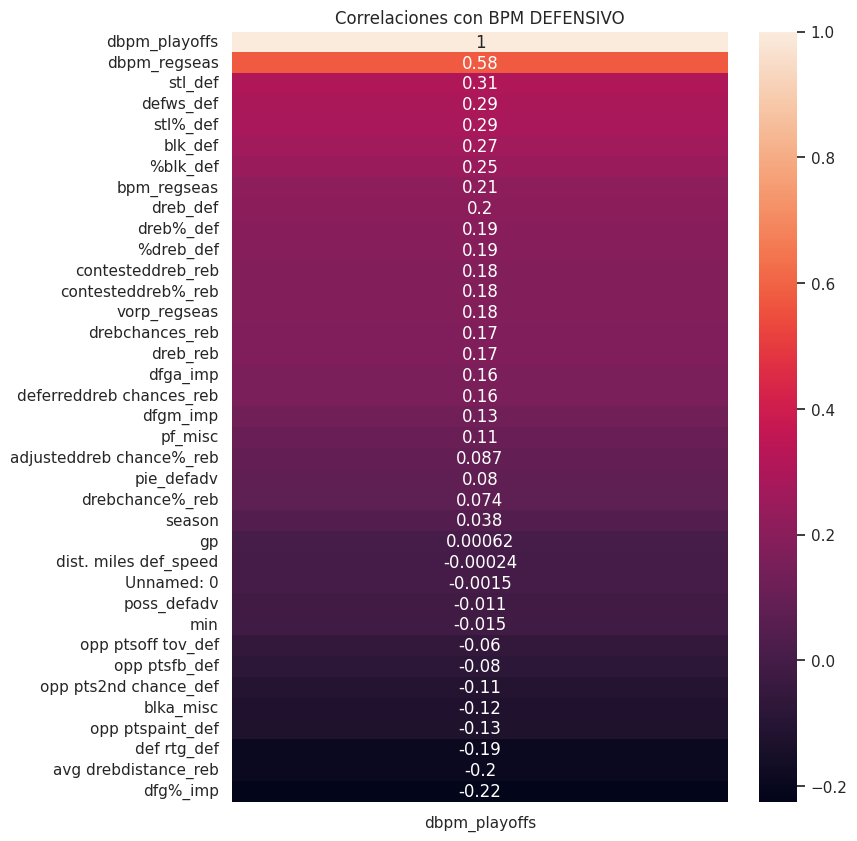

In [ ]:
# Mapa de calor para revisar correlaciones con variable objetivo DBPM

corr = defense.corr(numeric_only = True)
dbpm_corr = corr[["dbpm_playoffs"]]
sbrn.set(rc = {'figure.figsize':(8, 10)})
heatmap = sbrn.heatmap(dbpm_corr.sort_values(by = ["dbpm_playoffs"], ascending = False), annot = True)
plt.title('Correlaciones con BPM DEFENSIVO')

Text(0.5, 1.0, 'Correlaciones con BPM DEFENSIVO')

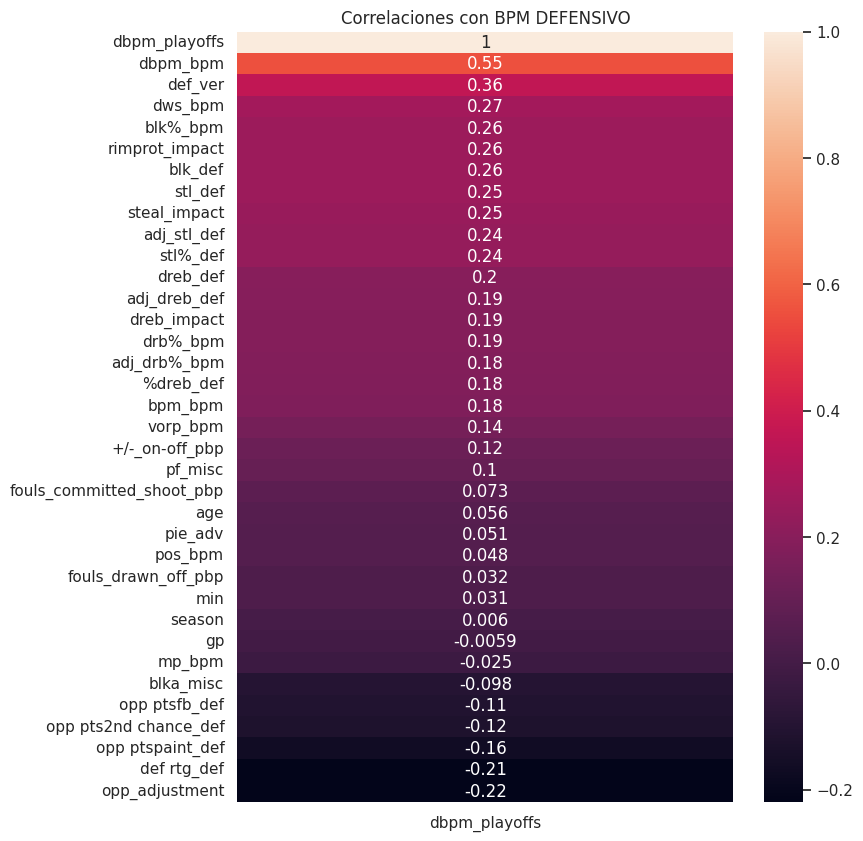

In [ ]:
# Mapa de calor para revisar correlaciones con variable objetivo DBPM

corr = ext_defense.corr(numeric_only = True)
dbpm_corr = corr[["dbpm_playoffs"]]
sbrn.set(rc = {'figure.figsize':(8, 10)})
heatmap = sbrn.heatmap(dbpm_corr.sort_values(by = ["dbpm_playoffs"], ascending = False), annot = True)
plt.title('Correlaciones con BPM DEFENSIVO')

---
# 2.2. Análisis de correlación de variables con BPM OFENSIVO
---

Text(0.5, 1.0, 'Correlaciones con BPM OFENSIVO')

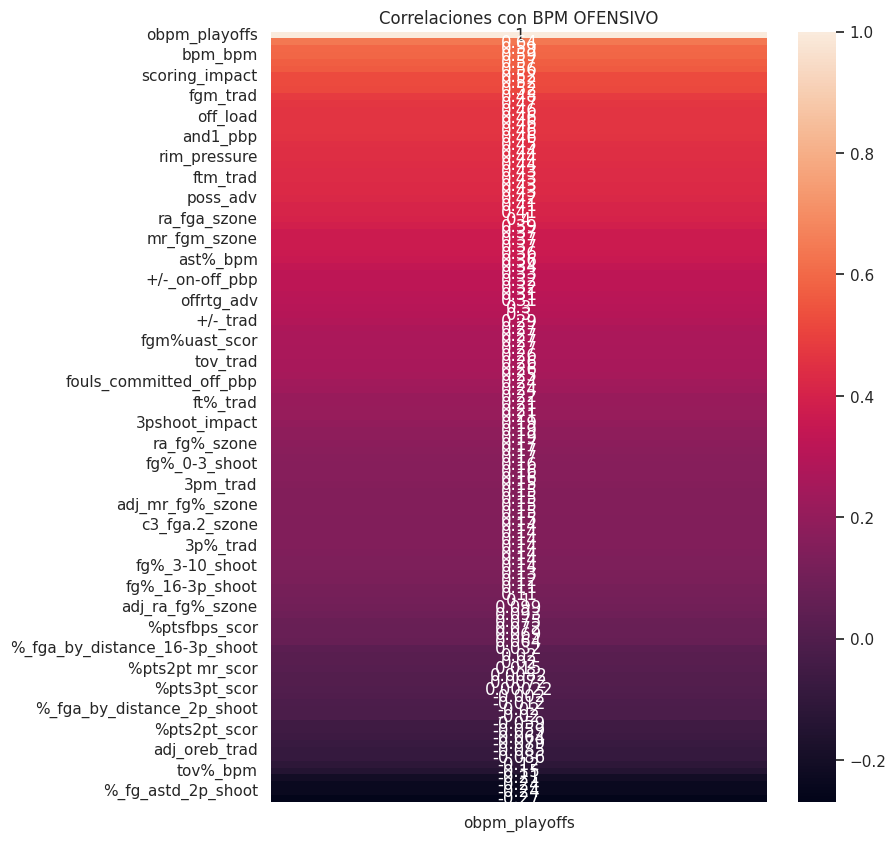

In [ ]:
# Mapa de calor para revisar correlaciones con variable objetivo OBPM

corr = ext_offense.corr(numeric_only = True)
obpm_corr = corr[["obpm_playoffs"]]
sbrn.set(rc = {'figure.figsize':(8, 10)})
heatmap = sbrn.heatmap(obpm_corr.sort_values(by = ["obpm_playoffs"], ascending = False), annot = True)
plt.title('Correlaciones con BPM OFENSIVO')

In [ ]:
cut_pos_val = 0.1
cut_neg_val = -0.1

In [ ]:
obpm_corr = obpm_corr[(obpm_corr["obpm_playoffs"] > cut_pos_val) | (obpm_corr["obpm_playoffs"] < cut_neg_val)]

In [ ]:
trans_obpm_corr = obpm_corr.T  # Using .T attribute to transpose the DataFrame

In [ ]:
off_keep_col = list(trans_obpm_corr.columns)
off_keep_col.extend(['player', 'season'])

In [ ]:
offense.head(3)

,Unnamed: 0,season,player,team,gp,min,offrtg_adv,ast%_adv,ast/to_adv,ast ratio_adv,...,fta_trad,ft%_trad,oreb_trad,ast_trad,tov_trad,+/-_trad,obpm_regseas,obpm_regseas.1,vorp_regseas,obpm_playoffs
0,0,2015,Aaron Brooks,CHI,82,23.00,107.20,24.50,1.66,20.00,...,4.70,83.30,0.90,7.00,4.20,5.60,0.30,0.30,0.50,-4.40
1,1,2019,Aaron Gordon,ORL,78,33.80,107.40,16.60,1.78,18.00,...,4.60,73.10,2.40,5.30,3.00,2.00,0.30,0.30,1.70,1.70
2,2,2021,Aaron Gordon,DEN,50,27.70,112.50,16.50,1.66,19.60,...,5.20,65.10,2.70,5.60,3.40,2.10,0.20,0.20,0.70,-2.20


---
# 3. Predicciones DEF DESDE 1997 con RANDOM FOREST, REG LINEAL y RIDGE
---

In [ ]:
ext_defense.shape

(4172, 37)

In [ ]:
# Split de train y test dejando solo la última temporada como test

ext_def_test = ext_defense[ext_defense['season'] == 2023]
ext_def_train = ext_defense[ext_defense['season'] != 2023]

In [ ]:
# Separando features y target en DEFENSA

# features (x)
def_train_features = ext_def_train.drop(['dbpm_playoffs', 'player', 'season'], axis=1)
def_test_features = ext_def_test.drop(['dbpm_playoffs', 'player', 'season'], axis=1)

# target (y)
def_train_target = ext_def_train['dbpm_playoffs']
def_test_target = ext_def_test['dbpm_playoffs']

In [ ]:
# Construcción e iniciación del modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamiento del modelo
rf_model.fit(def_train_features, def_train_target)

# Predicciones
ext_def_rf_pred = rf_model.predict(def_test_features)

# Evaluación del modelo
mse = mean_squared_error(def_test_target, ext_def_rf_pred)
r2 = r2_score(def_test_target, ext_def_rf_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

###
# Mean Squared Error: 2.1620944556962023
# R-squared Score: 0.13785942884981706
###

Mean Squared Error: 2.131012753164557
R-squared Score: 0.15025333546308017


In [ ]:
# Get feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(def_train_features.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

dbpm_bpm: 0.3315990584619942
pie_adv: 0.03125042546529153
opp pts2nd chance_def: 0.031077386816428784
opp_adjustment: 0.029864897377262146
opp ptsfb_def: 0.028468224809608554
+/-_on-off_pbp: 0.02825038618463225
min: 0.026627896235935852
mp_bpm: 0.026390970385246466
opp ptspaint_def: 0.026360894946507996
rimprot_impact: 0.026244932633109938
fouls_committed_shoot_pbp: 0.02606780649863537
steal_impact: 0.025937487869366605
def rtg_def: 0.025232456361130626
bpm_bpm: 0.024548857207480502
pf_misc: 0.024239367072591632
age: 0.023118119213178922
adj_stl_def: 0.022654389200115897
stl%_def: 0.022291242944685572
dws_bpm: 0.021188410342635192
def_ver: 0.02117353748951443
gp: 0.02090353061109469
blka_misc: 0.018744725669358538
blk%_bpm: 0.01561225575560709
fouls_drawn_off_pbp: 0.0153619344110525
vorp_bpm: 0.014474185980660572
dreb_impact: 0.012553133910573966
adj_dreb_def: 0.012122270805593874
adj_drb%_bpm: 0.011875962672390532
stl_def: 0.011510256918840705
%dreb_def: 0.011141462439492824
blk_def: 

In [ ]:
# comparison_df = ext_def_test
comparison_df_def = ext_def_test
comparison_df_def['rf_97_pred_dbpm'] = ext_def_rf_pred

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(comparison_df_def, x='dbpm_playoffs', y='rf_97_pred_dbpm', color='dbpm_playoffs', color_continuous_scale='portland',
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs',
                  xaxis_title='DBPM Postemporada',
                  yaxis_title='DBPM Predicciones R-Forest',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-5, y0=-5, x1=5, y1=5)

# Show the interactive plot
fig.show()

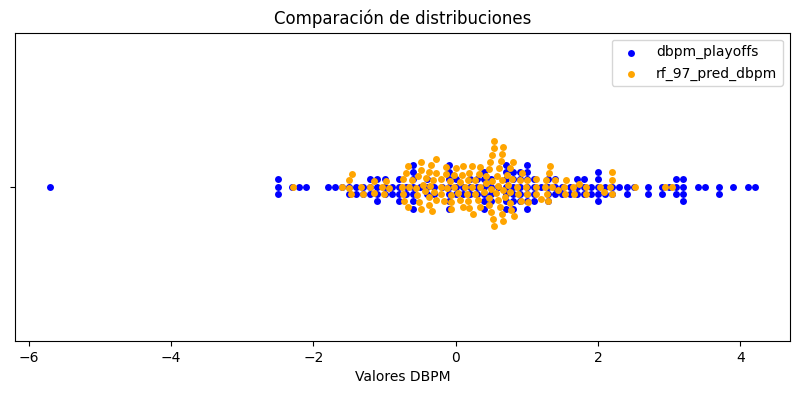

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 4))

# Combine both swarm plots in a single plot with 'hue' parameter
sbrn.swarmplot(data=comparison_df_def, x='dbpm_playoffs', color='blue', label='dbpm_playoffs')
sbrn.swarmplot(data=comparison_df_def, x='rf_97_pred_dbpm', color='orange', label='rf_97_pred_dbpm')

# Add any additional customization if needed
plt.title('Comparación de distribuciones')
plt.xlabel('Valores DBPM')  # Add the appropriate x-axis label
plt.legend()  # Add legend to distinguish between the two sets of points

# Show the plot
plt.show()

In [ ]:
# Construcción e iniciación del modelo
linreg_model = LinearRegression()

# Entrenamiento del modelo
linreg_model.fit(def_train_features, def_train_target)


# Predicciones
ext_def_lm_pred = linreg_model.predict(def_test_features)

# Evaluación del modelo
mse = mean_squared_error(def_test_target, ext_def_lm_pred)
r2 = r2_score(def_test_target, ext_def_lm_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

###
# Mean Squared Error: 2.019232449793044
# R-squared Score: 0.19482601097138752
###

Mean Squared Error: 2.144416510630633
R-squared Score: 0.14490855365351762


In [ ]:
# Get feature importances from the trained model
feature_importances = linreg_model.coef_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(def_train_features.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

dbpm_bpm: 0.6310460824272927
adj_dreb_def: 0.5725052778467099
stl_def: 0.2598987736626978
vorp_bpm: 0.19764189911104726
rimprot_impact: 0.16233383744603483
drb%_bpm: 0.16002794891008834
blk%_bpm: 0.13224243191412655
dws_bpm: 0.10452909526894856
opp_adjustment: 0.08527853957179071
def_ver: 0.08181611968371641
blka_misc: 0.05030087214942892
dreb_impact: 0.036594990966933846
age: 0.010554095233540665
fouls_drawn_off_pbp: 0.005269886422047684
pos_bpm: 0.005197392449557361
gp: 0.0031929228539863885
mp_bpm: -0.00024072145571624136
fouls_committed_shoot_pbp: -0.0017761754865763294
stl%_def: -0.003267111985066329
+/-_on-off_pbp: -0.00335153252449056
def rtg_def: -0.005332866726278955
%dreb_def: -0.006010267315974298
adj_stl_def: -0.014055200504665674
opp ptspaint_def: -0.015318378283364112
min: -0.022111655966051996
opp ptsfb_def: -0.02960123296902589
opp pts2nd chance_def: -0.03836068373669328
pf_misc: -0.05648006604108721
bpm_bpm: -0.05751574866672636
pie_adv: -0.10994727441944506
steal_impa

In [ ]:
comparison_df_def['lm_97_pred_dbpm'] = ext_def_lm_pred

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(comparison_df_def, x='dbpm_playoffs', y='lm_97_pred_dbpm', color='dbpm_playoffs', color_continuous_scale='portland',
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs',
                  xaxis_title='DBPM Postemporada',
                  yaxis_title='DBPM Predicciones Reg-Lineal',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-5, y0=-5, x1=5, y1=5)

# Show the interactive plot
fig.show()

In [ ]:
# Construcción e iniciación del modelo
ridge_model = Ridge(random_state=42, max_iter=10000)

# Entrenamiento del modelo
ridge_model.fit(def_train_features, def_train_target)


# Predicciones
ext_def_ridge_pred = ridge_model.predict(def_test_features)

# Evaluación del modelo
mse = mean_squared_error(def_test_target, ext_def_ridge_pred)
r2 = r2_score(def_test_target, ext_def_ridge_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

###
# Mean Squared Error: 2.272649548679285
# R-squared Score: 0.007540803988347666
###

Mean Squared Error: 2.1365313950215152
R-squared Score: 0.14805276322166117


In [ ]:
# Get feature importances from the trained model
feature_importances = ridge_model.coef_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(def_train_features.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

dbpm_bpm: 0.6301648675739626
adj_dreb_def: 0.5295912205385561
stl_def: 0.2492741790422487
vorp_bpm: 0.19716271728635415
rimprot_impact: 0.1577559318092235
drb%_bpm: 0.13990172304724013
blk%_bpm: 0.13169809218601955
dws_bpm: 0.10439869152799552
def_ver: 0.08062367337644197
blka_misc: 0.04982285622783839
opp_adjustment: 0.04460479637286879
dreb_impact: 0.03224516110931693
age: 0.010520435174714337
fouls_drawn_off_pbp: 0.005266565034442854
pos_bpm: 0.00522058468711626
gp: 0.0031400867595867757
mp_bpm: -0.0002400879351303042
fouls_committed_shoot_pbp: -0.0017684728074955501
stl%_def: -0.0031849385000231136
+/-_on-off_pbp: -0.0033819983461607574
def rtg_def: -0.004984415539539808
adj_stl_def: -0.005180691829983173
%dreb_def: -0.005680090627288317
opp ptspaint_def: -0.01422417496731542
min: -0.022150421353020058
opp ptsfb_def: -0.026080066261100654
opp pts2nd chance_def: -0.03424138444253338
pf_misc: -0.056631042173335956
bpm_bpm: -0.056958419907187176
steal_impact: -0.10937741954192205
pie_

In [ ]:
comparison_df_def['ridge_97_pred_dbpm'] = ext_def_ridge_pred

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(comparison_df_def, x='dbpm_playoffs', y='ridge_97_pred_dbpm', color='dbpm_playoffs', color_continuous_scale='portland',
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs',
                  xaxis_title='DBPM Postemporada',
                  yaxis_title='DBPM Predicciones Lasso',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-5, y0=-5, x1=5, y1=5)

# Show the interactive plot
fig.show()

---
# 3.1. Predicciones DEF DESDE 2014 con RANDOM FOREST, REG LINEAL y RIDGE
---

In [ ]:
defense.head(3)

,Unnamed: 0,season,player,team,gp,min,dist. miles def_speed,def rtg_def,dreb_def,dreb%_def,...,drebchance%_reb,deferreddreb chances_reb,adjusteddreb chance%_reb,avg drebdistance_reb,pie_defadv,poss_defadv,dbpm_regseas,bpm_regseas,vorp_regseas,dbpm_playoffs
0,0,2015,Aaron Brooks,CHI,82,23.00,0.71,102.10,3.60,6.80,...,49.30,0.30,53.00,10.30,9.20,3715,-1.10,-0.80,0.50,-2.20
1,1,2019,Aaron Gordon,ORL,76,33.80,1.12,105.90,8.20,16.50,...,70.80,0.60,76.00,6.30,10.90,5456,0.30,0.60,1.70,1.80
2,2,2021,Aaron Gordon,DEN,50,27.70,0.89,110.40,7.20,15.00,...,71.60,0.50,78.10,6.30,9.50,2868,-0.10,0.10,0.70,-1.80


In [ ]:
# Split de train y test dejando solo la última temporada como test

def_test_14 = defense[defense['season'] == 2023]
def_train_14 = defense[defense['season'] != 2023]

In [ ]:
# Separando features y target en DEFENSA

# features (x)
def_train_features_14 = def_train_14.drop(['dbpm_playoffs', 'player', 'season', 'team'], axis=1)
def_test_features_14 = def_test_14.drop(['dbpm_playoffs', 'player', 'season', 'team'], axis=1)

# target (y)
def_train_target_14 = def_train_14['dbpm_playoffs']
def_test_target_14 = def_test_14['dbpm_playoffs']

In [ ]:
# Construcción e iniciación del modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamiento del modelo
rf_model.fit(def_train_features_14, def_train_target_14)

# Predicciones
def_rf_pred = rf_model.predict(def_test_features_14)

# Evaluación del modelo
mse = mean_squared_error(def_test_target_14, def_rf_pred)
r2 = r2_score(def_test_target_14, def_rf_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 1.8656973851351348
R-squared Score: 0.1852555850820452


In [ ]:
# Get feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(def_train_features_14.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

dbpm_regseas: 0.3652502168362888
pf_misc: 0.034127352220144715
Unnamed: 0: 0.033947334915037514
opp pts2nd chance_def: 0.028617939665084594
opp ptsfb_def: 0.028340131776520915
opp ptsoff tov_def: 0.02528261506286463
%blk_def: 0.025249811421268174
opp ptspaint_def: 0.02382563652201107
min: 0.023118884055569652
dfg%_imp: 0.0228269639667174
defws_def: 0.022722361591463104
bpm_regseas: 0.02227343091529548
stl%_def: 0.021761440245775338
gp: 0.021618485986445318
contesteddreb%_reb: 0.02076866342029642
poss_defadv: 0.020716650336590064
pie_defadv: 0.020199827154790847
def rtg_def: 0.019525710899415516
adjusteddreb chance%_reb: 0.01781143917405531
dist. miles def_speed: 0.01699518894874006
drebchance%_reb: 0.016343659179020708
vorp_regseas: 0.015089792066057883
blka_misc: 0.014942980387600115
stl_def: 0.01406786578110529
dfga_imp: 0.013917625874520301
dfgm_imp: 0.013675339094621692
avg drebdistance_reb: 0.013444083950887486
%dreb_def: 0.01335365607671284
blk_def: 0.012443513537825255
dreb%_def

In [ ]:
comparison_df_14 = def_test_14
comparison_df_14['rf_14_pred_dbpm'] = def_rf_pred

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(comparison_df_14, x='dbpm_playoffs', y='rf_14_pred_dbpm',
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs',
                  xaxis_title='DBPM Postemporada',
                  yaxis_title='DBPM Predicciones R-Forest',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-5, y0=-5, x1=5, y1=5)

# Show the interactive plot
fig.show()

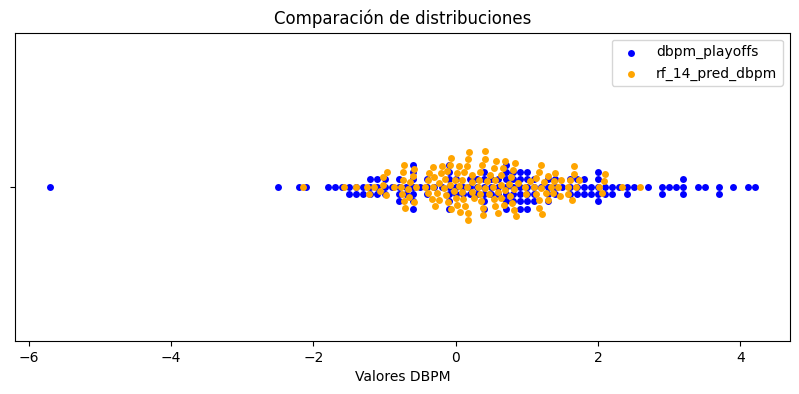

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 4))

# Combine both swarm plots in a single plot with 'hue' parameter
sbrn.swarmplot(data=comparison_df_14, x='dbpm_playoffs', color='blue', label='dbpm_playoffs')
sbrn.swarmplot(data=comparison_df_14, x='rf_14_pred_dbpm', color='orange', label='rf_14_pred_dbpm')

# Add any additional customization if needed
plt.title('Comparación de distribuciones')
plt.xlabel('Valores DBPM')  # Add the appropriate x-axis label
plt.legend()  # Add legend to distinguish between the two sets of points

# Show the plot
plt.show()

In [ ]:
# Construcción e iniciación del modelo
linreg_model = LinearRegression()

# Entrenamiento del modelo
linreg_model.fit(def_train_features_14, def_train_target_14)


# Predicciones
def_lm_pred = linreg_model.predict(def_test_features_14)

# Evaluación del modelo
mse = mean_squared_error(def_test_target_14, def_lm_pred)
r2 = r2_score(def_test_target_14, def_lm_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 1.7927614120681343
R-squared Score: 0.21710650430206702


In [ ]:
# Get feature importances from the trained model
feature_importances = linreg_model.coef_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(def_train_features_14.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

dist. miles def_speed: 0.9339914854242128
dbpm_regseas: 0.7385644674496281
dfgm_imp: 0.5868063975812966
drebchances_reb: 0.34786252055891626
defws_def: 0.3038362503380285
stl_def: 0.29642104984227313
vorp_regseas: 0.2443658675271276
dreb_def: 0.12207975219915292
blk_def: 0.08701200221977914
adjusteddreb chance%_reb: 0.06964778424831737
contesteddreb%_reb: 0.03615434231965863
avg drebdistance_reb: 0.026632081656974844
gp: 0.0041259392933601455
%blk_def: 0.0015026375000998095
Unnamed: 0: -3.594389665386294e-05
poss_defadv: -0.0001625609280237433
opp ptspaint_def: -0.005158893662058798
opp ptsfb_def: -0.006053256555766827
def rtg_def: -0.007728343873344541
opp pts2nd chance_def: -0.00792273475757204
stl%_def: -0.009603026682763902
dfg%_imp: -0.011256215512081823
opp ptsoff tov_def: -0.013075485838240499
%dreb_def: -0.013536669523800789
pie_defadv: -0.02894690729471656
min: -0.03291816189538335
drebchance%_reb: -0.03665825182167197
dreb%_def: -0.042879534275448175
pf_misc: -0.0864690526166

In [ ]:
comparison_df_14['lm_14_pred_dbpm'] = def_lm_pred

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(comparison_df_14, x='dbpm_playoffs', y='lm_14_pred_dbpm',
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs',
                  xaxis_title='DBPM Postemporada',
                  yaxis_title='DBPM Predicciones Reg-Lineal',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-5, y0=-5, x1=5, y1=5)

# Show the interactive plot
fig.show()

In [ ]:
# Construcción e iniciación del modelo
ridge_model = Ridge(random_state=42, max_iter=10000)

# Entrenamiento del modelo
ridge_model.fit(def_train_features_14, def_train_target_14)


# Predicciones
def_ridge_pred = ridge_model.predict(def_test_features_14)

# Evaluación del modelo
mse = mean_squared_error(def_test_target_14, def_ridge_pred)
r2 = r2_score(def_test_target_14, def_ridge_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 1.7911706512003869
R-squared Score: 0.2178011847699679


In [ ]:
# Get feature importances from the trained model
feature_importances = ridge_model.coef_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(def_train_features_14.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

dbpm_regseas: 0.7400442121075755
dist. miles def_speed: 0.6709053804319609
dfgm_imp: 0.5262077953087798
drebchances_reb: 0.3118472803795269
stl_def: 0.3065446430728889
vorp_regseas: 0.23836038760566297
defws_def: 0.14537693898852708
dreb_def: 0.12710034129425385
blk_def: 0.08551849868648051
adjusteddreb chance%_reb: 0.06109735835513425
contesteddreb%_reb: 0.034811653546982645
avg drebdistance_reb: 0.02180316768509813
gp: 0.003264344601748324
%blk_def: 0.001418800885723162
Unnamed: 0: -3.4615329367891007e-05
poss_defadv: -0.00014418010398955012
opp ptspaint_def: -0.004342045208585265
opp ptsfb_def: -0.007631433921801679
opp pts2nd chance_def: -0.008638072777691951
def rtg_def: -0.008929620432263941
stl%_def: -0.010168948836414312
dfg%_imp: -0.010262165046699865
opp ptsoff tov_def: -0.013219433908036364
%dreb_def: -0.013867614830210507
min: -0.025524101183094772
drebchance%_reb: -0.029242426697180347
pie_defadv: -0.03150389393230183
dreb%_def: -0.04437407097401048
pf_misc: -0.08590338414

In [ ]:
comparison_df_14['ridge_14_pred_dbpm'] = def_ridge_pred

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(comparison_df_14, x='dbpm_playoffs', y='ridge_14_pred_dbpm',
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs',
                  xaxis_title='DBPM Postemporada',
                  yaxis_title='DBPM Predicciones Lasso',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-5, y0=-5, x1=5, y1=5)

# Show the interactive plot
fig.show()

---
# 3.2. Análisis de RANKING - MAE - Rsq entre diferentes predicciones
---

In [ ]:
def add_ranking_column(df, columns):
    if 'dbpm_playoffs' not in df.columns:
        raise ValueError("The 'dbpm_playoffs' column is required for ranking. Please add it to the DataFrame.")

    # Calculate 'dbpm_playoffs_ranking'
    df['dbpm_playoffs_ranking'] = df['dbpm_playoffs'].rank(ascending=False, method='max')

    for col in columns:
        ranking_col_name = f"{col}_ranking"
        df[ranking_col_name] = df[col].rank(ascending=False, method='max')

        # Calculate rank differences
        rank_diff_col_name = f"{col}_rank_diff"
        df[rank_diff_col_name] = abs(df['dbpm_playoffs_ranking'] - df[ranking_col_name])

    return df

In [ ]:
columns_to_rank = ['dbpm_playoffs', 'rf_97_pred_dbpm', 'lm_97_pred_dbpm', 'ridge_97_pred_dbpm']

comparison_df_def = add_ranking_column(comparison_df_def, columns_to_rank)

In [ ]:
comp_def_diff_ls = ['dbpm_playoffs_rank_diff',
                    'rf_97_pred_dbpm_rank_diff',
                    'lm_97_pred_dbpm_rank_diff',
                    'ridge_97_pred_dbpm_rank_diff']

In [ ]:
comp_def_diff = comparison_df_def[comp_def_diff_ls]

In [ ]:
comp_def_diff.describe()

,dbpm_playoffs_rank_diff,rf_97_pred_dbpm_rank_diff,lm_97_pred_dbpm_rank_diff,ridge_97_pred_dbpm_rank_diff
count,158.00,158.00,158.00,158.00
mean,0.00,37.73,35.25,35.23
std,0.00,30.69,28.66,28.64
min,0.00,0.00,0.00,0.00
25%,0.00,10.00,13.00,13.00
50%,0.00,32.00,29.00,28.50
75%,0.00,54.00,51.75,51.75
max,0.00,128.00,122.00,122.00


In [ ]:
# Create a scatter plot with Plotly Express
fig = px.scatter(comparison_df_def, x='dbpm_playoffs_ranking', y='rf_97_pred_dbpm_ranking', color='rf_97_pred_dbpm_rank_diff',
                 hover_data=['player'],
                 title='Comparison of dbpm_playoffs and rf_97 ranking',
                 labels={'dbpm_playoffs': 'dbpm_playoffs', 'rf_97_rank_diff': 'rf_97_rank_diff'})

# Define threshold values for overvalued and undervalued
overvalued_threshold = 35  # Example threshold, adjust as needed
undervalued_threshold = -35  # Example threshold, adjust as needed

# Add lines to divide the scatter plot into regions
fig.add_shape(
    type='line',
    x0=min(comparison_df_def['dbpm_playoffs_ranking']),
    y0=min(comparison_df_def['rf_97_pred_dbpm_ranking']),
    x1=max(comparison_df_def['dbpm_playoffs_ranking']),
    y1=max(comparison_df_def['ridge_97_pred_dbpm_ranking']),
    line=dict(color='black', width=2),
)

fig.add_shape(
    type='line',
    x0=min(comparison_df_def['dbpm_playoffs_ranking']),
    y0=min(comparison_df_def['rf_97_pred_dbpm_ranking']) + overvalued_threshold,
    x1=max(comparison_df_def['dbpm_playoffs_ranking']),
    y1=max(comparison_df_def['rf_97_pred_dbpm_ranking']) + overvalued_threshold,
    line=dict(color='red', width=2, dash='dash'),
)

fig.add_shape(
    type='line',
    x0=min(comparison_df_def['dbpm_playoffs_ranking']),
    y0=min(comparison_df_def['rf_97_pred_dbpm_ranking']) + undervalued_threshold,
    x1=max(comparison_df_def['dbpm_playoffs_ranking']),
    y1=max(comparison_df_def['rf_97_pred_dbpm_ranking']) + undervalued_threshold,
    line=dict(color='green', width=2, dash='dash'),
)

# Show the plot
fig.show()

---
# 4. Cálculos de desempeño DBPM playoffs pasados
---

In [ ]:
print(ext_defense.head(3))

           player  season  pos_bpm  gp   min  dreb_impact  \
0     Aaron McKie    1997        2  83 52.70         0.30   
1      Adam Keefe    1997        5  62 51.90         0.47   
2  Alan Henderson    1997        4  30 51.20         0.40   

   fouls_drawn_off_pbp  rimprot_impact  steal_impact  opp_adjustment  ...  \
0                 0.00            0.16          0.25            2.09  ...   
1                 0.00            0.13          0.10            2.16  ...   
2                 0.00            0.08          0.11            3.52  ...   

   opp ptsfb_def  opp ptspaint_def  blka_misc  pf_misc  pie_adv  \
0          10.70             34.40       1.20     4.20     9.50   
1          10.80             38.20       0.70     5.50     8.30   
2          15.90             47.90       1.60     7.50     7.50   

   dbpm_playoffs  adj_dreb_def  adj_drb%_bpm  adj_stl_def  def_ver  
0           3.80          9.84         21.93         4.07     0.71  
1           2.10         11.94         

In [ ]:
df_with_past_seasons = add_past_playoff_performances(ext_defense)

In [ ]:
lebron_df = df_with_past_seasons[(df_with_past_seasons['player'] == 'Anthony Edwards') | \
                                 (df_with_past_seasons['player'] == 'Austin Reaves') | \
                                 (df_with_past_seasons['player'] == 'Jalen Brunson') | \
                                 (df_with_past_seasons['player'] == 'Donovan Mitchell')]

In [ ]:
keep_col_lebron = ['player', 'season', 'pos_bpm', 'dbpm_bpm', 'dbpm_playoffs', '1_seas_past_dbpm_playoffs', '2_seas_past_dbpm_playoffs',
                   '3_seas_past_dbpm_playoffs', '4_seas_past_dbpm_playoffs', '5_seas_past_dbpm_playoffs']

lebron_df = lebron_df[keep_col_lebron]

In [ ]:
lebron_df.sort_values(by=['player', 'season'])

,player,season,pos_bpm,dbpm_bpm,dbpm_playoffs,1_seas_past_dbpm_playoffs,2_seas_past_dbpm_playoffs,3_seas_past_dbpm_playoffs,4_seas_past_dbpm_playoffs,5_seas_past_dbpm_playoffs
3856,Anthony Edwards,2022,2,-0.40,0.20,NaN,NaN,NaN,NaN,NaN
4019,Anthony Edwards,2023,2,0.00,3.20,0.20,NaN,NaN,NaN,NaN
4020,Austin Reaves,2023,2,0.10,0.20,NaN,NaN,NaN,NaN,NaN
3239,Donovan Mitchell,2018,2,0.30,0.90,NaN,NaN,NaN,NaN,NaN
3404,Donovan Mitchell,2019,2,0.10,-1.30,0.90,NaN,NaN,NaN,NaN
3557,Donovan Mitchell,2020,2,-0.60,0.20,-1.30,0.90,NaN,NaN,NaN
3729,Donovan Mitchell,2021,1,-0.20,-0.40,0.20,-1.30,0.90,NaN,NaN
3898,Donovan Mitchell,2022,2,-0.30,-1.10,-0.40,0.20,-1.30,0.90,NaN
4056,Donovan Mitchell,2023,2,0.60,2.00,-1.10,-0.40,0.20,-1.30,0.90
3754,Jalen Brunson,2021,1,-0.60,-2.10,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Applying the custom filling logic
df_filled_custom = fill_na_values_custom_def(lebron_df)

# Displaying a part of the resulting dataframe to check the implementation
df_filled_custom

,player,season,pos_bpm,dbpm_bpm,dbpm_playoffs,1_seas_past_dbpm_playoffs,2_seas_past_dbpm_playoffs,3_seas_past_dbpm_playoffs,4_seas_past_dbpm_playoffs,5_seas_past_dbpm_playoffs
0,Donovan Mitchell,2018,2,0.30,0.90,0.30,0.30,0.30,0.30,0.30
1,Donovan Mitchell,2019,2,0.10,-1.30,0.90,0.10,0.10,0.10,0.10
2,Donovan Mitchell,2020,2,-0.60,0.20,-1.30,0.90,-0.80,-0.80,-0.80
3,Donovan Mitchell,2021,1,-0.20,-0.40,0.20,-1.30,0.90,-0.65,-0.65
4,Donovan Mitchell,2022,2,-0.30,-1.10,-0.40,0.20,-1.30,0.90,-0.47
5,Donovan Mitchell,2023,2,0.60,2.00,-1.10,-0.40,0.20,-1.30,0.90
6,Jalen Brunson,2021,1,-0.60,-2.10,-0.60,-0.60,-0.60,-0.60,-0.60
7,Jalen Brunson,2022,2,0.00,-0.50,-2.10,0.00,0.00,0.00,0.00
8,Jalen Brunson,2023,1,-0.50,1.50,-0.50,-2.10,0.10,0.10,0.10
9,Anthony Edwards,2022,2,-0.40,0.20,-0.40,-0.40,-0.40,-0.40,-0.40


In [ ]:
mean_filled_def_past_seasons = fill_na_values_custom(df_with_past_seasons)

In [ ]:
mean_filled_def_past_seasons.head(5)

,player,season,pos_bpm,gp,min,dreb_impact,fouls_drawn_off_pbp,rimprot_impact,steal_impact,opp_adjustment,...,dbpm_playoffs,adj_dreb_def,adj_drb%_bpm,adj_stl_def,def_ver,1_seas_past_dbpm_playoffs,2_seas_past_dbpm_playoffs,3_seas_past_dbpm_playoffs,4_seas_past_dbpm_playoffs,5_seas_past_dbpm_playoffs
0,Aaron McKie,1997,2,83,52.70,0.30,0.00,0.16,0.25,2.09,...,3.80,9.84,21.93,4.07,0.71,2.00,2.00,2.00,2.00,2.00
1,Aaron McKie,1999,2,50,51.20,0.45,0.00,0.03,0.26,2.29,...,2.20,11.32,25.40,5.14,0.75,2.50,3.80,2.50,2.50,2.50
2,Aaron McKie,2000,2,82,49.80,0.30,8.00,0.11,0.55,2.13,...,1.20,9.58,21.49,4.13,0.96,2.20,2.70,3.80,2.70,2.70
3,Aaron McKie,2001,2,76,51.50,0.31,0.00,0.04,0.38,2.25,...,1.00,10.31,22.65,3.50,0.73,1.20,2.20,1.40,3.80,1.40
4,Aaron McKie,2002,2,48,52.30,0.34,0.00,0.12,0.17,2.31,...,0.70,10.34,22.68,3.72,0.63,1.00,1.20,2.20,1.17,3.80


In [ ]:
# Split de train y test dejando solo la última temporada como test

past_seas_test_ext = mean_filled_def_past_seasons[mean_filled_def_past_seasons['season'] == 2023]
past_seas_train_ext = mean_filled_def_past_seasons[mean_filled_def_past_seasons['season'] != 2023]

# Separando features y target DEF PAST PLAYOFFS

# features (x)
past_seas_train_ext_features = past_seas_train_ext.drop(['dbpm_playoffs', 'player', 'season'], axis=1)
past_seas_test_ext_features = past_seas_test_ext.drop(['dbpm_playoffs', 'player', 'season'], axis=1)

# target (y)
past_seas_train_ext_target = past_seas_train_ext['dbpm_playoffs']
past_seas_test_ext_target = past_seas_test_ext['dbpm_playoffs']

---
## 4.1. Playoffs pasados con rolling
---

In [ ]:
keep_col_rolling = ['player', 'season', 'pos_bpm', 'dbpm_bpm', 'dbpm_playoffs']

mean_filled_df = ext_defense[keep_col_rolling]

In [ ]:
result_df = calculate_rolling_def_dynamic(mean_filled_df, rolling_years_list=[2, 3, 4, 5])

In [ ]:
lebron_mean_filled = result_df[(result_df['player'] == 'Anthony Edwards') | \
                               (result_df['player'] == 'Austin Reaves') | \
                               (result_df['player'] == 'Jalen Brunson') | \
                               (result_df['player'] == 'Donovan Mitchell')]

In [ ]:
lebron_mean_filled.sort_values(by=['player', 'season'])

,player,season,pos_bpm,dbpm_bpm,dbpm_playoffs,2_yr_rolling_avg_dbpm_playoffs,3_yr_rolling_avg_dbpm_playoffs,4_yr_rolling_avg_dbpm_playoffs,5_yr_rolling_avg_dbpm_playoffs
3856,Anthony Edwards,2022,2,-0.40,0.20,-0.40,-0.40,-0.40,-0.40
4019,Anthony Edwards,2023,2,0.00,3.20,0.20,0.20,0.20,0.20
4020,Austin Reaves,2023,2,0.10,0.20,0.10,0.10,0.10,0.10
3239,Donovan Mitchell,2018,2,0.30,0.90,0.30,0.30,0.30,0.30
3404,Donovan Mitchell,2019,2,0.10,-1.30,0.90,0.90,0.90,0.90
3557,Donovan Mitchell,2020,2,-0.60,0.20,-0.20,-0.20,-0.20,-0.20
3729,Donovan Mitchell,2021,1,-0.20,-0.40,-0.55,-0.07,-0.07,-0.07
3898,Donovan Mitchell,2022,2,-0.30,-1.10,-0.10,-0.50,-0.15,-0.15
4056,Donovan Mitchell,2023,2,0.60,2.00,-0.75,-0.43,-0.65,-0.34
3754,Jalen Brunson,2021,1,-0.60,-2.10,-0.60,-0.60,-0.60,-0.60


In [ ]:
rolling_def_df = calculate_rolling_def_dynamic(ext_defense, rolling_years_list=[2, 3, 4, 5])

In [ ]:
# Split de train y test dejando solo la última temporada como test

rolling_def_test_ext = rolling_def_df[rolling_def_df['season'] == 2023]
rolling_def_train_ext = rolling_def_df[rolling_def_df['season'] != 2023]

In [ ]:
# Separando features y target DEF PAST PLAYOFFS

# features (x)
rolling_def_train_ext_features = rolling_def_train_ext.drop(['dbpm_playoffs', 'player', 'season'], axis=1)
rolling_def_test_ext_features = rolling_def_test_ext.drop(['dbpm_playoffs', 'player', 'season'], axis=1)

# target (y)
rolling_def_train_ext_target = rolling_def_train_ext['dbpm_playoffs']
rolling_def_test_ext_target = rolling_def_test_ext['dbpm_playoffs']

---
# 4.1. Predicciones DEF agregando Playoffs pasados
---

In [ ]:
# Evaluación de modelos con dataset original para referencia

evaluate_models(def_train_features, def_train_target, def_test_features, def_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.2750284980069756
R-squared Score: 0.8984771800499567
Test Set:
Mean Squared Error: 2.131012753164557
R-squared Score: 0.15025333546308017

Linear Regression Model:
Training Set:
Mean Squared Error: 1.8001998634087981
R-squared Score: 0.33548207574362465
Test Set:
Mean Squared Error: 2.144416510630633
R-squared Score: 0.14490855365351762

Ridge Regression Model:
Training Set:
Mean Squared Error: 1.8002119046383398
R-squared Score: 0.33547763089668114
Test Set:
Mean Squared Error: 2.1365313950215152
R-squared Score: 0.14805276322166117


In [ ]:
# Evaluación de modelos con dataset PAST PLAYOFFS DBPM

evaluate_models(past_seas_train_ext_features, past_seas_train_ext_target, past_seas_test_ext_features, past_seas_test_ext_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.2676226407573494
R-squared Score: 0.9012109458872353
Test Set:
Mean Squared Error: 2.036044449367089
R-squared Score: 0.18812218409797876

Linear Regression Model:
Training Set:
Mean Squared Error: 1.7851731854259831
R-squared Score: 0.34102895810073197
Test Set:
Mean Squared Error: 2.0851842795012825
R-squared Score: 0.1685275539436386

Ridge Regression Model:
Training Set:
Mean Squared Error: 1.7851883467965282
R-squared Score: 0.34102336149855006
Test Set:
Mean Squared Error: 2.078110863356408
R-squared Score: 0.17134809632052628


In [ ]:
# Evaluación de modelos con dataset PLAYOFFS ROLLING AVERAGE

evaluate_models(rolling_def_train_ext_features, rolling_def_train_ext_target, rolling_def_test_ext_features, rolling_def_test_ext_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.2728903734429497
R-squared Score: 0.8992664380240116
Test Set:
Mean Squared Error: 2.0415725696202527
R-squared Score: 0.18591783232236936

Linear Regression Model:
Training Set:
Mean Squared Error: 1.789597698831168
R-squared Score: 0.3393957125241599
Test Set:
Mean Squared Error: 2.1219931267442598
R-squared Score: 0.15384993405435332

Ridge Regression Model:
Training Set:
Mean Squared Error: 1.7896109927478374
R-squared Score: 0.33939080526575494
Test Set:
Mean Squared Error: 2.114910217554466
R-squared Score: 0.15667426180664268


In [ ]:
# Construcción e iniciación del modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamiento del modelo
rf_model.fit(past_seas_train_ext_features, past_seas_train_ext_target)

# Predicciones
def_rf_pred = rf_model.predict(past_seas_test_ext_features)

In [ ]:
comparison_df_def['rf_97_rolling_av'] = def_rf_pred

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(comparison_df_def, x='dbpm_playoffs', y='rf_97_rolling_av', color='dbpm_playoffs', color_continuous_scale='portland',
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs',
                  xaxis_title='DBPM Postemporada',
                  yaxis_title='DBPM Predicciones R-Forest',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-5, y0=-5, x1=5, y1=5)

# Show the interactive plot
fig.show()

---
# 5. Búsqueda de "Clones" DEFENSIVOS
---

In [ ]:
print(ext_defense.head(3))

           player  season  pos_bpm  gp   min  dreb_impact  \
0     Aaron McKie    1997        2  83 52.70         0.30   
1      Adam Keefe    1997        5  62 51.90         0.47   
2  Alan Henderson    1997        4  30 51.20         0.40   

   fouls_drawn_off_pbp  rimprot_impact  steal_impact  opp_adjustment  ...  \
0                 0.00            0.16          0.25            2.09  ...   
1                 0.00            0.13          0.10            2.16  ...   
2                 0.00            0.08          0.11            3.52  ...   

   opp ptsfb_def  opp ptspaint_def  blka_misc  pf_misc  pie_adv  \
0          10.70             34.40       1.20     4.20     9.50   
1          10.80             38.20       0.70     5.50     8.30   
2          15.90             47.90       1.60     7.50     7.50   

   dbpm_playoffs  adj_dreb_def  adj_drb%_bpm  adj_stl_def  def_ver  
0           3.80          9.84         21.93         4.07     0.71  
1           2.10         11.94         

In [ ]:
# Drop non-numeric columns and fill NaN values with 0
numeric_df = ext_defense.drop(['player', 'season'], axis=1).fillna(0)

# Normalize the numerical columns
scaler = StandardScaler()
normalized_df = scaler.fit_transform(numeric_df)

# Calculate cosine similarity
similarity_matrix = cosine_similarity(normalized_df)

# Choose the row for which you want to find similar seasons (e.g., the first row)
target_row = 3973

In [ ]:
# Get the similarity scores for the target row
similarity_scores = list(enumerate(similarity_matrix[target_row]))

# Sort the seasons based on similarity, excluding the current season
similar_seasons = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:6]

# Print the results
print(f"\nSeason: {ext_defense['season'][target_row]} - Player: {ext_defense['player'][target_row]}")
for season_index, similarity_score in similar_seasons:
    similar_season = ext_defense['season'][season_index]
    similar_player = ext_defense['player'][season_index]
    print(f"Similar Season: {similar_season} - {similar_player} - Similarity Score: {similarity_score:.2f}")


Season: 2022 - Player: Nikola Jokic
Similar Season: 2023 - Nikola Jokic - Similarity Score: 0.96
Similar Season: 2019 - Nikola Jokic - Similarity Score: 0.96
Similar Season: 2020 - Nikola Jokic - Similarity Score: 0.95
Similar Season: 2017 - Russell Westbrook - Similarity Score: 0.94
Similar Season: 2021 - Nikola Jokic - Similarity Score: 0.94


In [ ]:
# Calculate Euclidean distances
distance_matrix = euclidean_distances(normalized_df)

# Get the distance scores for the target row
distance_scores = list(enumerate(distance_matrix[target_row]))
# Filter out the current season
current_season = 2023
distance_scores = [(index, distance) for index, distance in distance_scores if int(ext_defense['season'].iloc[index]) != current_season]

# Sort the seasons based on distance, excluding the current season
similar_seasons = sorted(distance_scores, key=lambda x: x[1])[1:6]

# Print the results with player names
print(f"\nSeason: {ext_defense['season'][target_row]} - Player: {ext_defense['player'][target_row]}")
for season_index, distance_score in similar_seasons:
    similar_season = ext_defense['season'][season_index]
    similar_player = ext_defense['player'][season_index]
    print(f"Similar Season: {similar_season} - {similar_player} - Euclidean Distance: {distance_score:.2f}")


Season: 2022 - Player: Nikola Jokic
Similar Season: 2017 - Russell Westbrook - Euclidean Distance: 4.81
Similar Season: 2019 - Nikola Jokic - Euclidean Distance: 5.19
Similar Season: 2022 - Giannis Antetokounmpo - Euclidean Distance: 5.48
Similar Season: 2021 - Nikola Jokic - Euclidean Distance: 5.52
Similar Season: 2022 - Joel Embiid - Euclidean Distance: 5.72


In [ ]:
# Apply PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
pca_result = pca.fit_transform(normalized_df)

# Calculate Euclidean distances in the reduced space
distance_matrix = euclidean_distances(pca_result)

# Get the distance scores for the target row
distance_scores = list(enumerate(distance_matrix[target_row]))

# Sort the seasons based on distance, excluding the current season
similar_seasons = sorted(distance_scores, key=lambda x: x[1])[1:6]

# Print the results with player names
print(f"\nSeason: {ext_defense['season'][target_row]} - Player: {ext_defense['player'][target_row]}")
for season_index, distance_score in similar_seasons:
    similar_season = ext_defense['season'][season_index]
    similar_player = ext_defense['player'][season_index]
    print(f"Similar Season: {similar_season} - {similar_player} - Euclidean Dist. in PCA: {distance_score:.2f}")


Season: 2022 - Player: Nikola Jokic
Similar Season: 2003 - Kevin Garnett - Euclidean Dist. in PCA: 1.97
Similar Season: 2023 - Nikola Jokic - Euclidean Dist. in PCA: 1.99
Similar Season: 2002 - Tim Duncan - Euclidean Dist. in PCA: 2.52
Similar Season: 2004 - Kevin Garnett - Euclidean Dist. in PCA: 2.53
Similar Season: 2015 - Anthony Davis - Euclidean Dist. in PCA: 2.56


In [ ]:
# Calculate Pearson correlation coefficients
correlation_matrix = pd.DataFrame(normalized_df.T).corr().to_numpy()

# Get the correlation scores for the target row
correlation_scores = list(enumerate(correlation_matrix[target_row]))

# Sort the seasons based on correlation, excluding the current season
similar_seasons = sorted(correlation_scores, key=lambda x: x[1], reverse=True)[1:6]

# Print the results with player names
print(f"\nSeason: {ext_defense['season'][target_row]} - Player: {ext_defense['player'][target_row]}")
for season_index, correlation_score in similar_seasons:
    similar_season = ext_defense['season'][season_index]
    similar_player = ext_defense['player'][season_index]
    print(f"Similar Season: {similar_season} - Player: {similar_player} - Pearson Correlation: {correlation_score:.2f}")


Season: 2022 - Player: Nikola Jokic
Similar Season: 2023 - Player: Nikola Jokic - Pearson Correlation: 0.93
Similar Season: 2019 - Player: Nikola Jokic - Pearson Correlation: 0.93
Similar Season: 2020 - Player: Nikola Jokic - Pearson Correlation: 0.92
Similar Season: 2021 - Player: Nikola Jokic - Pearson Correlation: 0.92
Similar Season: 2017 - Player: Russell Westbrook - Pearson Correlation: 0.91


In [ ]:
# Function to get the mean 'dbpm_playoffs' for the most similar players
def get_mean_dbpm(row):
    target_row = row.name
    distance_scores = list(enumerate(distance_matrix[target_row]))
    similar_seasons = sorted(distance_scores, key=lambda x: x[1], reverse=False)[1:6]

    similar_players = [ext_defense['dbpm_playoffs'].iloc[season_index] for season_index, _ in similar_seasons]

    return pd.Series({'5_clones_dbpm': sum(similar_players) / len(similar_players)})

In [ ]:
clones_test = ext_defense[['player', 'season', 'pos_bpm', 'dbpm_playoffs']]

In [ ]:
clones_test['5_clones_dbpm'] = clones_test.apply(get_mean_dbpm, axis=1)['5_clones_dbpm']

In [ ]:
lebron_clones = clones_test[(clones_test['player'] == 'LeBron James') | (clones_test['player'] == 'Kawhi Leonard')]

In [ ]:
lebron_clones.sort_values(by=['player', 'season'])

,player,season,pos_bpm,dbpm_playoffs,5_clones_dbpm
2307,Kawhi Leonard,2012,3,2.20,2.56
2471,Kawhi Leonard,2013,3,2.50,2.16
2623,Kawhi Leonard,2014,3,2.80,2.10
2783,Kawhi Leonard,2015,3,1.50,2.56
2954,Kawhi Leonard,2016,3,4.40,2.04
3119,Kawhi Leonard,2017,3,3.70,2.26
3449,Kawhi Leonard,2019,3,2.40,2.16
3604,Kawhi Leonard,2020,3,2.90,1.98
3771,Kawhi Leonard,2021,3,2.60,1.26
4105,Kawhi Leonard,2023,3,3.70,0.20


In [ ]:
def get_mean_dbpm(row, distance_matrix, ext_defense, num_similar_players=5, activate_reverse=True):
    target_row = row.name
    distance_scores = list(enumerate(distance_matrix[target_row]))
    similar_seasons = sorted(distance_scores, key=lambda x: x[1], reverse=activate_reverse)[1:num_similar_players+1]

    similar_players = [ext_defense['dbpm_playoffs'].iloc[season_index] for season_index, _ in similar_seasons]

    return pd.Series({f'{num_similar_players}_clones_dbpm': sum(similar_players) / len(similar_players)})

In [ ]:
def get_mean_dbpm_exclude_current_season(row, distance_matrix, ext_defense, current_season=2023, num_similar_players=5, activate_reverse=True):
    target_row = row.name
    distance_scores = list(enumerate(distance_matrix[target_row]))

    # Filter out the current season
    distance_scores = [(index, distance) for index, distance in distance_scores if ext_defense.index[index] != current_season]

    similar_seasons = sorted(distance_scores, key=lambda x: x[1], reverse=activate_reverse)[:num_similar_players]

    similar_players = [ext_defense['dbpm_playoffs'].iloc[season_index] for season_index, _ in similar_seasons]

    return pd.Series({f'{num_similar_players}_clones_dbpm': sum(similar_players) / len(similar_players)})

In [ ]:
clones_test['2_clones_dbpm'] = clones_test.apply(get_mean_dbpm_exclude_current_season, axis=1,
                                                 distance_matrix=correlation_matrix, ext_defense=ext_defense,
                                                 num_similar_players=2, current_season=2023)['2_clones_dbpm']

In [ ]:
clones_test['2_clones_dbpm'] = clones_test.apply(get_mean_dbpm, axis=1, distance_matrix=correlation_matrix, ext_defense=ext_defense, num_similar_players=2)['2_clones_dbpm']
clones_test['3_clones_dbpm'] = clones_test.apply(get_mean_dbpm, axis=1, distance_matrix=correlation_matrix, ext_defense=ext_defense, num_similar_players=3)['3_clones_dbpm']
clones_test['4_clones_dbpm'] = clones_test.apply(get_mean_dbpm, axis=1, distance_matrix=correlation_matrix, ext_defense=ext_defense, num_similar_players=4)['4_clones_dbpm']

In [ ]:
clones_test.sort_values(by='2_clones_dbpm', ascending=False).head(10)

,player,season,pos_bpm,dbpm_playoffs,5_clones_dbpm,2_clones_dbpm,3_clones_dbpm,4_clones_dbpm
2649,Matt Bonner,2014,4,2.20,0.60,5.20,3.20,3.35
3734,Dwight Powell,2021,5,4.10,0.46,5.20,4.37,4.15
3834,Thanasis Antetokounmpo,2021,3,6.40,1.74,5.20,5.27,4.70
3829,Shaquille Harrison,2021,2,6.30,2.56,5.15,4.00,3.88
3258,Ian Mahinmi,2018,5,5.40,1.30,5.00,3.83,3.38
1738,Rodney Carney,2008,3,3.80,-0.16,4.80,4.27,3.68
2818,Nick Calathes,2015,2,1.80,3.50,4.65,3.83,3.08
4070,Haywood Highsmith,2023,4,3.50,1.30,4.65,4.47,4.15
1167,Aaron McKie,2005,2,2.90,0.84,4.55,3.13,3.08
3890,Delon Wright,2022,2,1.50,1.20,4.55,3.60,2.45


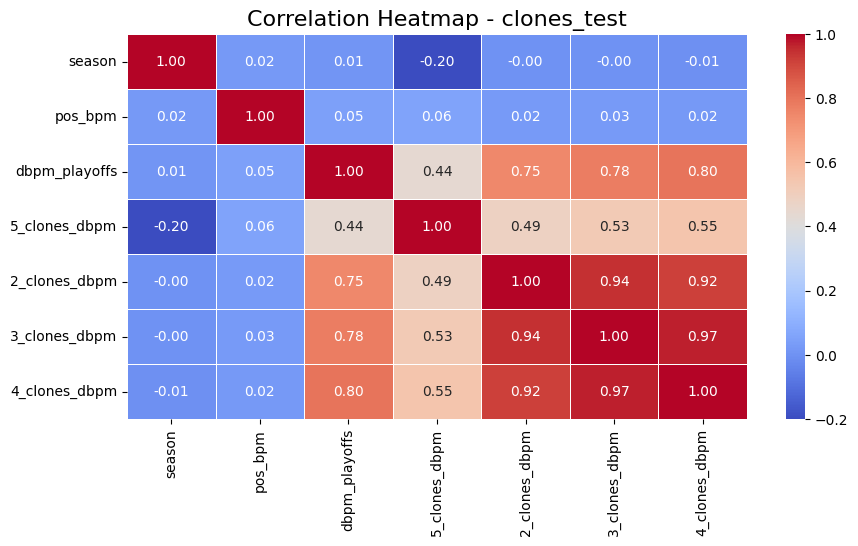

In [ ]:
# Mapa de correlación test
correlation_matrix = clones_test.corr(numeric_only=True)
plt.figure(figsize=(10, 5))
sbrn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap - clones_test', fontsize=16)
plt.show()

---
# 5.1. Predicciones DEF agregando "Clones"
---

In [ ]:
print(ext_defense.head(3)) # ext_def se está contaminando por aquí

           player  season  pos_bpm  gp   min  dreb_impact  \
0     Aaron McKie    1997        2  83 52.70         0.30   
1      Adam Keefe    1997        5  62 51.90         0.47   
2  Alan Henderson    1997        4  30 51.20         0.40   

   fouls_drawn_off_pbp  rimprot_impact  steal_impact  opp_adjustment  ...  \
0                 0.00            0.16          0.25            2.09  ...   
1                 0.00            0.13          0.10            2.16  ...   
2                 0.00            0.08          0.11            3.52  ...   

   opp ptsfb_def  opp ptspaint_def  blka_misc  pf_misc  pie_adv  \
0          10.70             34.40       1.20     4.20     9.50   
1          10.80             38.20       0.70     5.50     8.30   
2          15.90             47.90       1.60     7.50     7.50   

   dbpm_playoffs  adj_dreb_def  adj_drb%_bpm  adj_stl_def  def_ver  
0           3.80          9.84         21.93         4.07     0.71  
1           2.10         11.94         

In [ ]:
# Drop non-numeric columns and fill NaN values with 0
numeric_clones_df = ext_defense.drop(['player', 'season'], axis=1).fillna(0)

# Normalize the numerical columns
scaler = StandardScaler()
normalized_clones_df = scaler.fit_transform(numeric_clones_df)
pca = PCA(n_components=5)
pca_result = pca.fit_transform(normalized_clones_df)

# Calculate similarity and distance matrix
cosine_sim_matrix = cosine_similarity(normalized_clones_df)
pearson_corr_matrix = pd.DataFrame(normalized_clones_df.T).corr().to_numpy()
pca_eucdist_matrix = euclidean_distances(pca_result)
df_eucdist_matrix = euclidean_distances(normalized_clones_df)

In [ ]:
cosine_clones = ext_defense.copy()
cosine_clones = cosine_clones.apply(lambda row: get_dbpm_from_similarity_corrected(row, cosine_sim_matrix,
                                                                                   cosine_clones,
                                                                                   num_similar_players_list=[1, 2, 3, 4, 5]),
                                                                                   axis=1)

In [ ]:
cos_clones_train_features, cos_clones_test_features, cos_clones_train_target, cos_clones_test_target = train_test_split_def(cosine_clones, test_season=2023)

In [ ]:
pearson_clones = ext_defense.copy()
pearson_clones = pearson_clones.apply(lambda row: get_dbpm_from_similarity_corrected(row, pearson_corr_matrix,
                                                                           pearson_clones,
                                                                           num_similar_players_list=[1, 2, 3, 4, 5]), axis=1)

In [ ]:
pear_clones_train_features, pear_clones_test_features, pear_clones_train_target, pear_clones_test_target = train_test_split_def(pearson_clones, test_season=2023)

In [ ]:
pca_clones = ext_defense.copy()
pca_clones = pca_clones.apply(lambda row: get_dbpm_from_distance_corrected(row, pca_eucdist_matrix,
                                                                 pca_clones,
                                                                 num_similar_players_list=[1, 2, 3, 4, 5]), axis=1)

In [ ]:
pca_clones_train_features, pca_clones_test_features, pca_clones_train_target, pca_clones_test_target = train_test_split_def(pca_clones, test_season=2023)

In [ ]:
euclidean_clones = ext_defense.copy()
euclidean_clones = euclidean_clones.apply(lambda row: get_dbpm_from_distance_corrected(row, df_eucdist_matrix,
                                                                             euclidean_clones,
                                                                             num_similar_players_list=[1, 2, 3, 4, 5]), axis=1)

In [ ]:
euc_clones_train_features, euc_clones_test_features, euc_clones_train_target, euc_clones_test_target = train_test_split_def(euclidean_clones, test_season=2023)

In [ ]:
# Evaluación de modelos con dataset original para referencia

evaluate_models(def_train_features, def_train_target, def_test_features, def_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.2750284980069756
R-squared Score: 0.8984771800499567
Test Set:
Mean Squared Error: 2.131012753164557
R-squared Score: 0.15025333546308017

Linear Regression Model:
Training Set:
Mean Squared Error: 1.8001998634087981
R-squared Score: 0.33548207574362465
Test Set:
Mean Squared Error: 2.144416510630633
R-squared Score: 0.14490855365351762

Ridge Regression Model:
Training Set:
Mean Squared Error: 1.8002119046383398
R-squared Score: 0.33547763089668114
Test Set:
Mean Squared Error: 2.1365313950215152
R-squared Score: 0.14805276322166117


In [ ]:
# Evaluación de modelos con dataset CLONES COSINE DISTANCE

evaluate_models(cos_clones_train_features, cos_clones_train_target, cos_clones_test_features, cos_clones_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.14030674862979567
R-squared Score: 0.9482077788951258
Test Set:
Mean Squared Error: 1.0810239367088608
R-squared Score: 0.5689390018249268

Linear Regression Model:
Training Set:
Mean Squared Error: 1.060381988259407
R-squared Score: 0.6085752187411562
Test Set:
Mean Squared Error: 1.0430163236690588
R-squared Score: 0.584094632573556

Ridge Regression Model:
Training Set:
Mean Squared Error: 1.060786734743994
R-squared Score: 0.6084258123895312
Test Set:
Mean Squared Error: 1.044820113858554
R-squared Score: 0.5833753667245967


In [ ]:
# Evaluación de modelos con dataset CLONES PEARSON CORRELATION

evaluate_models(pear_clones_train_features, pear_clones_train_target, pear_clones_test_features, pear_clones_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.14525639013452915
R-squared Score: 0.9463806898227433
Test Set:
Mean Squared Error: 0.948938436708861
R-squared Score: 0.6216084252678489

Linear Regression Model:
Training Set:
Mean Squared Error: 1.0529341762692246
R-squared Score: 0.6113244715683372
Test Set:
Mean Squared Error: 0.9702117430342171
R-squared Score: 0.6131256411705697

Ridge Regression Model:
Training Set:
Mean Squared Error: 1.0534245721548485
R-squared Score: 0.6111434489704567
Test Set:
Mean Squared Error: 0.9718796875556209
R-squared Score: 0.6124605441214831


In [ ]:
# Evaluación de modelos con dataset CLONES DIST EUCLIDEANA EN PCA

evaluate_models(pca_clones_train_features, pca_clones_train_target, pca_clones_test_features, pca_clones_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.26685189412057797
R-squared Score: 0.9014954559383721
Test Set:
Mean Squared Error: 1.92981785443038
R-squared Score: 0.23048030447925694

Linear Regression Model:
Training Set:
Mean Squared Error: 1.7724371982118412
R-squared Score: 0.3457302648605667
Test Set:
Mean Squared Error: 2.003382816822033
R-squared Score: 0.20114609175516074

Ridge Regression Model:
Training Set:
Mean Squared Error: 1.7724648986950096
R-squared Score: 0.3457200396250525
Test Set:
Mean Squared Error: 2.001216593105913
R-squared Score: 0.20200987887923127


In [ ]:
# Evaluación de modelos con dataset CLONES DIST EUCLIDEANA

evaluate_models(euc_clones_train_features, euc_clones_train_target, euc_clones_test_features, euc_clones_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.14851893248629797
R-squared Score: 0.9451763691717625
Test Set:
Mean Squared Error: 0.8160416518987342
R-squared Score: 0.6746013505576609

Linear Regression Model:
Training Set:
Mean Squared Error: 0.9895114790818897
R-squared Score: 0.6347360493282995
Test Set:
Mean Squared Error: 0.8189204405322495
R-squared Score: 0.6734534263908047

Ridge Regression Model:
Training Set:
Mean Squared Error: 0.9895477651479707
R-squared Score: 0.6347226548481634
Test Set:
Mean Squared Error: 0.8203262682816437
R-squared Score: 0.6728928490600556


In [ ]:
euclidean_clones.tail(5)

,player,season,pos_bpm,gp,min,dreb_impact,fouls_drawn_off_pbp,rimprot_impact,steal_impact,opp_adjustment,...,dbpm_playoffs,adj_dreb_def,adj_drb%_bpm,adj_stl_def,def_ver,1_clones_dbpm,2_clones_dbpm,3_clones_dbpm,4_clones_dbpm,5_clones_dbpm
4167,Tyus Jones,2023,1,80,46.80,0.15,11.00,0.20,0.32,2.84,...,2.20,8.27,19.06,3.12,0.67,1.90,0.90,0.73,0.72,0.38
4168,Victor Oladipo,2023,2,42,49.00,0.25,13.00,0.15,0.49,2.41,...,-0.90,9.07,21.96,3.62,0.88,1.10,0.25,-0.57,-0.70,-0.72
4169,Wenyen Gabriel,2023,5,68,46.40,0.45,4.00,0.26,0.18,2.90,...,-0.30,11.77,26.86,2.32,0.89,1.50,1.80,1.30,0.70,0.66
4170,Wesley Matthews,2023,3,52,45.90,0.17,9.00,0.19,0.14,2.62,...,3.20,8.47,19.36,2.22,0.50,2.00,2.00,2.17,1.77,2.02
4171,Xavier Tillman Sr,2023,5,61,46.70,0.43,3.00,0.32,0.33,2.97,...,3.10,11.47,26.36,3.42,1.08,0.30,1.25,1.63,2.10,1.86


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(euc_clones_train_features, euc_clones_train_target)
rf_train_pred = rf_model.predict(euc_clones_train_features)
rf_test_pred = rf_model.predict(euc_clones_test_features)
rf_train_mse = mean_squared_error(euc_clones_train_target, rf_train_pred)
rf_train_r2 = r2_score(euc_clones_train_target, rf_train_pred)
rf_test_mse = mean_squared_error(euc_clones_test_target, rf_test_pred)
rf_test_r2 = r2_score(euc_clones_test_target, rf_test_pred)

print("Random Forest Model:")
print("Training Set:")
print(f"Mean Squared Error: {rf_train_mse}")
print(f"R-squared Score: {rf_train_r2}")
print("Test Set:")
print(f"Mean Squared Error: {rf_test_mse}")
print(f"R-squared Score: {rf_test_r2}")
print()

rf_model = RandomForestRegressor(n_estimators=500, random_state=970120)
rf_model.fit(euc_clones_train_features, euc_clones_train_target)
rf_train_pred = rf_model.predict(euc_clones_train_features)
rf_test_pred = rf_model.predict(euc_clones_test_features)
rf_train_mse = mean_squared_error(euc_clones_train_target, rf_train_pred)
rf_train_r2 = r2_score(euc_clones_train_target, rf_train_pred)
rf_test_mse = mean_squared_error(euc_clones_test_target, rf_test_pred)
rf_test_r2 = r2_score(euc_clones_test_target, rf_test_pred)

print("Random Forest Model:")
print("Training Set:")
print(f"Mean Squared Error: {rf_train_mse}")
print(f"R-squared Score: {rf_train_r2}")
print("Test Set:")
print(f"Mean Squared Error: {rf_test_mse}")
print(f"R-squared Score: {rf_test_r2}")
print()

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(euc_clones_train_features, euc_clones_train_target)
rf_train_pred = rf_model.predict(euc_clones_train_features)
rf_test_pred = rf_model.predict(euc_clones_test_features)
rf_train_mse = mean_squared_error(euc_clones_train_target, rf_train_pred)
rf_train_r2 = r2_score(euc_clones_train_target, rf_train_pred)
rf_test_mse = mean_squared_error(euc_clones_test_target, rf_test_pred)
rf_test_r2 = r2_score(euc_clones_test_target, rf_test_pred)

print("Random Forest Model:")
print("Training Set:")
print(f"Mean Squared Error: {rf_train_mse}")
print(f"R-squared Score: {rf_train_r2}")
print("Test Set:")
print(f"Mean Squared Error: {rf_test_mse}")
print(f"R-squared Score: {rf_test_r2}")
print()

Random Forest Model:
Training Set:
Mean Squared Error: 0.14915572097658197
R-squared Score: 0.9449413078464314
Test Set:
Mean Squared Error: 0.804328170886076
R-squared Score: 0.6792721304043989

Random Forest Model:
Training Set:
Mean Squared Error: 0.14270368706527148
R-squared Score: 0.9473229834976322
Test Set:
Mean Squared Error: 0.8099564924050635
R-squared Score: 0.6770278231234601

Random Forest Model:
Training Set:
Mean Squared Error: 0.14429832044095664
R-squared Score: 0.946734347489876
Test Set:
Mean Squared Error: 0.824198102848101
R-squared Score: 0.6713489453440408



---
# 6. Adición de arquetipos y percentiles DEF
---

In [ ]:
# Unión de dataframes para contar con ARQ DEF

print(ext_defense.shape)
ext_def_arch = pd.merge(ext_defense, def_arch, on=['player', 'season'])
print(ext_def_arch.shape)

(4172, 37)
(4172, 38)


In [ ]:
print(ext_def_arch.head(3))

           player  season  pos_bpm  gp   min  dreb_impact  \
0     Aaron McKie    1997        2  83 52.70         0.30   
1      Adam Keefe    1997        5  62 51.90         0.47   
2  Alan Henderson    1997        4  30 51.20         0.40   

   fouls_drawn_off_pbp  rimprot_impact  steal_impact  opp_adjustment  ...  \
0                 0.00            0.16          0.25            2.09  ...   
1                 0.00            0.13          0.10            2.16  ...   
2                 0.00            0.08          0.11            3.52  ...   

   opp ptspaint_def  blka_misc  pf_misc  pie_adv  dbpm_playoffs  adj_dreb_def  \
0             34.40       1.20     4.20     9.50           3.80          9.84   
1             38.20       0.70     5.50     8.30           2.10         11.94   
2             47.90       1.60     7.50     7.50           1.60         11.04   

   adj_drb%_bpm  adj_stl_def  def_ver  def_arch  
0         21.93         4.07     0.71         5  
1         26.93      

In [ ]:
def calculate_percentiles(dataframe, archetype_column='def_arch', percentile_list=[10, 25, 50, 75, 95], column_name='dbpm_playoffs', exclude_season=None):
    # Exclude the specified season if provided
    if exclude_season is not None:
        dataframe = dataframe[dataframe['season'] != exclude_season]

    # Group the data by defensive archetype
    grouped_data = dataframe.groupby(archetype_column)[column_name]

    # Calculate percentiles for each defensive archetype
    percentiles_data = grouped_data.describe(percentiles=[p / 100 for p in percentile_list])

    # Extract the relevant percentiles and reset index for a cleaner structure
    percentiles_data = percentiles_data[['{:.0%}'.format(p / 100) for p in percentile_list]].reset_index()

    return percentiles_data

In [ ]:
def add_percentile_columns(original_df, percentiles_df, archetype_column='def_arch', percentile_columns=['10%', '25%', '50%', '75%', '95%']):
    # Merge the original DataFrame with the calculated percentiles on 'def_arch'
    merged_data = pd.merge(original_df, percentiles_df, on=archetype_column, how='left')

    # Create new columns for each percentile
    for percentile in percentile_columns:
        new_column_name = f'{archetype_column}_{percentile}_per'
        merged_data[new_column_name] = merged_data[percentile]

    # Drop the redundant percentile columns from the merged DataFrame
    merged_data.drop(columns=percentile_columns, inplace=True)

    return merged_data

In [ ]:
test_per_df = ext_def_arch[['player', 'season', 'dbpm_playoffs', 'def_arch']]

In [ ]:
filtered_per_result = calculate_previous_season_percentiles(test_per_df, column_name='dbpm_playoffs')

In [ ]:
percentiles_result = calculate_percentiles(test_per_df, column_name='dbpm_playoffs')
filtered_per_result = calculate_percentiles(test_per_df, column_name='dbpm_playoffs', exclude_season=2023)

In [ ]:
print(percentiles_result)
print('')
print(filtered_per_result)

   def_arch   10%   25%   50%  75%  95%
0         0 -2.10 -1.12 -0.40 0.70 2.30
1         1 -2.40 -1.50 -0.60 0.30 1.90
2         2 -1.90 -1.00 -0.10 1.10 2.80
3         3 -1.40 -0.60  0.70 1.70 3.15
4         4 -1.40 -0.50  0.40 1.30 2.80
5         5 -1.40 -0.50  0.40 1.30 2.70
6         6 -1.06 -0.20  0.80 1.70 3.30
7         7 -0.60  0.20  1.00 1.90 3.40
8         8 -0.70  0.20  1.40 2.50 4.20
9         9 -0.60  0.50  1.50 2.70 3.99

   def_arch   10%   25%   50%  75%  95%
0         0 -2.10 -1.30 -0.50 0.60 2.10
1         1 -2.40 -1.50 -0.60 0.30 1.90
2         2 -1.90 -1.00 -0.10 1.10 2.80
3         3 -1.50 -0.67  0.50 1.50 2.77
4         4 -1.40 -0.60  0.40 1.30 2.80
5         5 -1.40 -0.50  0.40 1.30 2.70
6         6 -1.07 -0.23  0.80 1.70 3.30
7         7 -0.60  0.20  1.00 1.90 3.40
8         8 -0.70  0.20  1.40 2.50 4.20
9         9 -0.60  0.50  1.50 2.70 4.06


In [ ]:
result_df = add_percentile_columns(test_per_df, filtered_per_result)

In [ ]:
result_df.head(3)

,player,season,dbpm_playoffs,def_arch,def_arch_10%_per,def_arch_25%_per,def_arch_50%_per,def_arch_75%_per,def_arch_95%_per
0,Aaron McKie,1997,3.80,5,-1.40,-0.50,0.40,1.30,2.70
1,Adam Keefe,1997,2.10,5,-1.40,-0.50,0.40,1.30,2.70
2,Alan Henderson,1997,1.60,0,-2.10,-1.15,-0.40,0.70,2.21


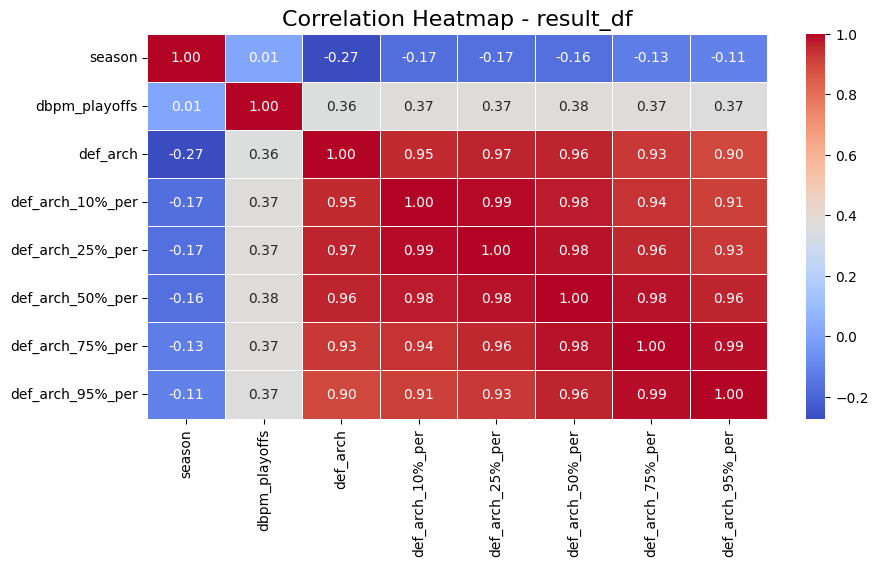

In [ ]:
# Mapa de correlación test
correlation_matrix = result_df.corr(numeric_only=True)
plt.figure(figsize=(10, 5))
sbrn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap - result_df', fontsize=16)
plt.show()

---
# 6.1. Predicciones DEF agregando ARQ DEFENSIVOS
---

In [ ]:
per_res_def = calculate_percentiles(ext_def_arch, column_name='dbpm_playoffs', exclude_season=2023)

In [ ]:
ext_def_arch = add_percentile_columns(ext_def_arch, per_res_def)

In [ ]:
ext_def_arch.head(3)

,player,season,pos_bpm,gp,min,dreb_impact,fouls_drawn_off_pbp,rimprot_impact,steal_impact,opp_adjustment,...,adj_dreb_def,adj_drb%_bpm,adj_stl_def,def_ver,def_arch,def_arch_10%_per,def_arch_25%_per,def_arch_50%_per,def_arch_75%_per,def_arch_95%_per
0,Aaron McKie,1997,2,83,52.70,0.30,0.00,0.16,0.25,2.09,...,9.84,21.93,4.07,0.71,5,-1.40,-0.50,0.40,1.30,2.70
1,Adam Keefe,1997,5,62,51.90,0.47,0.00,0.13,0.10,2.16,...,11.94,26.93,3.27,0.71,5,-1.40,-0.50,0.40,1.30,2.70
2,Alan Henderson,1997,4,30,51.20,0.40,0.00,0.08,0.11,3.52,...,11.04,24.83,3.77,0.59,0,-2.10,-1.30,-0.50,0.60,2.10


In [ ]:
arch_train_features, arch_test_features, arch_train_target, arch_test_target = train_test_split_def(ext_def_arch, test_season=2023)

In [ ]:
# Evaluación de modelos con dataset original para referencia

evaluate_models(def_train_features, def_train_target, def_test_features, def_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.2750284980069756
R-squared Score: 0.8984771800499567
Test Set:
Mean Squared Error: 2.131012753164557
R-squared Score: 0.15025333546308017

Linear Regression Model:
Training Set:
Mean Squared Error: 1.8001998634087981
R-squared Score: 0.33548207574362465
Test Set:
Mean Squared Error: 2.144416510630633
R-squared Score: 0.14490855365351762

Ridge Regression Model:
Training Set:
Mean Squared Error: 1.8002119046383398
R-squared Score: 0.33547763089668114
Test Set:
Mean Squared Error: 2.1365313950215152
R-squared Score: 0.14805276322166117


In [ ]:
# Evaluación de modelos con ARQUETIPOS Y PERCENTILES

evaluate_models(arch_train_features, arch_train_target, arch_test_features, arch_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.27542414823119077
R-squared Score: 0.898331131452203
Test Set:
Mean Squared Error: 2.1144478860759492
R-squared Score: 0.1568586176398945

Linear Regression Model:
Training Set:
Mean Squared Error: 1.7956322104049158
R-squared Score: 0.3371681592472173
Test Set:
Mean Squared Error: 2.11764904124269
R-squared Score: 0.15558214901174416

Ridge Regression Model:
Training Set:
Mean Squared Error: 1.7962419133042125
R-squared Score: 0.33694309617878293
Test Set:
Mean Squared Error: 2.1181334186070218
R-squared Score: 0.1553890023263914


---
# 7. Predicciones con dataframes combinados DEFENSA
---

In [ ]:
# Listado de dataframes
"""
mean_filled_def_past_seasons
rolling_def_df
cosine_clones
ext_def_arch
"""

'\nmean_filled_def_past_seasons\nrolling_def_df\ncosine_clones\next_def_arch\n'

In [ ]:
# List of dataframes

dataframes_list = [mean_filled_def_past_seasons,
                   rolling_def_df,
                   cosine_clones,
                   ext_def_arch]

In [ ]:
# Define the columns on which you want to merge
merge_columns = ['player', 'season']

# Use the reduce function to iteratively merge the dataframes
merged_dataframe = reduce(lambda left, right: pd.merge(left, right, on=merge_columns, suffixes=('', '_drop')), dataframes_list)

# Drop columns with the suffix '_drop'
merged_dataframe = merged_dataframe.loc[:,~merged_dataframe.columns.str.endswith('_drop')]

In [ ]:
print(merged_dataframe.head(3))

           player  season  pos_bpm  gp   min  dreb_impact  \
0     Aaron McKie    1997        2  83 52.70         0.30   
1      Adam Keefe    1997        5  62 51.90         0.47   
2  Alan Henderson    1997        4  30 51.20         0.40   

   fouls_drawn_off_pbp  rimprot_impact  steal_impact  opp_adjustment  ...  \
0                 0.00            0.16          0.25            2.09  ...   
1                 0.00            0.13          0.10            2.16  ...   
2                 0.00            0.08          0.11            3.52  ...   

   2_clones_dbpm  3_clones_dbpm  4_clones_dbpm  5_clones_dbpm  def_arch  \
0           3.70           3.37           3.48           3.28        11   
1           1.45           0.70           1.18           1.46        11   
2           0.35           0.50           0.45           0.40         3   

   def_arch_10%_per  def_arch_25%_per  def_arch_50%_per  def_arch_75%_per  \
0             -0.90              0.00              0.80             

In [ ]:
# Split de train y test:

merged_train_features, merged_test_features, merged_train_target, merged_test_target = train_test_split_def(merged_dataframe, test_season=2023)

In [ ]:
# Evaluación de modelos con dataset original para referencia

evaluate_models(def_train_features, def_train_target, def_test_features, def_test_target)

Random Forest Model:
Mean Squared Error: 2.131012753164557
R-squared Score: 0.15025333546308017

Linear Regression Model:
Mean Squared Error: 2.144416510630633
R-squared Score: 0.14490855365351762

Ridge Regression Model:
Mean Squared Error: 2.1365313950215152
R-squared Score: 0.14805276322166117


In [ ]:
# Evaluación de modelos con dataset combinado

evaluate_models(merged_train_features, merged_train_target, merged_test_features, merged_test_target)

Random Forest Model:
Mean Squared Error: 0.9105225696202532
R-squared Score: 0.6369268483393964

Linear Regression Model:
Mean Squared Error: 0.9078389526272327
R-squared Score: 0.6379969473265223

Ridge Regression Model:
Mean Squared Error: 0.9047041979384562
R-squared Score: 0.6392469385980311


In [ ]:
# Construcción e iniciación del modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamiento del modelo
rf_model.fit(merged_train_features, merged_train_target)

# Predicciones
def_rf_merged_pred = rf_model.predict(merged_test_features)

In [ ]:
comparison_df_def['rf_97_merged'] = def_rf_merged_pred

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(comparison_df_def, x='dbpm_playoffs', y='rf_97_merged', color='dbpm_playoffs', color_continuous_scale='portland',
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs',
                  xaxis_title='DBPM Postemporada',
                  yaxis_title='DBPM Predicciones R-Forest',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-6, y0=-6, x1=5, y1=5)

# Show the interactive plot
fig.show()

In [ ]:
# Get feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(merged_train_features.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

5_clones_dbpm: 0.522097642983956
4_clones_dbpm: 0.16065006100941545
1_seas_past_dbpm_playoffs: 0.01475044549622228
2_seas_past_dbpm_playoffs: 0.014353545469179925
dbpm_bpm: 0.012162335332337692
3_seas_past_dbpm_playoffs: 0.011295690833148003
steal_impact: 0.010977630449227227
5_seas_past_dbpm_playoffs: 0.01040816702757877
mp_bpm: 0.010066489269849273
4_seas_past_dbpm_playoffs: 0.009512661004966515
def_ver: 0.009370228724887198
2_clones_dbpm: 0.008857076959174329
opp_adjustment: 0.008456928811711454
3_clones_dbpm: 0.00840893516039852
rimprot_impact: 0.008294699229230746
1_clones_dbpm: 0.008254576150487592
bpm_bpm: 0.007999864434873953
def rtg_def: 0.00785824448632487
opp ptsfb_def: 0.007835369063259223
+/-_on-off_pbp: 0.007831985587567513
stl%_def: 0.007725462431095742
opp pts2nd chance_def: 0.007634902014855058
fouls_committed_shoot_pbp: 0.007606347179753746
min: 0.0075946655222207445
pf_misc: 0.0075335148343391445
opp ptspaint_def: 0.007486204806610033
adj_stl_def: 0.00744926060011746

In [ ]:
common_column = 'player'

# Merge the dataframes using the indicator parameter
merged_df = pd.merge(ext_def_test, ext_def_train, on=common_column, how='outer', indicator=True)

# Select rows that are only in ext_def_test
missing_players = merged_df[merged_df['_merge'] == 'left_only'][common_column]

# Convert the result to a list if needed
missing_players_list = missing_players.tolist()

# Print or use the list as needed
print("Players present in ext_def_test but not in ext_def_train:", missing_players_list[0:5])

merged_test_df = merged_test_features.copy()
merged_test_df['player'] = ext_def_test['player']

first_playoff_df = merged_test_df[merged_test_df['player'].isin(missing_players_list)]

Players present in ext_def_test but not in ext_def_train: ['Austin Reaves', 'Christian Braun', 'Darius Garland', 'David Roddy', 'Davion Mitchell']


---
# 8. Predicciones OFF DESDE 1997 y 2014 con RANDOM FOREST, REG LINEAL y RIDGE
---

In [7]:
print(ext_offense.shape)
print('')
print(offense.shape)

(1532, 137)



NameError: name 'offense' is not defined

In [51]:
# Split de train y test:

ext_offense_train_features, ext_offense_test_features, ext_offense_train_target, ext_offense_test_target = train_test_split_off(ext_offense, test_season=2023)

In [42]:
# Evaluación de modelos con dataset original para referencia

evaluate_models(ext_offense_train_features, ext_offense_train_target, ext_offense_test_features, ext_offense_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.8945033070809248
R-squared Score: 0.9123870213852482
Test Set:
Mean Squared Error: 6.1150952297297305
R-squared Score: 0.352575564104205

Linear Regression Model:
Training Set:
Mean Squared Error: 5.344999444036102
R-squared Score: 0.4764789372166852
Test Set:
Mean Squared Error: 6.140711553448943
R-squared Score: 0.34986348304731385

Ridge Regression Model:
Training Set:
Mean Squared Error: 5.364659772252851
R-squared Score: 0.47455328763889426
Test Set:
Mean Squared Error: 6.118997005245005
R-squared Score: 0.3521624708134108


In [36]:
ext_offense = ext_offense.drop(['team', 'obpm_regseas.1', 'Unnamed: 0'], axis=1)

In [40]:
ext_offense = ext_offense.apply(pd.to_numeric, errors='coerce')
ext_offense = ext_offense.fillna(0)

In [ ]:
# Split de train y test:

offense_train_features, offense_test_features, offense_train_target, offense_test_target = train_test_split_off(offense, test_season=2023)

In [ ]:
# Evaluación de modelos con dataset original para referencia

evaluate_models(offense_train_features, offense_train_target, offense_test_features, offense_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.8945033070809248
R-squared Score: 0.9123870213852482
Test Set:
Mean Squared Error: 6.1150952297297305
R-squared Score: 0.352575564104205

Linear Regression Model:
Training Set:
Mean Squared Error: 5.344999444036102
R-squared Score: 0.4764789372166852
Test Set:
Mean Squared Error: 6.140711553448943
R-squared Score: 0.34986348304731385

Ridge Regression Model:
Training Set:
Mean Squared Error: 5.364659772252851
R-squared Score: 0.47455328763889426
Test Set:
Mean Squared Error: 6.118997005245005
R-squared Score: 0.3521624708134108


In [43]:
# Split de train y test dejando solo la última temporada como test

ext_off_test = ext_offense[ext_offense['season'] == 2023]
ext_off_train = ext_offense[ext_offense['season'] != 2023]

In [44]:
comparison_df_off = ext_off_test

In [45]:
# Construcción e iniciación del modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamiento del modelo
rf_model.fit(ext_offense_train_features, ext_offense_train_target)

# Predicciones
ext_def_rf_pred = rf_model.predict(ext_offense_test_features)

# Evaluación del modelo
mse = mean_squared_error(ext_offense_test_target, ext_def_rf_pred)
r2 = r2_score(ext_offense_test_target, ext_def_rf_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

###
# Mean Squared Error: 2.1620944556962023
# R-squared Score: 0.13785942884981706
###

Mean Squared Error: 6.1150952297297305
R-squared Score: 0.352575564104205


In [46]:
# Get feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(ext_offense_train_features.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

obpm_regseas: 0.3787830052625896
vorp_regseas: 0.023141992039292056
pie_adv: 0.022610693560225624
mr_fg%_shootingzone: 0.010309083554931653
+/-_trad: 0.009786839159230027
ft%_trad: 0.009772720045904366
offrtg_adv: 0.009598093583610879
painttouch fg%_shooting_eff: 0.009127644717210231
pace_adv: 0.00908587560306914
fg%_drives: 0.008427824761525208
min: 0.008213630503132513
avg speed off_speed: 0.00807254056543036
elbowtouch fg%_shooting_eff: 0.008018924350980802
ts%_adv: 0.007976670878617882
pass%_drives: 0.00795007185839103
2ndpts_misc: 0.007940784974902653
poss_adv: 0.007738970450267706
%ptsfbps_scoring: 0.007610240936769018
%ptsoffto_scoring: 0.007289542716770898
%ptsft_scoring: 0.007281308798759522
paint_fg%_shootingzone: 0.007251133922804921
fg%_trad: 0.007241064064444518
ast%_drives: 0.007198583628534677
pf%_drives: 0.007085672839429422
tov_trad: 0.007026666026586092
elbowtouch pts_shooting_eff: 0.006943774465226645
ra_fg%_shootingzone: 0.006920326556155321
rc3_fg%_shootingzone: 0.

In [47]:
# Construcción e iniciación del modelo
linreg_model = LinearRegression()

# Entrenamiento del modelo
linreg_model.fit(ext_offense_train_features, ext_offense_train_target)


# Predicciones
ext_def_lm_pred = linreg_model.predict(ext_offense_test_features)

# Evaluación del modelo
mse = mean_squared_error(ext_offense_test_target, ext_def_lm_pred)
r2 = r2_score(ext_offense_test_target, ext_def_lm_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

###
# Mean Squared Error: 2.019232449793044
# R-squared Score: 0.19482601097138752
###

Mean Squared Error: 6.140711553448943
R-squared Score: 0.34986348304731385


In [48]:
# Get feature importances from the trained model
feature_importances = linreg_model.coef_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(ext_offense_train_features.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

pts_pullup: 2.655666112468802
secondaryast_passing: 2.4948218927023667
fta_drives: 2.293178712316491
c3_fga_shootingzone: 1.6998258839577518
rc3_fgm_shootingzone: 1.3699600273735257
pts_catch&shoot: 1.3541116642624724
ab3_fgm_shootingzone: 1.295548936469261
fgm_drives: 1.2588965870427589
3pm_pullup: 1.139779502345029
lc3_fgm_shootingzone: 1.0151321814708438
fgm_pullup: 0.944778029746195
lc3_fga_shootingzone: 0.9435123852587567
obpm_regseas: 0.8098653245264388
ast ptscreated_passing: 0.751111332938396
fgm%ast_scoring: 0.7480684001520811
fgm%uast_scoring: 0.7174745425861739
oreb_oreb: 0.6547157888843721
ast_drives: 0.5237639732863635
mr_fgm_shootingzone: 0.519373335234818
fga_trad: 0.5057278420119653
pitp_misc: 0.44532270263504065
elbowtouch pts_shooting_eff: 0.40284163723286115
fbps_misc: 0.36616024716194523
tov_trad: 0.3522382352832285
oreb%_adv: 0.3113630597884563
%pts2pt mr_scoring: 0.26571729337675465
vorp_regseas: 0.2237575078545948
%ptspitp_scoring: 0.2154356713702865
posttouch pt

In [53]:
# Construcción e iniciación del modelo
ridge_model = Ridge(random_state=42, max_iter=10000)

# Entrenamiento del modelo
ridge_model.fit(ext_offense_train_features, ext_offense_train_target)


# Predicciones
ext_def_ridge_pred = ridge_model.predict(ext_offense_test_features)

# Evaluación del modelo
mse = mean_squared_error(ext_offense_test_target, ext_def_ridge_pred)
r2 = r2_score(ext_offense_test_target, ext_def_ridge_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

###
# Mean Squared Error: 2.272649548679285
# R-squared Score: 0.007540803988347666
###

Mean Squared Error: 6.790243641917818
R-squared Score: 0.40299585941142524


In [55]:
# Get feature importances from the trained model
feature_importances = ridge_model.coef_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(ext_offense_train_features.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

fg%_0-3_shoot: 2.3093976076222744
%_fga_by_distance_16-3p_shoot: 2.1509411804733283
obpm_bpm: 0.9553194570163601
onball_mr_shoot: 0.6450709894093111
fga_trad: 0.5836444591165683
scoring_impact: 0.5069952619202797
fta_trad: 0.47538617877970346
ast_trad: 0.4109959001980232
vorp_bpm: 0.3379765725086035
fg%_3-10_shoot: 0.3362964328517099
c3_fga_szone: 0.27269984843151657
fgm_trad: 0.236613617197019
2fgm%ast_scor: 0.22478257446552383
3pshoot_impact: 0.21085921844004368
paint_fga_szone: 0.20625944725946102
2fgm%uast_scor: 0.1969965837048084
c3_fga.1_szone: 0.148790002587071
ra_fga_szone: 0.1311638056473038
fbps_misc: 0.12197746595567611
tov_trad: 0.11059822941020037
to ratio_adv: 0.10301833161053162
pitp_misc: 0.10216155713034494
%ptsoffto_scor: 0.09921509305192895
oreb%_adv: 0.09505856221227467
ab3_fga_szone: 0.08849549284008669
off_load: 0.08621609958106101
ab3_fgm_szone: 0.07663296657931135
pass_impact: 0.06976754878094647
mr_fgm_szone: 0.06563877190290414
min: 0.05094576804832687
ows_bpm

---
# 9. Cálculos de desempeño OBPM playoffs pasados
---

In [ ]:
print(ext_offense.head(3))

           player  season  pos_bpm  gp   min  scoring_impact  rim_pressure  \
0     Aaron McKie    1997        2  83 19.60           14.17          0.11   
1      Adam Keefe    1997        5  62 14.80           14.92          0.13   
2  Alan Henderson    1997        4  30 16.60           17.15          0.23   

   offball_2pshoot  offball_3pshoot  onball_3pshoot  ...  +/-_trad  \
0             0.25             1.67            0.08  ...      4.30   
1             0.45             0.00            0.00  ...      6.90   
2             0.58             0.00            0.00  ...     -8.20   

   adj_ts%_adv  adj_ra_fg%_szone  adj_fg%_2p_shoot  adj_3p%_trad  \
0        68.35             93.46              0.71         65.40   
1        73.15             95.06              0.81         25.60   
2        66.95             98.96              0.77         25.60   

   adj_ab3_fgm_szone  adj_mr_fga_szone  adj_mr_fg%_szone  adj_oreb_trad  \
0               0.32              4.86             74.46  

In [ ]:
df_past_seasons_off = add_past_playoff_performances(ext_offense, performance_column='obpm_playoffs')

In [ ]:
kawhi_df = df_past_seasons_off[(df_past_seasons_off['player'] == 'Anthony Edwards') | \
                               (df_past_seasons_off['player'] == 'Austin Reaves') | \
                               (df_past_seasons_off['player'] == 'Jalen Brunson') | \
                               (df_past_seasons_off['player'] == 'Donovan Mitchell')]

In [ ]:
keep_col_kawhi = ['player', 'season', 'pos_bpm', 'obpm_bpm', 'obpm_playoffs', '1_seas_past_obpm_playoffs', '2_seas_past_obpm_playoffs',
                   '3_seas_past_obpm_playoffs', '4_seas_past_obpm_playoffs', '5_seas_past_obpm_playoffs']

kawhi_df = kawhi_df[keep_col_kawhi]

In [ ]:
kawhi_df.sort_values(by=['player', 'season'])

,player,season,pos_bpm,obpm_bpm,obpm_playoffs,1_seas_past_obpm_playoffs,2_seas_past_obpm_playoffs,3_seas_past_obpm_playoffs,4_seas_past_obpm_playoffs,5_seas_past_obpm_playoffs
3856,Anthony Edwards,2022,2,1.60,3.20,NaN,NaN,NaN,NaN,NaN
4019,Anthony Edwards,2023,2,1.00,7.30,3.20,NaN,NaN,NaN,NaN
4020,Austin Reaves,2023,2,0.60,2.00,NaN,NaN,NaN,NaN,NaN
3239,Donovan Mitchell,2018,2,0.90,1.10,NaN,NaN,NaN,NaN,NaN
3404,Donovan Mitchell,2019,2,1.20,-3.30,1.10,NaN,NaN,NaN,NaN
3557,Donovan Mitchell,2020,2,2.40,9.30,-3.30,1.10,NaN,NaN,NaN
3729,Donovan Mitchell,2021,1,4.60,8.20,9.30,-3.30,1.10,NaN,NaN
3898,Donovan Mitchell,2022,2,4.60,3.90,8.20,9.30,-3.30,1.10,NaN
4056,Donovan Mitchell,2023,2,5.60,2.70,3.90,8.20,9.30,-3.30,1.10
3754,Jalen Brunson,2021,1,1.50,2.20,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Applying the custom filling logic
df_filled_custom = fill_na_values_custom_off(kawhi_df)

# Displaying a part of the resulting dataframe to check the implementation
df_filled_custom

,player,season,pos_bpm,obpm_bpm,obpm_playoffs,1_seas_past_obpm_playoffs,2_seas_past_obpm_playoffs,3_seas_past_obpm_playoffs,4_seas_past_obpm_playoffs,5_seas_past_obpm_playoffs
0,Donovan Mitchell,2018,2,0.90,1.10,0.90,0.90,0.90,0.90,0.90
1,Donovan Mitchell,2019,2,1.20,-3.30,1.10,1.20,1.20,1.20,1.20
2,Donovan Mitchell,2020,2,2.40,9.30,-3.30,1.10,2.70,2.70,2.70
3,Donovan Mitchell,2021,1,4.60,8.20,9.30,-3.30,1.10,5.35,5.35
4,Donovan Mitchell,2022,2,4.60,3.90,8.20,9.30,-3.30,1.10,5.83
5,Donovan Mitchell,2023,2,5.60,2.70,3.90,8.20,9.30,-3.30,1.10
6,Jalen Brunson,2021,1,1.50,2.20,1.50,1.50,1.50,1.50,1.50
7,Jalen Brunson,2022,2,0.90,2.00,2.20,0.90,0.90,0.90,0.90
8,Jalen Brunson,2023,1,4.40,6.10,2.00,2.20,3.80,3.80,3.80
9,Anthony Edwards,2022,2,1.60,3.20,1.60,1.60,1.60,1.60,1.60


In [ ]:
mean_filled_off_past_seasons = fill_na_values_custom_off(df_past_seasons_off)

---
## 9.1. Playoffs pasados con rolling
---

In [ ]:
keep_col_roll_off = ['player', 'season', 'pos_bpm', 'obpm_bpm', 'obpm_playoffs']

mean_filled_df_off = ext_offense[keep_col_roll_off]

In [ ]:
result_df_off = calculate_rolling_off_dynamic(mean_filled_df_off, rolling_years_list=[2, 3, 4, 5])

In [ ]:
kawhi_mean_filled = result_df_off[(result_df_off['player'] == 'Anthony Edwards') | \
                                  (result_df_off['player'] == 'Austin Reaves') | \
                                  (result_df_off['player'] == 'Jalen Brunson') | \
                                  (result_df_off['player'] == 'Donovan Mitchell')]

In [ ]:
kawhi_mean_filled.sort_values(by=['player', 'season'])

,player,season,pos_bpm,obpm_bpm,obpm_playoffs,2_yr_rolling_avg_obpm_playoffs,3_yr_rolling_avg_obpm_playoffs,4_yr_rolling_avg_obpm_playoffs,5_yr_rolling_avg_obpm_playoffs
3856,Anthony Edwards,2022,2,1.60,3.20,1.60,1.60,1.60,1.60
4019,Anthony Edwards,2023,2,1.00,7.30,3.20,3.20,3.20,3.20
4020,Austin Reaves,2023,2,0.60,2.00,0.60,0.60,0.60,0.60
3239,Donovan Mitchell,2018,2,0.90,1.10,0.90,0.90,0.90,0.90
3404,Donovan Mitchell,2019,2,1.20,-3.30,1.10,1.10,1.10,1.10
3557,Donovan Mitchell,2020,2,2.40,9.30,-1.10,-1.10,-1.10,-1.10
3729,Donovan Mitchell,2021,1,4.60,8.20,3.00,2.37,2.37,2.37
3898,Donovan Mitchell,2022,2,4.60,3.90,8.75,4.73,3.83,3.83
4056,Donovan Mitchell,2023,2,5.60,2.70,6.05,7.13,4.52,3.84
3754,Jalen Brunson,2021,1,1.50,2.20,1.50,1.50,1.50,1.50


In [ ]:
rolling_off_df = calculate_rolling_off_dynamic(ext_offense, rolling_years_list=[2, 3, 4, 5])

In [ ]:
rolling_off_df.head(5)

,player,season,pos_bpm,gp,min,scoring_impact,rim_pressure,offball_2pshoot,offball_3pshoot,onball_3pshoot,...,adj_3p%_trad,adj_ab3_fgm_szone,adj_mr_fga_szone,adj_mr_fg%_szone,adj_oreb_trad,scor_ver,2_yr_rolling_avg_obpm_playoffs,3_yr_rolling_avg_obpm_playoffs,4_yr_rolling_avg_obpm_playoffs,5_yr_rolling_avg_obpm_playoffs
0,Aaron McKie,1997,2,83,19.60,14.17,0.11,0.25,1.67,0.08,...,65.40,0.32,4.86,74.46,3.99,0.68,-1.10,-1.10,-1.10,-1.10
1,Adam Keefe,1997,5,62,14.80,14.92,0.13,0.45,0.00,0.00,...,25.60,0.22,3.56,79.86,6.89,0.61,-1.30,-1.30,-1.30,-1.30
2,Alan Henderson,1997,4,30,16.60,17.15,0.23,0.58,0.00,0.00,...,25.60,0.22,4.36,63.76,7.49,0.84,-2.30,-2.30,-2.30,-2.30
3,Allan Houston,1997,2,81,33.10,19.22,0.20,0.41,2.40,0.67,...,64.10,0.72,10.26,80.66,3.49,1.40,-0.60,-0.60,-0.60,-0.60
4,Alonzo Mourning,1997,5,66,35.20,24.83,0.57,0.73,0.11,0.00,...,36.70,0.22,6.66,81.36,7.09,1.48,0.50,0.50,0.50,0.50


---
# 9.1. Predicciones OFF agregando Playoffs pasados
---

In [ ]:
# Evaluación de modelos con dataset original para referencia

evaluate_models(ext_offense_train_features, ext_offense_train_target, ext_offense_test_features, ext_offense_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.9334783428001991
R-squared Score: 0.9162898065728724
Test Set:
Mean Squared Error: 7.221039848101267
R-squared Score: 0.36511988140473206

Linear Regression Model:
Training Set:
Mean Squared Error: 6.2203749579997805
R-squared Score: 0.4421843903079449
Test Set:
Mean Squared Error: 7.068390670651292
R-squared Score: 0.3785409301624665

Ridge Regression Model:
Training Set:
Mean Squared Error: 6.2352727377266
R-squared Score: 0.440848423563579
Test Set:
Mean Squared Error: 6.790243641917818
R-squared Score: 0.40299585941142524


In [ ]:
off_pastseas_train_features, off_pastseas_test_features, off_pastseas_train_target, off_pastseas_test_target = train_test_split_off(mean_filled_off_past_seasons, test_season=2023)

In [ ]:
# Evaluación de modelos con dataset PAST PLAYOFFS DBPM

evaluate_models(off_pastseas_train_features, off_pastseas_train_target, off_pastseas_test_features, off_pastseas_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.9323028931240657
R-squared Score: 0.916395215681195
Test Set:
Mean Squared Error: 7.193611582278482
R-squared Score: 0.3675313984472548

Linear Regression Model:
Training Set:
Mean Squared Error: 6.211586769290169
R-squared Score: 0.44297247605458234
Test Set:
Mean Squared Error: 7.060259524995048
R-squared Score: 0.3792558275771246

Ridge Regression Model:
Training Set:
Mean Squared Error: 6.2270991885091815
R-squared Score: 0.4415813911693659
Test Set:
Mean Squared Error: 6.754232156873212
R-squared Score: 0.4061620205706


In [ ]:
off_rolling_train_features, off_rolling_test_features, off_rolling_train_target, off_rolling_test_target = train_test_split_off(rolling_off_df, test_season=2023)

In [ ]:
# Evaluación de modelos con dataset PLAYOFFS ROLLING AVERAGE

evaluate_models(off_rolling_train_features, off_rolling_train_target, off_rolling_test_features, off_rolling_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.9399254598903837
R-squared Score: 0.915711657735431
Test Set:
Mean Squared Error: 7.236611348101267
R-squared Score: 0.36375082154982674

Linear Regression Model:
Training Set:
Mean Squared Error: 6.209849659280657
R-squared Score: 0.4431282523680041
Test Set:
Mean Squared Error: 6.981521405057567
R-squared Score: 0.38617855172425986

Ridge Regression Model:
Training Set:
Mean Squared Error: 6.225186417265714
R-squared Score: 0.4417529200023673
Test Set:
Mean Squared Error: 6.686130256710595
R-squared Score: 0.4121495990026972


In [ ]:
# Construcción e iniciación del modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamiento del modelo
rf_model.fit(off_rolling_train_features, off_rolling_train_target)

# Predicciones
off_rf_pred = rf_model.predict(off_rolling_test_features)

In [ ]:
comparison_df_off['rf_97_rolling_av'] = off_rf_pred

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(comparison_df_off, x='obpm_playoffs', y='rf_97_rolling_av', color='obpm_playoffs', color_continuous_scale='portland',
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs',
                  xaxis_title='OBPM Postemporada',
                  yaxis_title='OBPM Predicciones R-Forest',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-10, y0=-10, x1=10, y1=10)

# Show the interactive plot
fig.show()

---
# 10. Búsqueda de "Clones" OFENSIVOS
---

In [ ]:
print(ext_offense.head(3))

           player  season  pos_bpm  gp   min  scoring_impact  rim_pressure  \
0     Aaron McKie    1997        2  83 19.60           14.17          0.11   
1      Adam Keefe    1997        5  62 14.80           14.92          0.13   
2  Alan Henderson    1997        4  30 16.60           17.15          0.23   

   offball_2pshoot  offball_3pshoot  onball_3pshoot  ...  +/-_trad  \
0             0.25             1.67            0.08  ...      4.30   
1             0.45             0.00            0.00  ...      6.90   
2             0.58             0.00            0.00  ...     -8.20   

   adj_ts%_adv  adj_ra_fg%_szone  adj_fg%_2p_shoot  adj_3p%_trad  \
0        68.35             93.46              0.71         65.40   
1        73.15             95.06              0.81         25.60   
2        66.95             98.96              0.77         25.60   

   adj_ab3_fgm_szone  adj_mr_fga_szone  adj_mr_fg%_szone  adj_oreb_trad  \
0               0.32              4.86             74.46  

In [ ]:
# Drop non-numeric columns and fill NaN values with 0
numeric_df_off = ext_offense.drop(['player', 'season'], axis=1).fillna(0)

# Normalize the numerical columns
scaler = StandardScaler()
normalized_df_off = scaler.fit_transform(numeric_df_off)

# Calculate cosine similarity
similarity_matrix = cosine_similarity(normalized_df_off)

# Choose the row for which you want to find similar seasons (e.g., the first row)
target_row = 241

In [ ]:
# Get the similarity scores for the target row
similarity_scores = list(enumerate(similarity_matrix[target_row]))

# Sort the seasons based on similarity, excluding the current season
similar_seasons = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:6]

# Print the results
print(f"\nSeason: {ext_defense['season'][target_row]} - Player: {ext_defense['player'][target_row]}")
for season_index, similarity_score in similar_seasons:
    similar_season = ext_defense['season'][season_index]
    similar_player = ext_defense['player'][season_index]
    print(f"Similar Season: {similar_season} - {similar_player} - Similarity Score: {similarity_score:.2f}")


Season: 1998 - Player: Reggie Miller
Similar Season: 2003 - Peja Stojakovic - Similarity Score: 0.85
Similar Season: 2001 - Dirk Nowitzki - Similarity Score: 0.83
Similar Season: 1999 - Reggie Miller - Similarity Score: 0.83
Similar Season: 2002 - Peja Stojakovic - Similarity Score: 0.82
Similar Season: 2003 - Dirk Nowitzki - Similarity Score: 0.82


In [ ]:
# Calculate Euclidean distances
distance_matrix = euclidean_distances(normalized_df_off)

# Get the distance scores for the target row
distance_scores = list(enumerate(distance_matrix[target_row]))

# Sort the seasons based on distance, excluding the current season
similar_seasons = sorted(distance_scores, key=lambda x: x[1])[1:6]

# Print the results with player names
print(f"\nSeason: {ext_defense['season'][target_row]} - Player: {ext_defense['player'][target_row]}")
for season_index, distance_score in similar_seasons:
    similar_season = ext_defense['season'][season_index]
    similar_player = ext_defense['player'][season_index]
    print(f"Similar Season: {similar_season} - {similar_player} - Euclidean Distance: {distance_score:.2f}")


Season: 1998 - Player: Reggie Miller
Similar Season: 2003 - Peja Stojakovic - Euclidean Distance: 5.87
Similar Season: 1999 - Reggie Miller - Euclidean Distance: 6.19
Similar Season: 2002 - Peja Stojakovic - Euclidean Distance: 6.27
Similar Season: 2001 - Dirk Nowitzki - Euclidean Distance: 6.48
Similar Season: 2000 - Reggie Miller - Euclidean Distance: 6.65


In [ ]:
# Apply PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
pca_result = pca.fit_transform(normalized_df_off)

# Calculate Euclidean distances in the reduced space
distance_matrix = euclidean_distances(pca_result)

# Get the distance scores for the target row
distance_scores = list(enumerate(distance_matrix[target_row]))

# Sort the seasons based on distance, excluding the current season
similar_seasons = sorted(distance_scores, key=lambda x: x[1])[1:6]

# Print the results with player names
print(f"\nSeason: {ext_defense['season'][target_row]} - Player: {ext_defense['player'][target_row]}")
for season_index, distance_score in similar_seasons:
    similar_season = ext_defense['season'][season_index]
    similar_player = ext_defense['player'][season_index]
    print(f"Similar Season: {similar_season} - {similar_player} - Euclidean Dist. in PCA: {distance_score:.2f}")


Season: 1998 - Player: Reggie Miller
Similar Season: 2021 - Jrue Holiday - Euclidean Dist. in PCA: 0.68
Similar Season: 2019 - Danilo Gallinari - Euclidean Dist. in PCA: 0.69
Similar Season: 2012 - James Harden - Euclidean Dist. in PCA: 1.21
Similar Season: 2012 - Manu Ginobili - Euclidean Dist. in PCA: 1.42
Similar Season: 2005 - Rashard Lewis - Euclidean Dist. in PCA: 1.45


In [ ]:
# Calculate Pearson correlation coefficients
correlation_matrix = pd.DataFrame(normalized_df_off.T).corr().to_numpy()

# Get the correlation scores for the target row
correlation_scores = list(enumerate(correlation_matrix[target_row]))

# Sort the seasons based on correlation, excluding the current season
similar_seasons = sorted(correlation_scores, key=lambda x: x[1], reverse=True)[1:6]

# Print the results with player names
print(f"\nSeason: {ext_defense['season'][target_row]} - Player: {ext_defense['player'][target_row]}")
for season_index, correlation_score in similar_seasons:
    similar_season = ext_defense['season'][season_index]
    similar_player = ext_defense['player'][season_index]
    print(f"Similar Season: {similar_season} - Player: {similar_player} - Pearson Correlation: {correlation_score:.2f}")


Season: 1998 - Player: Reggie Miller
Similar Season: 1999 - Player: Reggie Miller - Pearson Correlation: 0.81
Similar Season: 2003 - Player: Peja Stojakovic - Pearson Correlation: 0.79
Similar Season: 2000 - Player: Reggie Miller - Pearson Correlation: 0.76
Similar Season: 2001 - Player: Dirk Nowitzki - Pearson Correlation: 0.75
Similar Season: 2004 - Player: Peja Stojakovic - Pearson Correlation: 0.75


In [ ]:
def get_mean_obpm(row, distance_matrix, ext_defense, num_similar_players=5, activate_reverse=True):
    target_row = row.name
    distance_scores = list(enumerate(distance_matrix[target_row]))
    similar_seasons = sorted(distance_scores, key=lambda x: x[1], reverse=activate_reverse)[1:num_similar_players+1]

    similar_players = [ext_offense['obpm_playoffs'].iloc[season_index] for season_index, _ in similar_seasons]

    return pd.Series({f'{num_similar_players}_clones_obpm': sum(similar_players) / len(similar_players)})

In [ ]:
clones_test['2_clones_obpm'] = clones_test.apply(get_mean_obpm, axis=1, distance_matrix=correlation_matrix, ext_defense=ext_defense, num_similar_players=2)['2_clones_obpm']
clones_test['3_clones_obpm'] = clones_test.apply(get_mean_obpm, axis=1, distance_matrix=correlation_matrix, ext_defense=ext_defense, num_similar_players=3)['3_clones_obpm']
clones_test['4_clones_obpm'] = clones_test.apply(get_mean_obpm, axis=1, distance_matrix=correlation_matrix, ext_defense=ext_defense, num_similar_players=4)['4_clones_obpm']

In [ ]:
clones_test.sort_values(by='4_clones_obpm', ascending=False).head(30)

,player,season,pos_bpm,dbpm_playoffs,5_clones_dbpm,2_clones_dbpm,3_clones_dbpm,4_clones_dbpm,2_clones_obpm,3_clones_obpm,4_clones_obpm
2005,LeBron James,2010,3,3.00,2.56,4.10,3.57,3.15,9.75,9.97,9.05
3449,Kawhi Leonard,2019,3,2.40,2.16,2.05,2.33,2.38,8.45,8.53,8.92
3639,Nikola Jokic,2020,5,1.30,1.24,2.90,3.17,2.42,8.55,8.40,8.58
2796,LeBron James,2015,3,2.00,2.20,3.10,3.07,2.72,7.95,8.77,8.47
2486,LeBron James,2013,4,2.00,2.24,2.15,2.00,1.98,7.95,8.00,8.12
3973,Nikola Jokic,2022,5,2.50,2.96,3.50,2.77,2.12,8.95,8.73,8.07
3479,Nikola Jokic,2019,5,3.30,0.94,1.90,1.33,1.55,7.10,7.67,8.03
2635,LeBron James,2014,4,1.80,1.48,1.95,1.70,1.70,7.90,7.83,8.00
3433,James Harden,2019,1,1.70,0.80,1.85,1.33,1.38,6.90,6.57,7.98
3134,LeBron James,2017,3,2.10,0.58,2.95,3.00,2.17,8.75,8.67,7.97


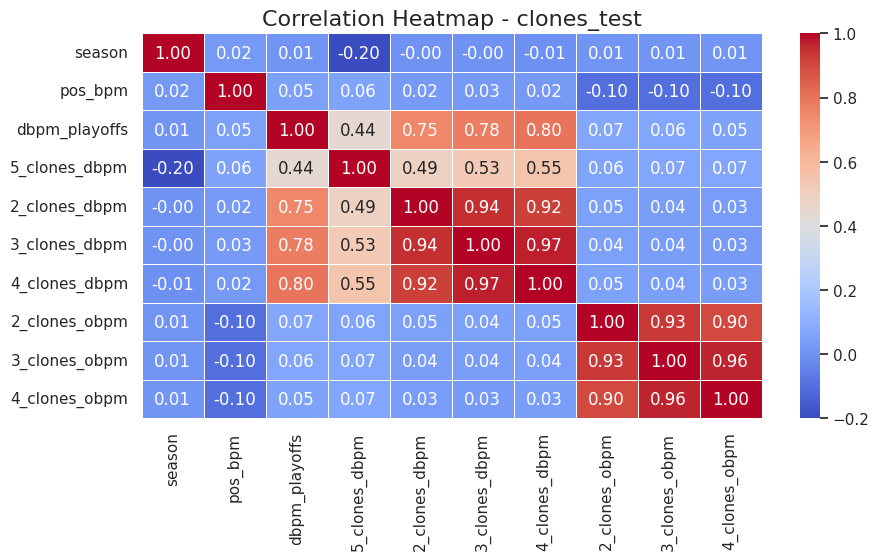

In [ ]:
# Mapa de correlación test
correlation_matrix = clones_test.corr(numeric_only=True)
plt.figure(figsize=(10, 5))
sbrn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap - clones_test', fontsize=16)
plt.show()

---
# 10.1. Predicciones OFF agregando "Clones"
---

In [ ]:
print(ext_offense.head(3))

           player  season  pos_bpm  gp   min  scoring_impact  rim_pressure  \
0     Aaron McKie    1997        2  83 19.60           14.17          0.11   
1      Adam Keefe    1997        5  62 14.80           14.92          0.13   
2  Alan Henderson    1997        4  30 16.60           17.15          0.23   

   offball_2pshoot  offball_3pshoot  onball_3pshoot  ...  +/-_trad  \
0             0.25             1.67            0.08  ...      4.30   
1             0.45             0.00            0.00  ...      6.90   
2             0.58             0.00            0.00  ...     -8.20   

   adj_ts%_adv  adj_ra_fg%_szone  adj_fg%_2p_shoot  adj_3p%_trad  \
0        68.35             93.46              0.71         65.40   
1        73.15             95.06              0.81         25.60   
2        66.95             98.96              0.77         25.60   

   adj_ab3_fgm_szone  adj_mr_fga_szone  adj_mr_fg%_szone  adj_oreb_trad  \
0               0.32              4.86             74.46  

In [ ]:
# Drop non-numeric columns and fill NaN values with 0
numeric_clones_off = ext_offense.drop(['player', 'season'], axis=1).fillna(0)

# Normalize the numerical columns
scaler = StandardScaler()
normalized_clones_df = scaler.fit_transform(numeric_clones_off)
pca = PCA(n_components=5)
pca_result = pca.fit_transform(normalized_clones_df)

# Calculate similarity and distance matrix
cosine_sim_matrix = cosine_similarity(normalized_clones_df)
pearson_corr_matrix = pd.DataFrame(normalized_clones_df.T).corr().to_numpy()
pca_eucdist_matrix = euclidean_distances(pca_result)
df_eucdist_matrix = euclidean_distances(normalized_clones_df)

In [ ]:
cosine_clones_off = ext_offense.copy()
cosine_clones_off = cosine_clones_off.apply(lambda row: get_obpm_from_similarity_corrected(row, cosine_sim_matrix,
                                                                                            cosine_clones_off,
                                                                                            num_similar_players_list=[1, 2, 3, 4, 5]), axis=1)

In [ ]:
cos_off_train_features, cos_off_test_features, cos_off_train_target, cos_off_test_target = train_test_split_off(cosine_clones_off, test_season=2023)

In [ ]:
pearson_clones_off = ext_offense.copy()
pearson_clones_off = pearson_clones_off.apply(lambda row: get_obpm_from_similarity_corrected(row, pearson_corr_matrix,
                                                                                              pearson_clones_off,
                                                                                              num_similar_players_list=[1, 2, 3, 4, 5]), axis=1)

In [ ]:
pear_off_train_features, pear_off_test_features, pear_off_train_target, pear_off_test_target = train_test_split_off(pearson_clones_off, test_season=2023)

In [ ]:
pca_clones_off = ext_offense.copy()
pca_clones_off = pca_clones_off.apply(lambda row: get_obpm_from_distance_corrected(row, pca_eucdist_matrix,
                                                                                    pca_clones_off,
                                                                                    num_similar_players_list=[1, 2, 3, 4, 5]), axis=1)

In [ ]:
pca_off_train_features, pca_off_test_features, pca_off_train_target, pca_off_test_target = train_test_split_off(pca_clones_off, test_season=2023)

In [ ]:
euclidean_clones_off = ext_offense.copy()
euclidean_clones_off = euclidean_clones_off.apply(lambda row: get_dbpm_from_distance_corrected(row, df_eucdist_matrix,
                                                                                                euclidean_clones,
                                                                                                num_similar_players_list=[1, 2, 3, 4, 5]), axis=1)

In [ ]:
euc_off_train_features, euc_off_test_features, euc_off_train_target, euc_off_test_target = train_test_split_off(euclidean_clones_off, test_season=2023)

In [ ]:
# Evaluación de modelos con dataset original para referencia

evaluate_models(ext_offense_train_features, ext_offense_train_target, ext_offense_test_features, ext_offense_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.9334783428001991
R-squared Score: 0.9162898065728724
Test Set:
Mean Squared Error: 7.221039848101267
R-squared Score: 0.36511988140473206

Linear Regression Model:
Training Set:
Mean Squared Error: 6.2203749579997805
R-squared Score: 0.4421843903079449
Test Set:
Mean Squared Error: 7.068390670651292
R-squared Score: 0.3785409301624665

Ridge Regression Model:
Training Set:
Mean Squared Error: 6.2352727377266
R-squared Score: 0.440848423563579
Test Set:
Mean Squared Error: 6.790243641917818
R-squared Score: 0.40299585941142524


In [ ]:
# Evaluación de modelos con dataset CLONES COSINE DISTANCE

evaluate_models(cos_off_train_features, cos_off_train_target, cos_off_test_features, cos_off_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.8318255351270553
R-squared Score: 0.9254055790579667
Test Set:
Mean Squared Error: 6.183896392405063
R-squared Score: 0.45630643818932737

Linear Regression Model:
Training Set:
Mean Squared Error: 5.650777902242506
R-squared Score: 0.4932633254334591
Test Set:
Mean Squared Error: 6.047282649566854
R-squared Score: 0.4683176375566417

Ridge Regression Model:
Training Set:
Mean Squared Error: 5.662272694614068
R-squared Score: 0.49223252348690116
Test Set:
Mean Squared Error: 5.90323196756339
R-squared Score: 0.4809826990987319


In [ ]:
# Evaluación de modelos con dataset CLONES PEARSON CORRELATION

evaluate_models(pear_off_train_features, pear_off_train_target, pear_off_test_features, pear_off_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.8245965842052815
R-squared Score: 0.9260538392823245
Test Set:
Mean Squared Error: 6.231549335443039
R-squared Score: 0.45211674989459805

Linear Regression Model:
Training Set:
Mean Squared Error: 5.558216103680028
R-squared Score: 0.5015638565827782
Test Set:
Mean Squared Error: 6.034001380391835
R-squared Score: 0.4694853383208396

Ridge Regression Model:
Training Set:
Mean Squared Error: 5.5684341838106155
R-squared Score: 0.5006475445217833
Test Set:
Mean Squared Error: 5.9684628301464215
R-squared Score: 0.4752475447935419


In [ ]:
# Evaluación de modelos con dataset CLONES DIST EUCLIDEANA EN PCA

evaluate_models(pca_off_train_features, pca_off_train_target, pca_off_test_features, pca_off_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.941204111360239
R-squared Score: 0.9155969939484315
Test Set:
Mean Squared Error: 7.257513645569621
R-squared Score: 0.36191307333422706

Linear Regression Model:
Training Set:
Mean Squared Error: 6.209365435757264
R-squared Score: 0.44317167538377933
Test Set:
Mean Squared Error: 7.023495851466583
R-squared Score: 0.3824881218035422

Ridge Regression Model:
Training Set:
Mean Squared Error: 6.2246333072431295
R-squared Score: 0.4418025204535553
Test Set:
Mean Squared Error: 6.734202976342201
R-squared Score: 0.40792300358390365


In [ ]:
# Evaluación de modelos con dataset CLONES DIST EUCLIDEANA

evaluate_models(euc_off_train_features, euc_off_train_target, euc_off_test_features, euc_off_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.9173742538614847
R-squared Score: 0.9177339497717211
Test Set:
Mean Squared Error: 7.323383443037974
R-squared Score: 0.3561217433169096

Linear Regression Model:
Training Set:
Mean Squared Error: 6.078017877481932
R-squared Score: 0.45495034126736744
Test Set:
Mean Squared Error: 7.174290140309184
R-squared Score: 0.36923015646922097

Ridge Regression Model:
Training Set:
Mean Squared Error: 6.093745891062944
R-squared Score: 0.4535399228369392
Test Set:
Mean Squared Error: 6.8728881693325965
R-squared Score: 0.39572968051336244


---
# 11. Adición de arquetipos y percentiles OFF
---

In [ ]:
# Unión de dataframes para contar con ARQ DEF

print(ext_offense.shape)
ext_off_arch = pd.merge(ext_offense, off_arch, on=['player', 'season'])
print(ext_off_arch.shape)

(4172, 114)
(4172, 115)


In [ ]:
print(ext_off_arch.head(3))

           player  season  pos_bpm  gp   min  scoring_impact  rim_pressure  \
0     Aaron McKie    1997        2  83 19.60           14.17          0.11   
1      Adam Keefe    1997        5  62 14.80           14.92          0.13   
2  Alan Henderson    1997        4  30 16.60           17.15          0.23   

   offball_2pshoot  offball_3pshoot  onball_3pshoot  ...  adj_ts%_adv  \
0             0.25             1.67            0.08  ...        68.35   
1             0.45             0.00            0.00  ...        73.15   
2             0.58             0.00            0.00  ...        66.95   

   adj_ra_fg%_szone  adj_fg%_2p_shoot  adj_3p%_trad  adj_ab3_fgm_szone  \
0             93.46              0.71         65.40               0.32   
1             95.06              0.81         25.60               0.22   
2             98.96              0.77         25.60               0.22   

   adj_mr_fga_szone  adj_mr_fg%_szone  adj_oreb_trad  scor_ver  off_arch  
0              4.86   

In [ ]:
def calculate_percentiles_off(dataframe, archetype_column='off_arch', percentile_list=[10, 25, 50, 75, 95], column_name='obpm_playoffs', exclude_season=None):
    # Group the data by defensive archetype
    if exclude_season is not None:
        dataframe = dataframe[dataframe['season'] != exclude_season]

    grouped_data = dataframe.groupby(archetype_column)[column_name]

    # Calculate percentiles for each defensive archetype
    percentiles_data = grouped_data.describe(percentiles=[p / 100 for p in percentile_list])

    # Extract the relevant percentiles and reset index for a cleaner structure
    percentiles_data = percentiles_data[['{:.0%}'.format(p / 100) for p in percentile_list]].reset_index()

    return percentiles_data

In [ ]:
def add_percentile_columns_off(original_df, percentiles_df, archetype_column='off_arch', percentile_columns=['10%', '25%', '50%', '75%', '95%']):
    # Merge the original DataFrame with the calculated percentiles on 'def_arch'
    merged_data = pd.merge(original_df, percentiles_df, on=archetype_column, how='left')

    # Create new columns for each percentile
    for percentile in percentile_columns:
        new_column_name = f'{archetype_column}_{percentile}_per'
        merged_data[new_column_name] = merged_data[percentile]

    # Drop the redundant percentile columns from the merged DataFrame
    merged_data.drop(columns=percentile_columns, inplace=True)

    return merged_data

In [ ]:
test_per_off = ext_off_arch[['player', 'season', 'obpm_playoffs', 'off_arch']]

In [ ]:
percentiles_result_off = calculate_percentiles_off(test_per_off, column_name='obpm_playoffs')
percentiles_result_fil = calculate_percentiles_off(test_per_off, column_name='obpm_playoffs', exclude_season=2023)

In [ ]:
print(percentiles_result_off)
print('')
print(percentiles_result_fil)

    off_arch   10%   25%   50%   75%  95%
0          0 -4.37 -2.55 -1.00  0.57 3.73
1          1 -6.20 -3.90 -1.90  0.15 2.90
2          2 -2.63 -0.80  0.70  1.92 4.13
3          3 -6.00 -4.50 -2.05 -0.08 4.02
4          4 -0.62  0.60  2.10  3.50 5.51
5          5  0.83  3.00  4.95  6.80 8.48
6          6 -0.70  0.90  2.60  4.35 7.50
7          7 -3.20 -1.70 -0.20  1.15 3.41
8          8 -7.24 -5.65 -3.30 -1.70 0.67
9          9 -5.21 -3.40 -1.60  0.50 3.00
10        10 -3.80 -1.90 -0.40  1.00 3.20
11        11 -2.68 -1.10  0.50  2.00 4.50
12        12 -6.15 -4.20 -2.00 -0.40 1.85

    off_arch   10%   25%   50%   75%  95%
0          0 -3.90 -2.40 -1.00  0.60 3.79
1          1 -6.20 -3.90 -1.80  0.10 2.81
2          2 -2.67 -0.80  0.70  1.90 4.17
3          3 -6.00 -4.43 -1.90  0.03 4.10
4          4 -0.50  0.80  2.20  3.60 5.54
5          5  0.92  3.08  5.10  6.80 8.40
6          6 -0.70  0.95  2.60  4.30 7.50
7          7 -3.27 -1.77 -0.25  1.20 3.30
8          8 -7.24 -5.65 -3.30 -1

In [ ]:
result_df_off = add_percentile_columns_off(test_per_off, percentiles_result_off)

In [ ]:
result_df_off.head(5)

,player,season,obpm_playoffs,off_arch,off_arch_10%_per,off_arch_25%_per,off_arch_50%_per,off_arch_75%_per,off_arch_95%_per
0,Aaron McKie,1997,-2.70,10,-3.80,-1.90,-0.40,1.00,3.20
1,Adam Keefe,1997,-1.70,12,-6.15,-4.20,-2.00,-0.40,1.85
2,Alan Henderson,1997,-0.50,3,-6.00,-4.50,-2.05,-0.08,4.02
3,Allan Houston,1997,2.30,11,-2.68,-1.10,0.50,2.00,4.50
4,Alonzo Mourning,1997,-1.20,4,-0.62,0.60,2.10,3.50,5.51


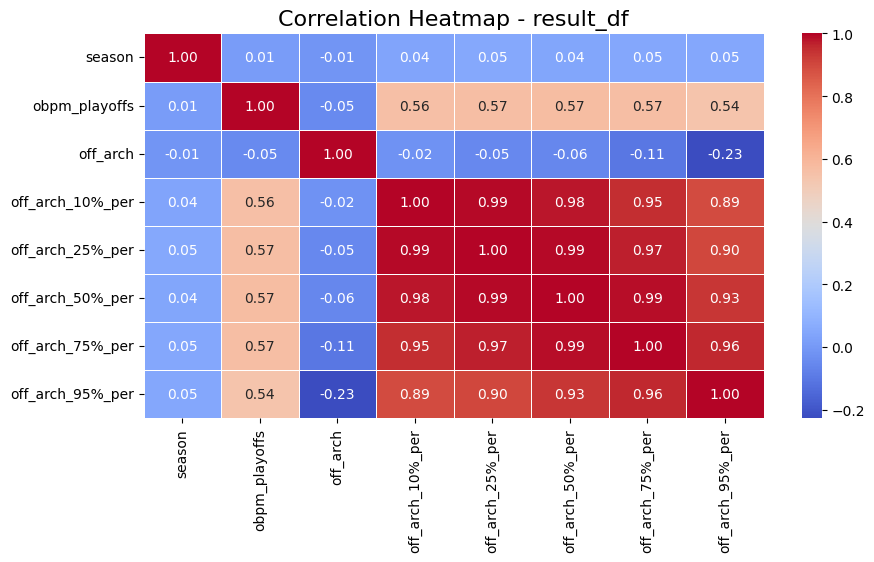

In [ ]:
# Mapa de correlación test
correlation_matrix = result_df_off.corr(numeric_only=True)
plt.figure(figsize=(10, 5))
sbrn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap - result_df', fontsize=16)
plt.show()

---
# 11.1. Predicciones OFF agregando ARQ OFENSIVOS
---

In [ ]:
per_res_off = calculate_percentiles_off(ext_off_arch, column_name='obpm_playoffs', exclude_season=2023)

In [ ]:
ext_off_arch = add_percentile_columns_off(ext_off_arch, per_res_off)

In [ ]:
ext_off_arch.head(3)

,player,season,pos_bpm,gp,min,scoring_impact,rim_pressure,offball_2pshoot,offball_3pshoot,onball_3pshoot,...,adj_mr_fga_szone,adj_mr_fg%_szone,adj_oreb_trad,scor_ver,off_arch,off_arch_10%_per,off_arch_25%_per,off_arch_50%_per,off_arch_75%_per,off_arch_95%_per
0,Aaron McKie,1997,2,83,19.60,14.17,0.11,0.25,1.67,0.08,...,4.86,74.46,3.99,0.68,10,-3.70,-1.90,-0.40,1.02,3.24
1,Adam Keefe,1997,5,62,14.80,14.92,0.13,0.45,0.00,0.00,...,3.56,79.86,6.89,0.61,12,-6.10,-4.17,-2.00,-0.43,1.91
2,Alan Henderson,1997,4,30,16.60,17.15,0.23,0.58,0.00,0.00,...,4.36,63.76,7.49,0.84,3,-6.00,-4.43,-1.90,0.03,4.10


In [ ]:
arch_off_train_features, arch_off_test_features, arch_off_train_target, arch_off_test_target = train_test_split_off(ext_off_arch, test_season=2023)

In [ ]:
# Evaluación de modelos con dataset original para referencia

evaluate_models(ext_offense_train_features, ext_offense_train_target, ext_offense_test_features, ext_offense_test_target)

Random Forest Model:
Mean Squared Error: 7.221039848101267
R-squared Score: 0.36511988140473206

Linear Regression Model:
Mean Squared Error: 7.068390670651292
R-squared Score: 0.3785409301624665

Ridge Regression Model:
Mean Squared Error: 6.790243641917818
R-squared Score: 0.40299585941142524


In [ ]:
%%capture

"""
Random Forest Model:
Mean Squared Error: 7.184201082278482
R-squared Score: 0.36835877781113024

Linear Regression Model:
Mean Squared Error: 7.061755076705206
R-squared Score: 0.37912433736697715

Ridge Regression Model:
Mean Squared Error: 6.792780023266039
R-squared Score: 0.40277285855212597
"""

In [ ]:
# Evaluación de modelos con ARQUETIPOS Y PERCENTILES

evaluate_models(arch_off_train_features, arch_off_train_target, arch_off_test_features, arch_off_test_target)

Random Forest Model:
Mean Squared Error: 7.291737113924051
R-squared Score: 0.3589041161612079

Linear Regression Model:
Mean Squared Error: 7.091718766889422
R-squared Score: 0.3764899036042678

Ridge Regression Model:
Mean Squared Error: 6.8006078083353225
R-squared Score: 0.4020846328647366


---
# 12. Predicciones con dataframes combinados OFENSIVA
---

In [ ]:
# Listado de dataframes
"""
mean_filled_off_past_seasons
rolling_off_df
pearson_clones_off
ext_off_arch
"""

'\nmean_filled_off_past_seasons\nrolling_off_df\npearson_clones_off\next_off_arch\n'

In [ ]:
# List of dataframes

off_df_list = [mean_filled_off_past_seasons,
               #rolling_off_df,
               pearson_clones_off,
               ext_off_arch]

In [ ]:
# Define the columns on which you want to merge
merge_columns = ['player', 'season']

# Use the reduce function to iteratively merge the dataframes
merged_df_off = reduce(lambda left, right: pd.merge(left, right, on=merge_columns, suffixes=('', '_drop')), off_df_list)

# Drop columns with the suffix '_drop'
merged_df_off = merged_df_off.loc[:,~merged_df_off.columns.str.endswith('_drop')]

In [ ]:
print(merged_df_off.head(3))

           player  season  pos_bpm  gp   min  scoring_impact  rim_pressure  \
0     Aaron McKie    1997        2  83 19.60           14.17          0.11   
1      Adam Keefe    1997        5  62 14.80           14.92          0.13   
2  Alan Henderson    1997        4  30 16.60           17.15          0.23   

   offball_2pshoot  offball_3pshoot  onball_3pshoot  ...  2_clones_obpm  \
0             0.25             1.67            0.08  ...          -4.00   
1             0.45             0.00            0.00  ...          -0.60   
2             0.58             0.00            0.00  ...          -3.15   

   3_clones_obpm  4_clones_obpm  5_clones_obpm  off_arch  off_arch_10%_per  \
0          -3.90          -2.80          -2.58         7             -4.84   
1          -1.83          -1.52          -1.86         4             -4.92   
2          -2.57          -2.95          -2.52         1             -6.10   

   off_arch_25%_per  off_arch_50%_per  off_arch_75%_per  off_arch_95%_per

In [ ]:
# Split de train y test:

merged_off_train_features, merged_off_test_features, merged_off_train_target, merged_off_test_target = train_test_split_off(merged_df_off, test_season=2023)

In [ ]:
# Evaluación de modelos con dataset original para referencia
evaluate_models(ext_offense_train_features, ext_offense_train_target, ext_offense_test_features, ext_offense_test_target)

Random Forest Model:
Mean Squared Error: 7.221039848101267
R-squared Score: 0.36511988140473206

Linear Regression Model:
Mean Squared Error: 7.068390670651292
R-squared Score: 0.3785409301624665

Ridge Regression Model:
Mean Squared Error: 6.790243641917818
R-squared Score: 0.40299585941142524


In [ ]:
# Evaluación de modelos con dataset combinado
evaluate_models(merged_off_train_features, merged_off_train_target, merged_off_test_features, merged_off_test_target)

Random Forest Model:
Mean Squared Error: 6.034584911392405
R-squared Score: 0.46943403376655946

Linear Regression Model:
Mean Squared Error: 6.318634313150633
R-squared Score: 0.4444601627357

Ridge Regression Model:
Mean Squared Error: 6.0398076318235105
R-squared Score: 0.4689748476331992


In [ ]:
# Construcción e iniciación del modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamiento del modelo
rf_model.fit(merged_off_train_features, merged_off_train_target)

# Predicciones
off_rf_merged_pred = rf_model.predict(merged_off_test_features)

In [ ]:
comparison_df_off['rf_97_merged'] = off_rf_merged_pred

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(comparison_df_off, x='obpm_playoffs', y='rf_97_merged', color='obpm_playoffs', color_continuous_scale='portland',
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs',
                  xaxis_title='OBPM Postemporada',
                  yaxis_title='OBPM Predicciones R-Forest',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-10, y0=-10, x1=10, y1=10)

# Show the interactive plot
fig.show()

In [ ]:
# Get feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(merged_off_train_features.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

5_clones_obpm: 0.3889094589353523
obpm_bpm: 0.08573416273439848
1_seas_past_obpm_playoffs: 0.032285598159289004
4_clones_obpm: 0.026127423899510272
4_seas_past_obpm_playoffs: 0.024399322777907323
2_seas_past_obpm_playoffs: 0.024234723909173406
3_seas_past_obpm_playoffs: 0.018186636568405246
3_clones_obpm: 0.015017511961856665
5_seas_past_obpm_playoffs: 0.011422382771238125
bpm_bpm: 0.00853491988382742
2_clones_obpm: 0.007479218728816327
min: 0.006790693553144958
1_clones_obpm: 0.006659620186750083
+/-_on-off_pbp: 0.005815220079576737
adj_fg%_2p_shoot: 0.005622572113578822
ft%_trad: 0.005611948136981344
fg%_3-10_shoot: 0.005595191940227654
fg%_10-16_shoot: 0.00548773358773743
pace_adv: 0.005278858981370965
ws/48_bpm: 0.005272070649339179
offrtg_adv: 0.005268199223139672
vorp_bpm: 0.0051925768776073696
adj_ra_fg%_szone: 0.005187153918998042
paint_fg%_szone: 0.005184181576309733
ows_bpm: 0.005033154487294599
%ptsoffto_scor: 0.005028579040153887
adj_ts%_adv: 0.004968847029342111
pie_adv: 0

In [ ]:
common_column = 'player'

# Merge the dataframes using the indicator parameter
merged_df = pd.merge(ext_off_test, ext_off_train, on=common_column, how='outer', indicator=True)

# Select rows that are only in ext_def_test
missing_players = merged_df[merged_df['_merge'] == 'left_only'][common_column]

# Convert the result to a list if needed
missing_players_list = missing_players.tolist()

# Print or use the list as needed
print("Players present in ext_def_test but not in ext_def_train:", missing_players_list)

Players present in ext_def_test but not in ext_def_train: ['Austin Reaves', 'Christian Braun', 'Darius Garland', 'David Roddy', 'Davion Mitchell', "De'Aaron Fox", 'Evan Mobley', 'Haywood Highsmith', 'Isaac Okoro', 'Isaiah Hartenstein', 'Jalen Johnson', 'Jalen McDaniels', 'Jaylen Nowell', 'Jock Landale', 'Josh Hart', 'Josh Okogie', 'Keegan Murray', 'Lonnie Walker IV', 'Malik Monk', 'Mitchell Robinson', 'Nickeil Alexander-Walker', 'Quentin Grimes', 'Saddiq Bey', 'Sam Hauser', 'Santi Aldama', 'Trey Lyles']


---
# 13. Generación de dataframes OFF y DEF (97-14)
---

In [ ]:
nba_24 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/2024_season/merged_dataset_2023-24.csv')
bbref_24 =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/2024_season/reg_season_2024.csv')

In [ ]:
nba_24['player'] = nba_24['player'].str.replace('[^a-zA-Z0-9 ]', '', regex=True)

bbref_24['Player'] = bbref_24['Player'].apply(unidecode)
bbref_24['Player'] = bbref_24['Player'].str.replace('[^a-zA-Z0-9 ]', '', regex=True)

In [ ]:
bbref_col_ls = ['Player', 'Tm', 'G', 'OBPM', 'DBPM', 'BPM', 'VORP']
bbref_24 = bbref_24[bbref_col_ls]
bbref_24.columns = ['player', 'team', 'games', 'obpm_bpm', 'dbpm_bpm', 'bpm_regseas', 'vorp_regseas']

In [ ]:
def single_player_row(dataframe, column_key):
    if dataframe.shape[0] == 1:
        return dataframe
    else:
        row = dataframe[dataframe[column_key] == "TOT"]
        row[column_key] = dataframe.iloc[-1,:][column_key]
        return row

In [ ]:
bbref_24 = bbref_24[bbref_24['player'] != 'player']
bbref_24 = bbref_24.groupby(["player"], group_keys=False).apply(single_player_row, column_key='team')

In [ ]:
numeric_columns = ['games', 'obpm_bpm', 'dbpm_bpm', 'bpm_regseas', 'vorp_regseas']
bbref_24[numeric_columns] = bbref_24[numeric_columns].astype(float)

In [ ]:
bbref_24.sort_values(by='dbpm_bpm', ascending=False)

,player,team,games,obpm_bpm,dbpm_bpm,bpm_regseas,vorp_regseas
347,Nikola Jokic,DEN,75.00,9.10,4.40,13.40,10.20
463,Josh Minott,MIN,29.00,0.40,3.70,4.10,0.10
662,Matisse Thybulle,POR,65.00,-2.80,3.40,0.50,0.90
146,Robert Covington,PHI,29.00,-1.10,3.20,2.10,0.50
439,Jordan McLaughlin,MIN,52.00,1.60,3.20,4.80,1.00
...,...,...,...,...,...,...,...
631,Nick Smith Jr,CHO,48.00,-3.50,-2.70,-6.20,-0.70
229,Keyonte George,UTA,71.00,-1.60,-2.80,-4.40,-1.10
384,Maxwell Lewis,LAL,32.00,-10.10,-3.10,-13.20,-0.30
84,Brandon Boston Jr,LAC,28.00,-5.60,-3.10,-8.70,-0.40


In [ ]:
bbref_24 = bbref_24[bbref_24['games'] > 25]

In [ ]:
stats_2024_df = pd.merge(nba_24, bbref_24, on=['player'], how='right')

In [ ]:
stats_2024_df.head(3)

,player,team_x,pass%_drives,fg%_drives,pts%_drives,tov%_drives,ft%_drives,ftm_drives,pf%_drives,pf_misc,...,painttouch pts_shooting_eff,pull upfg%_shooting_eff,dist. miles def_speed,avg speed off_speed,team_y,games,obpm_bpm,dbpm_bpm,bpm_regseas,vorp_regseas
0,AJ Green,MIL,63.60,40.00,18.20,9.10,0.00,0.00,0.00,3.90,...,0.10,36.40,0.40,4.72,MIL,54.00,-0.20,-1.80,-2.00,0.00
1,AJ Lawson,DAL,20.70,22.20,34.50,6.90,33.30,0.10,10.30,3.50,...,0.60,0.00,0.28,4.75,DAL,38.00,-2.40,-1.20,-3.60,-0.10
2,Aaron Gordon,DEN,32.10,48.20,60.40,7.10,65.40,0.50,9.30,3.10,...,6.80,26.90,1.07,4.15,DEN,70.00,1.00,0.10,1.10,1.80


In [ ]:
stats_2024_df.to_csv('/content/drive/MyDrive/Colab Notebooks/TFM/2024_season/poise_test_data_2024.csv')

---
## 13.1. DEF 1997
---

In [ ]:
aug_ext_defense = ext_defense.copy()

In [ ]:
aug_ext_defense = add_past_playoff_performances(aug_ext_defense)
aug_ext_defense = fill_na_values_custom_def(aug_ext_defense)

In [ ]:
aug_ext_defense = calculate_rolling_def_dynamic(aug_ext_defense, rolling_years_list=[2, 3, 4, 5, 6])

In [ ]:
# Drop non-numeric columns and fill NaN values with 0
numeric_clones_df = ext_defense.drop(['player', 'season'], axis=1).fillna(0)

# Normalize the numerical columns
scaler = StandardScaler()
normalized_clones_df = scaler.fit_transform(numeric_clones_df)

# Calculate similarity and distance matrix
cosine_sim_matrix = cosine_similarity(normalized_clones_df)
pearson_corr_matrix = pd.DataFrame(normalized_clones_df.T).corr().to_numpy()
df_eucdist_matrix = euclidean_distances(normalized_clones_df)

In [ ]:
aug_ext_defense = aug_ext_defense.apply(lambda row: get_dbpm_from_similarity_corrected(row, cosine_sim_matrix,
                                                                                        aug_ext_defense,
                                                                                        num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                        namestring='cos'), axis=1)

In [ ]:
aug_ext_defense = aug_ext_defense.apply(lambda row: get_dbpm_from_similarity_corrected(row, pearson_corr_matrix,
                                                                                        aug_ext_defense,
                                                                                        num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                        namestring='pear'), axis=1)

In [ ]:
aug_ext_defense = aug_ext_defense.apply(lambda row: get_dbpm_from_distance_corrected(row, df_eucdist_matrix,
                                                                                      aug_ext_defense,
                                                                                      num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                      namestring='euc'), axis=1)

In [ ]:
aug_ext_defense = pd.merge(aug_ext_defense, def_arch, on=['player', 'season'])

In [ ]:
aug_ext_defense.to_csv(base_folder_string + 'ML_DEF_1997.csv', index=False)

In [ ]:
# Split de train y test:

aug_ext_def_train_features, aug_ext_def_test_features, aug_ext_def_train_target, aug_ext_def_test_target = train_test_split_def(aug_ext_defense, test_season=2023)

In [ ]:
# Evaluación de modelos con dataset original para referencia
evaluate_models(aug_ext_def_train_features, aug_ext_def_train_target, aug_ext_def_test_features, aug_ext_def_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.26735980891878425
R-squared Score: 0.9013079664855266
Test Set:
Mean Squared Error: 1.9734137594936711
R-squared Score: 0.2130963283111239

Linear Regression Model:
Training Set:
Mean Squared Error: 1.7734367146682064
R-squared Score: 0.345361307716227
Test Set:
Mean Squared Error: 2.0907004612628013
R-squared Score: 0.16632796267142813

Ridge Regression Model:
Training Set:
Mean Squared Error: 1.7734509969985768
R-squared Score: 0.34535603559910044
Test Set:
Mean Squared Error: 2.0839299440437857
R-squared Score: 0.1690277233441433


---
## 13.2. DEF 2014
---

In [ ]:
aug_defense = defense.copy()

In [ ]:
aug_defense.rename(columns = {'dbpm_regseas' : 'dbpm_bpm'}, inplace = True)

In [ ]:
aug_defense = add_past_playoff_performances(aug_defense)
aug_defense = fill_na_values_custom_def(aug_defense)

In [ ]:
aug_defense = calculate_rolling_def_dynamic(aug_defense, rolling_years_list=[2, 3, 4, 5, 6])

In [ ]:
# Drop non-numeric columns and fill NaN values with 0
numeric_clones_df = defense.drop(['player', 'season', 'team'], axis=1).fillna(0)

# Normalize the numerical columns
scaler = StandardScaler()
normalized_clones_df = scaler.fit_transform(numeric_clones_df)

# Calculate similarity and distance matrix
cosine_sim_matrix = cosine_similarity(normalized_clones_df)
pearson_corr_matrix = pd.DataFrame(normalized_clones_df.T).corr().to_numpy()
df_eucdist_matrix = euclidean_distances(normalized_clones_df)

In [ ]:
aug_defense = aug_defense.apply(lambda row: get_dbpm_from_similarity_corrected(row, cosine_sim_matrix,
                                                                                        aug_defense,
                                                                                        num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                        namestring='cos'), axis=1)

In [ ]:
aug_defense = aug_defense.apply(lambda row: get_dbpm_from_similarity_corrected(row, pearson_corr_matrix,
                                                                                        aug_defense,
                                                                                        num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                        namestring='pear'), axis=1)

In [ ]:
aug_defense = aug_defense.apply(lambda row: get_dbpm_from_distance_corrected(row, df_eucdist_matrix,
                                                                                      aug_defense,
                                                                                      num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                      namestring='euc'), axis=1)

In [ ]:
aug_defense = pd.merge(aug_defense, def_arch, on=['player', 'season'])

In [ ]:
aug_defense.to_csv(base_folder_string + 'ML_DEF_2014.csv', index=False)

In [ ]:
aug_defense = aug_defense.drop('team', axis=1)

In [ ]:
# Split de train y test:

aug_def_train_features, aug_def_test_features, aug_def_train_target, aug_def_test_target = train_test_split_def(aug_defense, test_season=2023)

In [ ]:
# Evaluación de modelos con dataset original para referencia
evaluate_models(aug_def_train_features, aug_def_train_target, aug_def_test_features, aug_def_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.12191587030213707
R-squared Score: 0.9543504789674856
Test Set:
Mean Squared Error: 0.8657524791666668
R-squared Score: 0.6275217793063268

Linear Regression Model:
Training Set:
Mean Squared Error: 0.7711452988588697
R-squared Score: 0.7112565127727631
Test Set:
Mean Squared Error: 0.8140532315936695
R-squared Score: 0.6497646769134205

Ridge Regression Model:
Training Set:
Mean Squared Error: 0.772716362213521
R-squared Score: 0.7106682522823624
Test Set:
Mean Squared Error: 0.7792022576109623
R-squared Score: 0.6647588341245156


In [ ]:
# Construcción e iniciación del modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamiento del modelo
rf_model.fit(aug_def_train_features, aug_def_train_target)

# Predicciones
def_rf_merged_pred = rf_model.predict(aug_def_test_features)

In [ ]:
comparison_df_def = aug_defense[aug_defense['season'] == 2023]
comparison_df_def['rf_97_merged'] = def_rf_merged_pred

In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(comparison_df_def, x='dbpm_playoffs', y='rf_97_merged', color='dbpm_playoffs', color_continuous_scale='portland',
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs',
                  xaxis_title='DBPM Postemporada',
                  yaxis_title='DBPM Predicciones R-Forest',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-6, y0=-6, x1=5, y1=5)

# Show the interactive plot
fig.show()

In [ ]:
# Get feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(aug_def_train_features.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

5_euc_clones_dbpm: 0.4489941306876686
4_euc_clones_dbpm: 0.07112477703080389
5_cos_clones_dbpm: 0.06776182130727006
3_euc_clones_dbpm: 0.043789909842348214
5_pear_clones_dbpm: 0.02925962159505037
4_cos_clones_dbpm: 0.02704947599619174
3_cos_clones_dbpm: 0.017149380161668008
4_pear_clones_dbpm: 0.01594281431720955
3_pear_clones_dbpm: 0.014033279443732704
opp ptspaint_def: 0.010277160537517116
pf_misc: 0.009845510797134716
stl%_def: 0.009095693358113123
def rtg_def: 0.008444663737138659
2_cos_clones_dbpm: 0.008379572195306228
2_euc_clones_dbpm: 0.008246345636807793
1_euc_clones_dbpm: 0.007776872774149253
1_cos_clones_dbpm: 0.007590587587954718
Unnamed: 0: 0.007574476062567981
opp pts2nd chance_def: 0.0074912684995636246
2_pear_clones_dbpm: 0.007188798203479501
dfg%_imp: 0.0070890171937561565
defws_def: 0.006736771829124956
blka_misc: 0.006511098160941681
pie_defadv: 0.006427466739450879
poss_defadv: 0.0064050008883638244
bpm_regseas: 0.0063224131294392855
opp ptsfb_def: 0.006299486337431

---
## 13.3. OFF 1997
---

In [ ]:
aug_ext_offense = ext_offense.copy()

In [ ]:
aug_ext_offense = add_past_playoff_performances(aug_ext_offense, performance_column='obpm_playoffs')
aug_ext_offense = fill_na_values_custom_off(aug_ext_offense)

In [ ]:
aug_ext_offense = calculate_rolling_off_dynamic(aug_ext_offense, rolling_years_list=[2, 3, 4, 5, 6])

In [ ]:
# Drop non-numeric columns and fill NaN values with 0
numeric_clones_df = ext_offense.drop(['player', 'season'], axis=1).fillna(0)

# Normalize the numerical columns
scaler = StandardScaler()
normalized_clones_df = scaler.fit_transform(numeric_clones_df)

# Calculate similarity and distance matrix
cosine_sim_matrix = cosine_similarity(normalized_clones_df)
pearson_corr_matrix = pd.DataFrame(normalized_clones_df.T).corr().to_numpy()
df_eucdist_matrix = euclidean_distances(normalized_clones_df)

In [ ]:
aug_ext_offense = aug_ext_offense.apply(lambda row: get_obpm_from_similarity_corrected(row, cosine_sim_matrix,
                                                                                        aug_ext_offense,
                                                                                        num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                        namestring='cos'), axis=1)

In [ ]:
aug_ext_offense = aug_ext_offense.apply(lambda row: get_obpm_from_similarity_corrected(row, pearson_corr_matrix,
                                                                                        aug_ext_offense,
                                                                                        num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                        namestring='pear'), axis=1)

In [ ]:
aug_ext_offense = aug_ext_offense.apply(lambda row: get_obpm_from_distance_corrected(row, df_eucdist_matrix,
                                                                                      aug_ext_offense,
                                                                                      num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                      namestring='euc'), axis=1)

In [ ]:
aug_ext_offense = pd.merge(aug_ext_offense, off_arch, on=['player', 'season'])

In [ ]:
aug_ext_offense.to_csv(base_folder_string + 'ML_OFF_1997.csv', index=False)

In [ ]:
# Split de train y test:

aug_ext_off_train_features, aug_ext_off_test_features, aug_ext_off_train_target, aug_ext_off_test_target = train_test_split_off(aug_ext_offense, test_season=2023)

In [ ]:
# Evaluación de modelos con dataset original para referencia
evaluate_models(aug_ext_off_train_features, aug_ext_off_train_target, aug_ext_off_test_features, aug_ext_off_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.9283696621823615
R-squared Score: 0.9167479303697178
Test Set:
Mean Squared Error: 7.169450955696203
R-squared Score: 0.3696556217990933

Linear Regression Model:
Training Set:
Mean Squared Error: 6.167734186390513
R-squared Score: 0.4469049809971154
Test Set:
Mean Squared Error: 7.160959968119584
R-squared Score: 0.3704021568290935

Ridge Regression Model:
Training Set:
Mean Squared Error: 6.183797304450993
R-squared Score: 0.4454645118847288
Test Set:
Mean Squared Error: 6.797394521237548
R-squared Score: 0.40236714786764893


---
## 13.4. OFF 2014
---

In [ ]:
aug_offense = offense.copy()
aug_offense = aug_offense.rename(columns={"obpm_regseas": "obpm_bpm"})
aug_offense = aug_offense.replace('-', 0)

In [ ]:
aug_offense = add_past_playoff_performances(aug_offense, performance_column='obpm_playoffs')
aug_offense = fill_na_values_custom_off(aug_offense)

In [ ]:
aug_offense = calculate_rolling_off_dynamic(aug_offense, rolling_years_list=[2, 3, 4, 5, 6])

In [ ]:
# Drop non-numeric columns and fill NaN values with 0
off = offense.copy()
off = off.replace('-', 0)
numeric_clones_df = off.drop(['Unnamed: 0', 'player', 'season', 'team'], axis=1).fillna(0)

# Normalize the numerical columns
scaler = StandardScaler()
normalized_clones_df = scaler.fit_transform(numeric_clones_df)

# Calculate similarity and distance matrix
cosine_sim_matrix = cosine_similarity(normalized_clones_df)
pearson_corr_matrix = pd.DataFrame(normalized_clones_df.T).corr().to_numpy()
df_eucdist_matrix = euclidean_distances(normalized_clones_df)

In [ ]:
aug_offense = aug_offense.apply(lambda row: get_obpm_from_similarity_corrected(row, cosine_sim_matrix,
                                                                                aug_offense,
                                                                                num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                namestring='cos'), axis=1)

In [ ]:
aug_offense = aug_offense.apply(lambda row: get_obpm_from_similarity_corrected(row, pearson_corr_matrix,
                                                                                aug_offense,
                                                                                num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                namestring='pear'), axis=1)

In [ ]:
aug_offense = aug_offense.apply(lambda row: get_obpm_from_distance_corrected(row, df_eucdist_matrix,
                                                                              aug_offense,
                                                                              num_similar_players_list=[1, 2, 3, 4, 5],
                                                                              namestring='euc'), axis=1)

In [ ]:
aug_offense = pd.merge(aug_offense, off_arch, on=['player', 'season'])

In [ ]:
aug_offense.to_csv(base_folder_string + 'ML_OFF_2014.csv', index=False)

In [ ]:
aug_offense = aug_offense.drop('team', axis=1)

In [ ]:
# Split de train y test:

aug_off_train_features, aug_off_test_features, aug_off_train_target, aug_off_test_target = train_test_split_off(aug_offense, test_season=2023)

In [ ]:
# Evaluación de modelos con dataset original para referencia
evaluate_models(aug_off_train_features, aug_off_train_target, aug_off_test_features, aug_off_test_target)

Random Forest Model:
Training Set:
Mean Squared Error: 0.8026635593220338
R-squared Score: 0.922033255899568
Test Set:
Mean Squared Error: 5.285405930555556
R-squared Score: 0.4520835201779597

Linear Regression Model:
Training Set:
Mean Squared Error: 4.665083576684226
R-squared Score: 0.5468569948065377
Test Set:
Mean Squared Error: 5.751333856627422
R-squared Score: 0.40378267205800333

Ridge Regression Model:
Training Set:
Mean Squared Error: 4.693168420230088
R-squared Score: 0.5441289728546125
Test Set:
Mean Squared Error: 5.687576414930373
R-squared Score: 0.4103921460465857


Random Forest Model:
Mean Squared Error: 5.554509263888889
R-squared Score: 0.4241866749695391

Linear Regression Model:
Mean Squared Error: 5.901266645883406
R-squared Score: 0.38823975119659593

Ridge Regression Model:
Mean Squared Error: 5.919429513858095
R-squared Score: 0.3863568807387884

In [ ]:
# Construcción e iniciación del modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamiento del modelo
rf_model.fit(aug_off_train_features, aug_off_train_target)

# Predicciones
off_rf_merged_pred = rf_model.predict(aug_off_test_features)

In [ ]:
comparison_df_off = aug_offense[aug_offense['season'] == 2023]
comparison_df_off['rf_97_merged'] = off_rf_merged_pred

<ipython-input-305-7b742f0868cb>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [ ]:
# Gráfico de dispersión comparativo

# Create the scatter plot using Plotly Express
fig = px.scatter(comparison_df_off, x='obpm_playoffs', y='rf_97_merged', color='obpm_playoffs', color_continuous_scale='portland',
                 hover_data=['player'])

# Customize the layout if needed
fig.update_layout(title='Comparación en BPMs',
                  xaxis_title='OBPM Postemporada',
                  yaxis_title='OBPM Predicciones R-Forest',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))

# Add a line for y = x
fig.add_shape(type="line", x0=-6, y0=-6, x1=10, y1=10)

# Show the interactive plot
fig.show()

In [ ]:
# Get feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(aug_off_train_features.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

obpm_bpm: 0.13343429805608725
obpm_regseas.1: 0.11495662572505873
5_euc_clones_obpm: 0.10858394287084433
5_cos_clones_obpm: 0.05148400127274011
4_euc_clones_obpm: 0.034084604953608016
3_euc_clones_obpm: 0.01991409472241972
2_euc_clones_obpm: 0.016470468339406557
4_pear_clones_obpm: 0.013703352624792563
5_pear_clones_obpm: 0.01256813047635569
4_cos_clones_obpm: 0.009617610728255897
2_cos_clones_obpm: 0.009141066042967355
2_pear_clones_obpm: 0.008768856000679368
offrtg_adv: 0.008118488593517532
3_cos_clones_obpm: 0.008019503315668973
1_seas_past_obpm_playoffs: 0.007918300287436083
1_euc_clones_obpm: 0.007473482121598176
ft%_trad: 0.007407760643260766
vorp_regseas: 0.006892890356041854
ftm_trad: 0.006585555973856992
4_seas_past_obpm_playoffs: 0.006514054047599385
Unnamed: 0: 0.006446491087019698
paint_fg%_shootingzone: 0.0063785914943283294
+/-_trad: 0.006222600319777649
pie_adv: 0.006166505849458178
mr_fg%_shootingzone: 0.006153722042568527
3_seas_past_obpm_playoffs: 0.006126271538815407

---
## 13.4. RESULTADOS 2024
---

In [ ]:
stats_2024 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/2024_season/poise_test_data_2024.csv')
stats_2024['season'] = 2024

In [ ]:
stats_2024[['min', 'dbpm_bpm', 'player']]

,min,dbpm_bpm,player
0,48.50,-1.80,AJ Green
1,44.50,-1.20,AJ Lawson
2,48.90,0.10,Aaron Gordon
3,46.90,0.40,Aaron Holiday
4,47.00,-0.20,Aaron Nesmith
...,...,...,...
399,47.90,-1.20,Yuta Watanabe
400,47.10,-0.20,Zach Collins
401,49.00,0.20,Zeke Nnaji
402,48.10,-0.40,Ziaire Williams


In [ ]:
filtered_def_ls = ['opp\xa0ptspaint_def', 'stl%_def', 'avg\xa0drebdistance_reb', 'opp\xa0ptsoff\xa0tov_def', 'defws_def', 'contesteddreb_reb',
                    'dreb_def', 'pf_misc', 'bpm_regseas', 'dbpm_regseas', 'pie_defadv', 'def\xa0rtg_def', 'gp', '%dreb_def', 'drebchances_reb',
                    'drebchance%_reb', 'stl_def', 'dfg%_imp', 'dist.\xa0miles\xa0def_speed', 'poss_defadv', 'blka_misc', 'dreb_reb', 'dreb%_def',
                    'blk_def', 'dfga_imp', 'contesteddreb%_reb', 'opp\xa0ptsfb_def', '%blk_def', 'min', 'dfgm_imp', 'adjusteddreb\xa0chance%_reb',
                    'opp\xa0pts2nd\xa0chance_def', 'vorp_regseas', 'player', 'season']

In [ ]:
stats_2024.rename(columns = {'opp\xa0pts\xa0tov_def':'opp\xa0ptsoff\xa0tov_def',
                             'pie_adv':'pie_defadv',
                             'poss_adv':'poss_defadv',
                             'dbpm_bpm':'dbpm_regseas'}, inplace = True)

In [ ]:
stats_2024_def = stats_2024[filtered_def_ls]
stats_14_23_def = defense[filtered_def_ls]

In [ ]:
stats_14_23_def['dbpm_playoffs'] = defense['dbpm_playoffs']

In [ ]:
stats_14_24_def = pd.concat([stats_14_23_def, stats_2024_def])
stats_14_24_def = stats_14_24_def.fillna(0)

In [ ]:
filtered_off_ls = ['obpm_regseas', 'vorp_regseas', 'pie_adv', 'pass%_drives', 'fg%_drives', 'painttouch\xa0pts_shooting_eff', 'pts%_drives', '+/-_trad',
                   'avg\xa0speed\xa0off_speed', '3pa_trad', 'tov%_drives', 'pull\xa0upfg%_shooting_eff', 'ft%_drives', '3pm_trad', 'fgm_trad',
                   'tov_trad', '3p%_catch&shoot', 'oreb_oreb', 'ftm_trad', 'poss_adv', 'fgm%ast_scoring', 'to\xa0ratio_adv',
                   'fga_trad', 'ftm_drives', '3fgm%ast_scoring', 'ast/to_adv', 'fg%_pullup', 'pf%_drives', 'player', 'season']

In [ ]:
stats_2024.rename(columns = {'pie_defadv':'pie_adv',
                             'poss_defadv':'poss_adv',
                             'obpm_bpm':'obpm_regseas'}, inplace = True)

In [ ]:
stats_2024_off = stats_2024[filtered_off_ls]
stats_14_23_off = offense[filtered_off_ls]

In [ ]:
stats_14_23_off['obpm_playoffs'] = offense['obpm_playoffs']

In [ ]:
stats_14_24_off = pd.concat([stats_14_23_off, stats_2024_off])
stats_14_24_off = stats_14_24_off.fillna(0)

In [ ]:
aug_offense = stats_14_24_off.copy()
aug_offense = aug_offense.rename(columns={"obpm_regseas": "obpm_bpm"})
aug_offense = aug_offense.replace('-', 0)

In [ ]:
aug_offense = add_past_playoff_performances(aug_offense, performance_column='obpm_playoffs')
aug_offense = fill_na_values_custom_off(aug_offense)

In [ ]:
aug_offense = calculate_rolling_off_dynamic(aug_offense, rolling_years_list=[2, 3, 4, 5, 6])

In [ ]:
# Drop non-numeric columns and fill NaN values with 0
off = stats_14_24_off.copy()
off = off.replace('-', 0)
numeric_clones_df = off.drop(['player', 'season'], axis=1).fillna(0)

# Normalize the numerical columns
scaler = StandardScaler()
normalized_clones_df = scaler.fit_transform(numeric_clones_df)

# Calculate similarity and distance matrix
cosine_sim_matrix = cosine_similarity(normalized_clones_df)
pearson_corr_matrix = pd.DataFrame(normalized_clones_df.T).corr().to_numpy()
df_eucdist_off_matrix = euclidean_distances(normalized_clones_df)

In [ ]:
aug_offense = aug_offense.apply(lambda row: get_obpm_from_similarity_corrected(row, cosine_sim_matrix,
                                                                                aug_offense,
                                                                                num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                namestring='cos'), axis=1)

In [ ]:
aug_offense = aug_offense.apply(lambda row: get_obpm_from_similarity_corrected(row, pearson_corr_matrix,
                                                                                aug_offense,
                                                                                num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                namestring='pear'), axis=1)

In [ ]:
aug_offense = aug_offense.apply(lambda row: get_obpm_from_distance_corrected(row, df_eucdist_matrix,
                                                                              aug_offense,
                                                                              num_similar_players_list=[1, 2, 3, 4, 5],
                                                                              namestring='euc'), axis=1)

In [ ]:
# Prepare a dictionary to hold the resulting rolling averages
rolling_averages = {}
features_to_average = ['obpm_bpm', 'pie_adv', 'vorp_regseas']

for window in range(2, 6):
    # For each feature, calculate the rolling average per player, per season
    for feature in features_to_average:

        col_name = f'{window}_yr_roll_{feature}'
        rolling_averages[col_name] = aug_offense.sort_values('season').groupby('player')[feature]\
                                       .transform(lambda x: x.rolling(window=window, min_periods=1).mean().shift(1))

# Convert the rolling averages dictionary to a DataFrame
rolling_averages_df = pd.DataFrame(rolling_averages)

# Concatenate the original DataFrame with the new rolling averages DataFrame
df_with_rolling_averages = pd.concat([aug_offense, rolling_averages_df], axis=1)

In [ ]:
# Apply forward fill to handle NaN values, grouping by 'player' to ensure continuity within each player's data
aug_offense_filled = df_with_rolling_averages.groupby('player').ffill()
aug_offense_filled = aug_offense_filled.fillna(0)

aug_offense_filled['player'] = aug_offense['player']
aug_offense_filled['season'] = aug_offense['season']
aug_offense_filled['obpm_playoffs'] = aug_offense['obpm_playoffs']

In [ ]:
aug_offense_filled[['player', 'season', 'obpm_playoffs']]

,player,season,obpm_playoffs
0,Aaron Brooks,2015,-4.40
1,Aaron Gordon,2019,1.70
2,Aaron Gordon,2021,-2.20
3,Aaron Gordon,2022,0.90
4,Aaron Gordon,2023,0.40
...,...,...,...
1931,Wendell Carter Jr,2024,0.00
1932,Xavier Tillman Sr,2024,0.00
1933,Yuta Watanabe,2024,0.00
1934,Zeke Nnaji,2024,0.00


In [ ]:
aug_offense_filled.to_csv(base_folder_string + 'POISE_OFF_2024.csv', index=False)

In [ ]:
aug_offense_filled = aug_offense_filled.sort_values(by=['season', 'player'])

comparison_df = aug_offense_filled[aug_offense_filled['season'] == 2024]
comparison_df = comparison_df[['season', 'player']]

In [ ]:
# Split de train y test:

train_feat_off_24, test_feat_off_24, train_tar_off_24, test_tar_off_24 = train_test_split_off(aug_offense_filled, 2024)

scaler = StandardScaler()
norm_train_off_24 = scaler.fit_transform(train_feat_off_24)
norm_test_off_24 = scaler.fit_transform(test_feat_off_24)

In [ ]:
# Construcción e iniciación del modelo XGBoost

off_model = XGBRegressor(subsample= 0.6, n_estimators= 200, min_child_weight= 1, max_depth= 3,
                  learning_rate= 0.01, gamma= 1, colsample_bytree= 0.6, random_state=42)

off_model.fit(norm_train_off_24, train_tar_off_24)

# Make predictions and evaluate
off_model_pred = off_model.predict(norm_test_off_24)

In [ ]:
off_model_pred[0:5]

array([-0.37888888, -1.2338551 ,  1.1763227 , -0.7218492 , -0.696217  ],
      dtype=float32)

In [ ]:
# Get feature importances from the trained model
feature_importances = off_model.feature_importances_

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(train_feat_off_24.columns, feature_importances))

# Sort the list based on importance scores in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_tuples[0:10]:
    print(f"{feature}: {importance}")

obpm_bpm: 0.07243917882442474
vorp_regseas: 0.059606559574604034
pie_adv: 0.05252682417631149
5_seas_past_obpm_playoffs: 0.0500958152115345
4_seas_past_obpm_playoffs: 0.036490119993686676
ftm_trad: 0.034248463809490204
2_yr_rolling_avg_obpm_playoffs: 0.0235473420470953
2_seas_past_obpm_playoffs: 0.02326969988644123
4_yr_roll_vorp_regseas: 0.022801415994763374
6_yr_rolling_avg_obpm_playoffs: 0.022404732182621956


In [ ]:
aug_defense = stats_14_24_def.copy()

In [ ]:
aug_defense.rename(columns = {'dbpm_regseas' : 'dbpm_bpm'}, inplace = True)

In [ ]:
aug_defense = add_past_playoff_performances(aug_defense)
aug_defense = fill_na_values_custom_def(aug_defense)

In [ ]:
aug_defense = calculate_rolling_def_dynamic(aug_defense, rolling_years_list=[2, 3, 4, 5, 6])

In [ ]:
# Drop non-numeric columns and fill NaN values with 0
numeric_clones_df = stats_14_24_def.drop(['player', 'season'], axis=1).fillna(0)

# Normalize the numerical columns
scaler = StandardScaler()
normalized_clones_df = scaler.fit_transform(numeric_clones_df)

# Calculate similarity and distance matrix
cosine_sim_matrix = cosine_similarity(normalized_clones_df)
pearson_corr_matrix = pd.DataFrame(normalized_clones_df.T).corr().to_numpy()
df_eucdist_def_matrix = euclidean_distances(normalized_clones_df)

In [ ]:
aug_defense = aug_defense.apply(lambda row: get_dbpm_from_similarity_corrected(row, cosine_sim_matrix,
                                                                                        aug_defense,
                                                                                        num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                        namestring='cos'), axis=1)

In [ ]:
aug_defense = aug_defense.apply(lambda row: get_dbpm_from_similarity_corrected(row, pearson_corr_matrix,
                                                                                        aug_defense,
                                                                                        num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                        namestring='pear'), axis=1)

In [ ]:
aug_defense = aug_defense.apply(lambda row: get_dbpm_from_distance_corrected(row, df_eucdist_matrix,
                                                                                      aug_defense,
                                                                                      num_similar_players_list=[1, 2, 3, 4, 5],
                                                                                      namestring='euc'), axis=1)

In [ ]:
aug_defense.to_csv(base_folder_string + 'POISE_DEF_2024.csv', index=False)

In [ ]:
aug_defense[['player', 'season', 'dbpm_playoffs']]

,player,season,dbpm_playoffs
0,Aaron Brooks,2015,-2.20
1,Aaron Gordon,2019,1.80
2,Aaron Gordon,2021,-1.80
3,Aaron Gordon,2022,-2.20
4,Aaron Gordon,2023,-0.60
...,...,...,...
1933,Wendell Carter Jr,2024,0.00
1934,Xavier Tillman Sr,2024,0.00
1935,Yuta Watanabe,2024,0.00
1936,Zeke Nnaji,2024,0.00


In [ ]:
aug_defense = aug_defense.sort_values(by=['season', 'player'])

In [ ]:
# Split de train y test:

train_feat_def_24, test_feat_def_24, train_tar_def_24, test_tar_def_24 = train_test_split_def(aug_defense, 2024)

scaler = StandardScaler()
norm_train_def_24 = scaler.fit_transform(train_feat_def_24)
norm_test_def_24 = scaler.fit_transform(test_feat_def_24)

In [ ]:
# Construcción e iniciación del modelo SVM

def_model = SVR(kernel = 'rbf', gamma = 0.001, C = 10)


def_model.fit(norm_train_def_24, train_tar_def_24)

# Make predictions and evaluate
def_model_pred = def_model.predict(norm_test_def_24)

In [ ]:
def_model_pred[0:5]

array([-0.61495188, -0.27542054,  0.4113267 ,  0.56492013,  0.14536822])

In [ ]:
comparison_df['POISE Ofensivo'] = off_model_pred

In [ ]:
comparison_df['POISE Defensivo'] = def_model_pred

In [ ]:
comparison_df.isna().sum()

season             0
player             0
POISE Ofensivo     0
POISE Defensivo    0
dtype: int64

In [ ]:
comparison_df['POISE Total'] = comparison_df['POISE Defensivo'] + comparison_df['POISE Ofensivo']

In [ ]:
comparison_df.isna().sum()

season             0
player             0
POISE Ofensivo     0
POISE Defensivo    0
POISE Total        0
dtype: int64

In [ ]:
comparison_df.sort_values(by='POISE Total', ascending=False)

,season,player,POISE Ofensivo,POISE Defensivo,POISE Total
1299,2024,Nikola Jokic,5.82,3.16,8.97
1106,2024,Luka Doncic,5.81,1.95,7.76
940,2024,Kawhi Leonard,5.53,2.18,7.71
1085,2024,LeBron James,5.73,1.67,7.40
1911,2024,Shai GilgeousAlexander,4.84,2.44,7.28
...,...,...,...,...,...
1770,2024,Brice Sensabaugh,-1.96,-0.93,-2.88
1813,2024,Gradey Dick,-2.02,-1.01,-3.03
1888,2024,Nick Smith Jr,-2.07,-0.99,-3.07
1768,2024,Brandon Boston Jr,-2.01,-1.17,-3.18


In [ ]:
# Gráfico de dispersión comparativo

players_to_label = ['Nikola Jokic', 'LeBron James', 'Stephen Curry', 'Luka Doncic',
                    'Victor Wembanyama', 'Trae Young', 'Rudy Gobert', 'Matisse Thybulle',
                    'Kevin Durant', 'Cade Cunningham', 'Shai GilgeousAlexander']

# Create a new column for text labels, filling with player names or None
comparison_df['label'] = comparison_df['player'].apply(lambda x: x if x in players_to_label else None)

fig = px.scatter(comparison_df, x='POISE Ofensivo', y='POISE Defensivo', color='POISE Total',
                 color_continuous_scale='portland', text='label', hover_data=['player'])

fig.update_traces(textposition='top center')

fig.update_layout(title='Resultados de POISE 2024',
                  xaxis_title='POISE Ofensivo',
                  yaxis_title='POISE Defensivo',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))
fig.add_hline(y=0, line_dash="dash")
fig.add_vline(x=0, line_dash="dash")

fig.show()

In [ ]:
comparison_df.to_csv(base_folder_string + 'POISE_RES_2024.csv', index=False)

In [ ]:
result_df_def = pd.merge(def_arch, aug_defense, on=['player', 'season'], how='left')

In [ ]:
result_df_def = result_df_def[result_df_def['season'] == 2023]

In [ ]:
result_df_off = pd.merge(off_arch, aug_offense, on=['player', 'season'], how='left')

In [ ]:
result_df_off = result_df_off[result_df_off['season'] == 2023]

In [ ]:
arch_df = result_df_off.merge(result_df_def[['player', 'def_arch']],
                              on=['player'],
                              how='left')

In [ ]:
arch_df = arch_df[['player', 'def_arch', 'off_arch']]

In [ ]:
poise_arch_df = pd.merge(comparison_df, arch_df, on=['player'], how='outer')

In [ ]:
poise_arch_df = poise_arch_df[poise_arch_df['season'] == 2024]

In [ ]:
# Step 1: Separate the DataFrame
missing_arch_df = poise_arch_df[poise_arch_df['def_arch'].isna() | poise_arch_df['off_arch'].isna()]
complete_arch_df = poise_arch_df.dropna(subset=['def_arch', 'off_arch'])

# A function to calculate Euclidean distance
def euclidean_distance(row1, row2):
    distance = np.sqrt(np.sum((row1 - row2) ** 2))
    return distance

# Step 2 & 3: For each player with missing archetypes, find the closest match
for index, missing_row in missing_arch_df.iterrows():
    min_distance = np.inf
    closest_index = None

    for i, complete_row in complete_arch_df.iterrows():
        # Calculate distance based on 'POISE Ofensivo' and 'POISE Defensivo'
        distance = euclidean_distance(np.array([missing_row['POISE Ofensivo'], missing_row['POISE Defensivo']]),
                                      np.array([complete_row['POISE Ofensivo'], complete_row['POISE Defensivo']]))

        if distance < min_distance:
            min_distance = distance
            closest_index = i

    # Step 4: Fill in the missing values
    if closest_index is not None:
        poise_arch_df.at[index, 'def_arch'] = poise_arch_df.at[closest_index, 'def_arch']
        poise_arch_df.at[index, 'off_arch'] = poise_arch_df.at[closest_index, 'off_arch']

In [ ]:
poise_arch_df.head(5)

,season,player,POISE Ofensivo,POISE Defensivo,POISE Total,label,def_arch,off_arch
0,"2,024.00",AJ Green,-0.38,-0.61,-0.99,None,0.00,1.00
1,"2,024.00",AJ Lawson,-1.23,-0.28,-1.51,None,0.00,1.00
2,"2,024.00",Aaron Gordon,1.18,0.41,1.59,None,3.00,4.00
3,"2,024.00",Aaron Holiday,-0.72,0.56,-0.16,None,0.00,1.00
4,"2,024.00",Aaron Nesmith,-0.70,0.15,-0.55,None,0.00,10.00


In [ ]:
# Gráfico de dispersión comparativo

players_to_label = ['Nikola Jokic', 'LeBron James', 'Stephen Curry', 'Luka Doncic',
                    'Victor Wembanyama', 'Trae Young', 'Rudy Gobert', 'Matisse Thybulle',
                    'Kevin Durant', 'Cade Cunningham', 'Shai GilgeousAlexander']

# Create a new column for text labels, filling with player names or None
poise_arch_df['label'] = poise_arch_df['player'].apply(lambda x: x if x in players_to_label else None)

fig = px.scatter(poise_arch_df, x='POISE Ofensivo', y='POISE Defensivo', color='def_arch',
                 color_continuous_scale='portland', text='label', hover_data=['player'])

fig.update_traces(textposition='top center')

fig.update_layout(title='Resultados de POISE 2024',
                  xaxis_title='POISE Ofensivo',
                  yaxis_title='POISE Defensivo',
                  hovermode='closest')

fig.update_traces(marker=dict(size=8))
fig.add_hline(y=0, line_dash="dash")
fig.add_vline(x=0, line_dash="dash")

fig.show()

In [ ]:
defensive_archetype_dict = {
    9: 'Protector de aro versátil',
    8: 'Perimetral carterista',
    7: 'Alero versátil',
    6: 'Protector de aro tradicional',
    5: 'Punto de ataque',
    4: 'Alero',
    3: 'Especialista en bloqueos',
    2: 'Reboteador defensivo',
    1: 'Punto de ataque inactivo',
    0: 'Alero inactivo'
}

In [ ]:
offensive_archetype_dict = {
    12: 'Creador de tiros versátil',
    11: 'Tirador-pasador de alto uso',
    10: 'Anotador en canasto',
    9: 'Anotador alero',
    8: 'Tirador-pasador secundario',
    7: 'Anotador en canasto secundario',
    6: 'Tirador en movimiento',
    5: 'Creador de tiros',
    4: 'Pasador conectivo',
    3: 'Tirador suplente',
    2: 'Anotador suplente',
    1: 'Anotador en canasto suplente',
    0: 'Suplente de baja actividad'
}

In [ ]:
poise_arch_df['Arquetipo Ofensivo'] = poise_arch_df['off_arch'].map(offensive_archetype_dict)
poise_arch_df['Arquetipo Defensivo'] = poise_arch_df['def_arch'].map(defensive_archetype_dict)

In [ ]:
poise_df_final = poise_arch_df[['season',	'player',	'POISE Ofensivo',	'POISE Defensivo',	'POISE Total',
                                'Arquetipo Ofensivo',	'Arquetipo Defensivo']]

In [ ]:
playerteam_24 = bbref_24[['player', 'team']]

In [ ]:
poise_df_final = pd.merge(poise_df_final, playerteam_24, on=['player'], how='outer')

In [ ]:
# Specify the desired column order
new_column_order = ['season', 'player', 'team', 'POISE Ofensivo', 'POISE Defensivo', 'POISE Total', 'Arquetipo Ofensivo', 'Arquetipo Defensivo']

# Reindex the DataFrame with the new column order
poise_df_final = poise_df_final[new_column_order]

In [ ]:
poise_df_final.columns = ['Temporada', 'Jugador', 'Equipo', 'POISE Ofensivo', 'POISE Defensivo',
                          'POISE Total', 'Arquetipo Ofensivo', 'Arquetipo Defensivo']

In [ ]:
poise_df_final['Temporada'] = poise_df_final['Temporada'].astype(int)

In [ ]:
poise_df_final = poise_df_final.sort_values(by='POISE Total', ascending=False)

In [ ]:
poise_df_final.head(15)

,Temporada,Jugador,Equipo,POISE Ofensivo,POISE Defensivo,POISE Total,Arquetipo Ofensivo,Arquetipo Defensivo
308,2024,Nikola Jokic,DEN,5.82,3.16,8.97,Creador de tiros,Alero versátil
266,2024,Luka Doncic,DAL,5.81,1.95,7.76,Creador de tiros,Especialista en bloqueos
229,2024,Kawhi Leonard,LAC,5.53,2.18,7.71,Tirador en movimiento,Especialista en bloqueos
261,2024,LeBron James,LAL,5.73,1.67,7.40,Creador de tiros,Especialista en bloqueos
357,2024,Shai GilgeousAlexander,OKC,4.84,2.44,7.28,Creador de tiros,Alero versátil
137,2024,Giannis Antetokounmpo,MIL,5.10,2.03,7.13,Creador de tiros,Alero versátil
198,2024,Joel Embiid,PHI,4.23,1.85,6.09,Creador de tiros,Protector de aro versátil
195,2024,Jimmy Butler,MIA,4.63,1.10,5.73,Creador de tiros,Alero
188,2024,Jayson Tatum,BOS,4.38,1.19,5.57,Creador de tiros,Alero versátil
362,2024,Stephen Curry,GSW,5.77,-0.33,5.44,Tirador en movimiento,Alero inactivo


In [ ]:
poise_df_final.to_csv(base_folder_string + 'POISE_RES_2024.csv', index=False)

In [ ]:
poise_df_final.to_json(base_folder_string + 'POISE_RES_2024.json', orient='records')